## Predictive Customer Lifetime Value

# Business Goal: Identify Highest Value Customers using Machine Learning

Customer lifetime value (CLV) is one the most commonly used metric to know your customer’s worth. What can you do with it? <br> Once you identify customers as, let’s say, high / medium / low value,
target different buckets accordingly
understand customer habits that put them in high value bucket
acquire new customers who are more likely to mimic high value customers

### Prediction
if customer is unseen for a given period of time they are likely to not come back as they are exposed to other options; especially in an essential service e-commerce setting.

In [1]:
import lifetimes
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from lifetimes.datasets import load_dataset
import lifetimes 
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes import GammaGammaFitter
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
import psycopg2
import sqlalchemy as sa
#from sqlalchemy import create_engine
import boto3
import seaborn as sns

from pybats.analysis import analysis
from pybats.point_forecast import median, mean
from pybats.plot import plot_data_forecast, ax_style
from pybats.loss_functions import MAD, MSE, MAPE

import pandas as pd
import numpy as np
import pybats as pb
import sqlalchemy as sa
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
import psycopg2
import boto3
from sshtunnel import SSHTunnelForwarder
import matplotlib.pyplot as plt
from pybats.analysis import *
from pandas.tseries.holiday import USFederalHolidayCalendar
holidays = USFederalHolidayCalendar.rules
# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
fig = plt.figure(figsize=(20,10))


from snowflake.sqlalchemy import URL
import snowflake.connector as sf

<Figure size 1440x720 with 0 Axes>

### Model Based on Negative-Binomial Distribution; using NB Regression 
The Beta Geometric/Negative Binomial Distribution model was introduced in 2004 by P. Fader’s Paper as an improvement of the Pareto/NBD model (the first BTYD) developed by Schmittlein et al. in 1987.

**Recency** (derived from tₓ): the age of the customer at the moment of his last purchase, which is equal to the duration between a customer’s first purchase and their last purchase.  It is the point (relative to their own period of observation) at which the customer made their most recent repeat purchase. This can also be thought of the length of time between a customer’s first and last purchase for the period, measured in increments defined by freq

**Frequency** (x): the number of periods in which the customer has made a repeat purchase.  It is the number of repeat purchases the customer made during the observation period.

**Age of the customer** (T): the age of the customer at the end of the period under study, which is equal to the duration between a customer’s first purchase and the last day in the dataset.  This can also be thought of the length of time between a customer’s first purchase and the end of the period, measured in increments defined by freq

# Database Connection

In [2]:
#Vuori
url = URL(
    host='daasity.snowflakecomputing.com',
    user='eebqdznl6tzxhaqsbyvt_services',
    password='ys5vRNVzo4ezJJzE89Rp8e3R',
    account='daasity', 
    database='EEBQDZNL6TZXHAQSBYVT',
    warehouse='load_wh'
    )
#Create a cursor object.
engine = create_engine(url)
connection = engine.connect()

### Run this in Redshift / Snowflake:
GRANT ALL ON ALL TABLES IN SCHEMA [drp_staging] TO amour_vert_looker

### SQL script
for the predictive LTV model, data needs to be pulled for each customer to include each order date, the number products ordered, and the average amount of the order

In [3]:
sql_ltv = ("""SELECT customer_id, email
                 , date_trunc('month', CAST(order_date as DATE)) as date
                 , count(product_amount) as orders
                 , avg(product_amount) as amount
        FROM uos.orders
        WHERE date >= '2016-01-01'
        AND product_amount >= 0
        GROUP BY customer_id, email, date
""")

### Forecasting SQL Script

In [283]:
# Weekly Data Works Best
sql_forecast = """with sales_table as
         (
             select date_trunc('week', CAST(date_day as DATE)) as week_date, sum(total_gross_margin) as total_gross_margin, avg(prod_discount) as avg_disc, avg(avg_price) as a_price, (avg_disc/a_price) as pdisc, sum(total_units) as total_units, sum(num_orders) as total_orders
             from (
                 select
                     order_id
                   , order_date as date_day
                   , sum(gross_margin) AS total_gross_margin
                   , avg(olr.product_price) as avg_price
                   , avg(olr.product_discount_amount) as prod_discount
                   , sum(num_units) AS total_units
                   , count(distinct order_id) as num_orders
                 from drp.order_line_revenue olr
                 WHERE valid_order_flag = 1
                 group by date_day, order_id
             ) as first
             GROUP BY week_date
             ORDER BY week_date
         )
         select * from sales_table
         order by week_date"""

In [129]:
sql_forecast_product = """with sales_table as
  (
     select date_trunc('week', CAST(date_day as DATE)) as week_date, product_type, avg(prod_discount) as avg_disc, avg(avg_price) as a_price, (avg_disc/a_price) as pdisc, sum(total_gross_margin) as total_gross_margin, sum(total_units) as total_units, sum(num_orders) as total_orders
     from (
         select
             order_id
           , order_date as date_day
           , olr.sku
           , sa.product_type as product_type
           , avg(olr.product_price) as avg_price
           , avg(olr.product_discount_amount) as prod_discount
           , sum(gross_margin) AS total_gross_margin
           , sum(num_units) AS total_units
           , count(distinct order_id) as num_orders
         from drp.order_line_revenue olr
         left join drp.sku_attributes sa on sa.sku = olr.sku
         WHERE valid_order_flag = 1 --AND sa.product_type = 'Joggers'
         group by date_day, order_id, olr.sku, sa.product_type
         --limit 100
     ) as first
     GROUP BY week_date, product_type
     ORDER BY product_type, week_date
  )
  select * from sales_table
  --select product_type, sum(total_gross_margin) from sales_table
  --group by week_date, product_type
  order by product_type, week_date"""

## Functions

In [5]:
def get_data_rs(s, rs_dict):
    engine = sa.create_engine('redshift+psycopg2://'+rs_dict['user']+':'+rs_dict['password']+
                          '@'+rs_dict['host']+':'+rs_dict['port']+'/'+rs_dict['dbname'], connect_args={'sslmode': 'prefer'})
    con = engine.raw_connection()
    df = pd.read_sql(sql, con)
    df.dropna(axis=0,inplace=True)
    df1 = df.sample(frac=s, replace=False)
    df1['date'] = pd.to_datetime(df.date)
    df1['email'] = df1['email'].str.lower()
    datemax = df1.date.max()
    return df1, datemax

In [6]:
def get_data_sf(s, sql):
    engine = create_engine(url)
    con = engine.raw_connection()
    df = pd.read_sql(sql, con)
    df.dropna(axis=0,inplace=True)
    df1 = df.sample(frac=s, replace=False)
    df1.columns = map(str.lower, df1.columns)
    df1['date'] = pd.to_datetime(df1.date)
    df1['email'] = df1['email'].str.lower()
    datemax = df1.date.max()
    return df1, datemax

In [7]:
def rfm_model(data, end_date, f, p):
    rfm1 = lifetimes.utils.summary_data_from_transaction_data(
    data,
    'customer_id',
    'date',
    monetary_value_col='amount',
    observation_period_end=end_date,
    freq=f)
    rfm1 = rfm1[rfm1.monetary_value < 600]
    bgf = BetaGeoFitter(penalizer_coef=p)
    bgf.fit(rfm1['frequency'], rfm1['recency'], rfm1['T'])
    return rfm1, bgf

In [8]:
def rfm_predict(rfm_table, bgf_model, t):
    rfm_table['predicted_num_trxn'] = bgf_model.conditional_expected_number_of_purchases_up_to_time(t, rfm_table['frequency'], rfm_table['recency'], rfm_table['T'])
    rfm_table['probability_alive'] = bgf_model.conditional_probability_alive(rfm_table['frequency'], rfm_table['recency'], rfm_table['T'])
    rfm_table.sort_values(by='predicted_num_trxn')
    return rfm_table

In [9]:
def gg_model(rfmmod, bgf, p, f):
    # Build the Model
    ret_cust = rfmmod[(rfmmod['frequency'] > 0) & (rfmmod['monetary_value'] > 0)]
    ggf = GammaGammaFitter(penalizer_coef = p)
    ggf.fit(ret_cust['frequency'],ret_cust['monetary_value'])
    pred_clt = ggf.customer_lifetime_value(
        bgf, 
        ret_cust['frequency'],
        ret_cust['recency'],
        ret_cust['T'],
        ret_cust['monetary_value'],
        time=12, # months
        freq=f,
        discount_rate=0.01)
    ret_cust['predicted_cltv'] = pred_clt
    ret_cust['exp_profit'] = ggf.conditional_expected_average_profit(ret_cust['frequency'],ret_cust['monetary_value'])
    ret_cust = ret_cust.sort_values('predicted_cltv', ascending=False).round(3)
    return ret_cust

In [10]:
def merge(df_rfm, df_holdout, thresh):
    df_new = pd.merge(df_rfm, df_holdout, on='customer_id')
    df_new.sort_values('predicted_cltv', ascending=False)
    df_new_red = df_new[(df_new.predicted_cltv < thresh) & (df_new.amount < thresh)]
    return df_new, df_new_red

In [11]:
def send_data(results, table_name):
    engine = create_engine(url)
    con = engine.raw_connection()
    results.to_sql(table_name, con=engine, schema='drp_staging', method='multi', chunksize=16000, index=False, if_exists='replace')
    print(table_name+' updated!')

In [12]:
def get_holdout(df, days):
    hold_end = df.date.max()
    hold_begin = hold_end-pd.to_timedelta(days, unit='d')
    df_hold1 = df[(df.date > hold_begin) & (df.date < hold_end)]
    df_hold2 = df_hold1.groupby('customer_id').agg({'orders':'count', 'amount':'sum'}).reset_index()
    df_hold2.columns = ['customer_id', 'trxn', 'amount']
    return df_hold2, hold_begin, hold_end

In [13]:
def km_rfm(rfm_table, threshold):
    rfm_km = rfm_table[['recency', 'frequency', 'monetary_value']]
    rfm_km_r = rfm_km[rfm_km.monetary_value < threshold]
    #standardize all the data:
    standard_scaler = StandardScaler()
    RFM_norm1 = standard_scaler.fit_transform(rfm_km_r)
    RFM_norm1 = pd.DataFrame(RFM_norm1)
    RFM_norm1.columns = ['Recency','Frequency','Amount']
    # Run the K-Means Algorithm
    model_clus3 = KMeans(n_clusters = 3, max_iter=150)
    model_clus3.fit(RFM_norm1)
    rfm_km_r['clusterid'] = model_clus3.labels_
    rfm_cluster = rfm_km_r.reset_index()
    rfm_cluster_group = rfm_cluster.groupby('clusterid')[['recency', 'frequency','monetary_value']].mean().sort_values('recency', ascending=True).reset_index()
    return rfm_cluster, rfm_cluster_group

In [14]:
def ltv_valid(orig_df, bgf_model, cal_hold_end, end_obs_date, frq, t):
    cal_hold = calibration_and_holdout_data(orig_df, 
                                   'customer_id', 
                                   'date',
                                   calibration_period_end=cal_hold_end, #3 years calibration
                                   observation_period_end=obs_end, #2 year holdout
                                   freq = frq)
    cal_hold['predicted_purchases'] = bgf_model.conditional_expected_number_of_purchases_up_to_time(t, cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])
    cal_pred = cal_hold.groupby('frequency_cal')['predicted_purchases'].mean().round(2)
    y1 = pd.DataFrame(cal_pred)
    y1 = y1[y1.index < 7]
    cal_hold_pred = cal_hold.groupby('frequency_cal')['frequency_holdout'].mean()
    y2 = pd.DataFrame(cal_hold_pred)
    y2 = y2[y2.index <7]
    df_y = y1
    df_y['y2'] = y2
    df_y.columns=['predicted', 'holdout']
    df_y['diff'] = df_y['predicted'] - df_y['holdout']
    df_y['percent_error'] = df_y['diff']/df_y['holdout']
    df_y = df_y.reset_index()
    print('Mean Accuracy', df_y.percent_error.mean())
    sns.lineplot(df_y.index, df_y.predicted)
    sns.lineplot(df_y.index, df_y.holdout)
    return df_y

In [ ]:
profit_margin = 0.05
rfm_gamma['CLV'] = rfm_gamma['predicted_cltv']*profit_margin              

# Run Code

## Step 1: Get and Process the Data

In [15]:
# Get the data. Set the first parameter to get a random sample of the dataset.
# (use this for extremely large datasets.)
df, max_date = get_data_sf(1, sql_ltv)

# set values 
#time horizon in the unit frequency (i.e. Days, Months, Weeks, etc.)
t = 12

# Frequecy 
frq = 'M'

# Holdout dataset
df_hold, h_beg, h_end = get_holdout(df, 365)

In [16]:
#check the function output
print(max_date)
print(h_beg)
print(h_end)
print('dataframe: ', df.shape)
print('holdout data: ', df_hold.shape)
df.head()

2020-12-01 00:00:00
2019-12-02 00:00:00
2020-12-01 00:00:00
dataframe:  (950780, 5)
holdout data:  (433886, 3)


customer_id                          email  \
314052  25daeb968cde67f5bde46a00754de4d7  james.bicknell666@hotmail.com   
435051  ea737bc9700a171147768ecf82bc74a2         shirleylangley@aol.com   
232517  33bf03962e04bd2e70ebf9b950670dc6          jdapple7373@gmail.com   
252233  272f670fa4b1e384022f09b2fcc59284            rslord22@icloud.com   
520519  8ab9d3b0018314bb270f083b7364a3bc            kswellsmd@gmail.com   

             date  orders  amount  
314052 2019-11-01       1    89.0  
435051 2020-10-01       1    84.0  
232517 2019-09-01       1    84.0  
252233 2019-05-01       1    68.0  
520519 2020-09-01       1   142.0

### Step 2: Run the Neg. Binomial Model 

In [17]:
# get stop date for last year
max_last = max_date-pd.to_timedelta(365, unit='d')
print(max_last)
# run NB the model: 

rfm_mod, bgf_mod = rfm_model(df, max_last, frq, 0.01)
bgf_mod.summary

2019-12-02 00:00:00


coef  se(coef)  lower 95% bound  upper 95% bound
r      0.331856  0.003252         0.325483         0.338230
alpha  6.662923  0.093040         6.480565         6.845280
a      0.127111  0.004596         0.118103         0.136119
b      0.337729  0.010225         0.317688         0.357770

In [18]:
rfm_mod_all, bgf_mod_all = rfm_model(df, max_date, frq, 0.01)
bgf_mod_all.summary

coef  se(coef)  lower 95% bound  upper 95% bound
r      0.458479  0.002289         0.453992         0.462967
alpha  7.401226  0.049497         7.304212         7.498239
a      0.038833  0.001401         0.036086         0.041579
b      0.219589  0.006468         0.206912         0.232266

### Step 3: Run the Clustering Algorithm on the RFM Table

In [137]:
rfm_cluster, rfm_cluster_group = km_rfm(rfm_mod_all, 500)
rfm_cluster_group

clusterid    recency  frequency  monetary_value
0          0   0.023489   0.013236        0.767625
1          1   5.799614   1.440840      153.838949
2          2  25.866904   3.792726      158.561384

In [138]:
rfm_cluster_group['new_cl_id']=rfm_cluster_group.index.values
rfm_cluster_group

clusterid    recency  frequency  monetary_value  new_cl_id
0          0   0.023489   0.013236        0.767625          0
1          1   5.799614   1.440840      153.838949          1
2          2  25.866904   3.792726      158.561384          2

### Step 4: Run the CLTV Prediction

In [118]:
# set the time period for predicting transactions / probability alive
t = 12

rfm_pred = rfm_predict(rfm_mod_all, bgf_mod_all, t)
print('Predicted rfm shpae:', rfm_pred.shape)

# This is the final CLTV Predictions that need to be pushed back to the database.
# this has the 0 frequency transactions removed...
rc = gg_model(rfm_pred, bgf_mod_all, 0.01, frq)
rc

Predicted rfm shpae: (622270, 6)


frequency  recency       T  monetary_value  \
customer_id                                                                    
810f12ddfc3641f9a701a178e365cd66       16.0   16.033  16.033         505.986   
9c033428fb62699606ecd1280f10ca58       33.0   54.013  54.013         580.327   
ccc87c3a6763de7744ef040d6772e1d7       10.0    9.988   9.988         516.417   
21a233c150a998d3eeee8e39ff525c1c        9.0    9.988   9.988         570.209   
b092cabb8dddd6a1e4ac296c9dd95e5f       16.0   16.033  16.033         417.939   
...                                     ...      ...     ...             ...   
0fc12c82f1fdd77336b64a869a8fae3e        1.0    0.953  57.989          18.500   
bbc41857f54730b2f086ee3bff0dad18        1.0    0.953  57.989          18.500   
25f4b57a8439bb43d4eb038fa9934326        1.0    1.019  59.007          19.000   
23bebdf786b90842b6a91a75dca07465        1.0    0.953  57.989          18.000   
5f5d76b0daa531913b6980e91cd7b9bb        6.0    6.045  57.036          71.167   

                                  predicted_num_trxn  probability_alive  \
customer_id                                                               
810f12ddfc3641f9a701a178e365cd66               8.305              0.997   
9c033428fb62699606ecd1280f10ca58               6.498              0.999   
ccc87c3a6763de7744ef040d6772e1d7               7.071              0.996   
21a233c150a998d3eeee8e39ff525c1c               6.390              0.995   
b092cabb8dddd6a1e4ac296c9dd95e5f               8.305              0.997   
...                                              ...                ...   
0fc12c82f1fdd77336b64a869a8fae3e               0.057              0.215   
bbc41857f54730b2f086ee3bff0dad18               0.057              0.215   
25f4b57a8439bb43d4eb038fa9934326               0.056              0.214   
23bebdf786b90842b6a91a75dca07465               0.057              0.215   
5f5d76b0daa531913b6980e91cd7b9bb               0.006              0.005   

                                  predicted_cltv  exp_profit  
customer_id                                                   
810f12ddfc3641f9a701a178e365cd66        3975.237     510.254  
9c033428fb62699606ecd1280f10ca58        3551.292     582.673  
ccc87c3a6763de7744ef040d6772e1d7        3471.946     523.410  
21a233c150a998d3eeee8e39ff525c1c        3469.544     578.754  
b092cabb8dddd6a1e4ac296c9dd95e5f        3283.843     421.508  
...                                          ...         ...  
0fc12c82f1fdd77336b64a869a8fae3e           1.379      25.754  
bbc41857f54730b2f086ee3bff0dad18           1.379      25.754  
25f4b57a8439bb43d4eb038fa9934326           1.376      26.326  
23bebdf786b90842b6a91a75dca07465           1.349      25.181  
5f5d76b0daa531913b6980e91cd7b9bb           0.426      73.375  

[167802 rows x 8 columns]

In [619]:
import re

In [119]:
print(f"Expected Average Sales: {rc['exp_profit'].mean()}")
print(f"Actual Average Sales: {rc['monetary_value'].mean()}")

Expected Average Sales: 173.66919203585178
Actual Average Sales: 154.12190035875616


In [637]:
df2 = df.drop_duplicates(subset=['email']) 
df2.shape#df.drop_duplicates(subset=['brand'])
df_final = rc.merge(df2[['customer_id','email']], on='customer_id')
df_final = df_final.merge(rfm_cluster[['customer_id','clusterid']], on='customer_id')
df_final['clusterid'] = df_final['clusterid'].map({0:'LVC', 1:'Avg. Cust.', 2:'HVC'})
df_final['wholesaler'] = np.where(df_final['predicted_cltv'] < 1000, 0, 1)
df_final['churn_group'] = np.where(df_final['probability_alive'] < .5, 0, 1)
df_final['pred_trxn'] = df_final.predicted_num_trxn.round(0)
df_final['email_anonymous'] = [shuffle_word(word) for word in df_final['email']]
df_final

customer_id  frequency  recency       T  \
0       b092cabb8dddd6a1e4ac296c9dd95e5f       16.0   16.033  16.033   
1       65fa935e275369b099017dfe8299d812       14.0   19.056  19.056   
2       8824f86a7e781aabb11d8cfd3a58b8c1        8.0    8.017   8.017   
3       bd2e4bce62a9ca10f0f809b215f862ba       10.0   12.025  13.011   
4       5e95b2e1386a8b76d0eaafbed337218b       15.0   20.041  20.041   
...                                  ...        ...      ...     ...   
166490  0fc12c82f1fdd77336b64a869a8fae3e        1.0    0.953  57.989   
166491  bbc41857f54730b2f086ee3bff0dad18        1.0    0.953  57.989   
166492  25f4b57a8439bb43d4eb038fa9934326        1.0    1.019  59.007   
166493  23bebdf786b90842b6a91a75dca07465        1.0    0.953  57.989   
166494  5f5d76b0daa531913b6980e91cd7b9bb        6.0    6.045  57.036   

        monetary_value  predicted_num_trxn  probability_alive  predicted_cltv  \
0              417.939               8.305              0.997        3283.843   
1              482.036               6.467              0.997        2952.406   
2              477.010               6.428              0.994        2925.902   
3              485.300               6.018              0.993        2776.884   
4              436.533               6.670              0.997        2756.030   
...                ...                 ...                ...             ...   
166490          18.500               0.057              0.215           1.379   
166491          18.500               0.057              0.215           1.379   
166492          19.000               0.056              0.214           1.376   
166493          18.000               0.057              0.215           1.349   
166494          71.167               0.006              0.005           0.426   

        exp_profit                        email clusterid  wholesaler  \
0          421.508   ccassaro@vuoriclothing.com       HVC           1   
1          486.701  lanny@hardexerciseworks.com       HVC           1   
2          485.150     katy.dajnowski@gmail.com       HVC           1   
3          491.896   butiyoganorthbay@gmail.com       HVC           1   
4          440.499               ksinema@me.com       HVC           1   
...            ...                          ...       ...         ...   
166490      25.754            hrose96@gmail.com       LVC           0   
166491      25.754         mustang51pgm@aol.com       LVC           0   
166492      26.326              david@fulex.com       LVC           0   
166493      25.181        nickgunnell@gmail.com       LVC           0   
166494      73.375           hersholt@gmail.com       HVC           0   

        churn_group  pred_trxn              email_anonymous  
0                 1        8.0   c.vhiaicsrtrgnosomocuoacl@  
1                 1        6.0  .axdnkycnoh@marrssecrleewoi  
2                 1        6.0     osicmokknady.jlgmtw@a.ai  
3                 1        6.0   .ryhamgoi@lymbtuanioogbtac  
4                 1        7.0               em.asemcoiknm@  
...             ...        ...                          ...  
166490            0        0.0            6gco.aimrsomh9e@l  
166491            0        0.0         5@pcmtoasmmnaul1g.og  
166492            0        0.0              mledd.faocxu@vi  
166493            0        0.0        oaclnckglglum.niem@ni  
166494            0        0.0           latrocsmh@egmiloh.  

[166495 rows x 15 columns]

In [633]:
from random import shuffle
def shuffle_word(word):
    word = list(word)
    shuffle(word)
    return ''.join(word)

In [635]:
#email_anon = re.sub(r'[^@.]', 'x', (i for i in df_final['email']))

#ea = df_final['email'].replace(regex=True,inplace=False,to_replace=r'[^@.]',value=r'x')
ea = [shuffle_word(word) for word in df_final['email']]
ea

['agcscouholcc.ivmst@roairon',
 'arn@e.xnroescmwlcsiyderhaok',
 'gwaac.ykktsm@oj.nmiiadlo',
 'nghmbyiobo.ayrlmtaoa@tcugi',
 '@am.ecknmiosem',
 'huoiot@inomlrccdeaktognv.',
 'mrpacalhbolksbeko.um.ec@wsco',
 'ti@clo.rguihevokopimccn',
 '@amor.chelolayoeic_lyv',
 'ismgvcme1tildp5vs@aaond.e',
 'rhtliugu@.cocimzhnosclovj',
 'lvc@emomc.nbamlpeulm',
 'batimuecmg@om.lalr',
 'ocony0.m2ju2tnaahaddho@0',
 'okcn@mjv.p',
 'orcm@lhcucb.kstwrklotweeamec',
 '.@t.gmeoaeflinmttcuomas',
 'nrtaogcgmiao@lmmlnm.e',
 'oeloy@rrluimhtofkocabt.mbte',
 'mngneliurspml.oa@ttaeisfca',
 'ouootnrlicmmocosn.o@valigh',
 'mivmc.uil@uteeagtnxjolelsij',
 'oklclimyrag@ew.cdmilane',
 'kicgnwmdak.eiepielnl@o.msehc',
 'pwgsaydoheis.ah@dnaeeyliu',
 '.ngohcmrhm@3dailaoteae',
 'l2ao.iimgsja8cm@e0s',
 'tscoaertvn@ccheto.rgomtn',
 '.covsowrsugn@ndhmnoactioil',
 'hitoiacrl@m3misnank.gmh',
 'nmnolyddo.babgbrma@yico',
 'thyu.miahmagg.@lamrcoa',
 'yrtsofoemj@cco.esidrmec',
 'icofot.bclsud@gvkcnhrrroenoimi',
 'keoortgslnui.oci@csuvmtmh

In [ ]:
new_sentence = ' '.join(scramble(word) for word in input.split())

In [142]:
df_final.predicted_cltv.sum()

32697467.07800001

### Predicted CLV by Trx Summary Table

In [123]:
pt1 = df_final[df_final.wholesaler != 1]
pt = pd.DataFrame(pt1.groupby('pred_trxn')['predicted_cltv'].mean()).reset_index()
pt['percent_total'] = pt1.groupby('pred_trxn')['predicted_cltv'].count()/len(pt1)
pt

pred_trxn  predicted_cltv  percent_total
0        0.0       50.770276       0.165185
1        1.0      154.384553       0.573332
2        2.0      303.371316       0.190012
3        3.0      448.238999       0.055537
4        4.0      573.005850       0.012444
5        5.0      670.624164       0.002884
6        6.0      719.668659       0.000550
7        7.0      826.647333       0.000054

### Validation Table

Mean Accuracy -0.017721769699932867


frequency_cal  predicted   holdout      diff  percent_error
0            0.0       0.27  0.377160 -0.107160      -0.284123
1            1.0       0.55  0.744999 -0.194999      -0.261744
2            2.0       1.10  1.075969  0.024031       0.022334
3            3.0       1.48  1.355124  0.124876       0.092151
4            4.0       1.77  1.632037  0.137963       0.084534
5            5.0       2.07  1.829699  0.240301       0.131334
6            6.0       2.33  2.134752  0.195248       0.091462

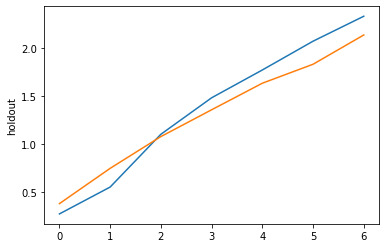

In [124]:
cal_hold_end = max_date-pd.to_timedelta(365, unit='d')
obs_end = df.date.max()
frq = 12

pred_trx_sum = ltv_valid(df, bgf_mod, cal_hold_end, obs_end, 'M', 12)
pred_trx_sum

### Step 4: Send Back to Database

In [638]:
# Send the Predicted LTV Matrix to the Database
send_data(df_final, 'predict_ltv')

# Send Data to Summary CLTV Table
send_data(pt, 'summary_cltv')

# Send Validation to the Database
send_data(pred_trx_sum, 'predicted_trx_summary')

predict_ltv updated!
summary_cltv updated!
predicted_trx_summary updated!


# Model Plots

In [ ]:
plot_period_transactions(bgf_mod)

In [ ]:
cal_hold = calibration_and_holdout_data(df, 
                                   'customer_id', 
                                   'date',
                                   calibration_period_end='2018-11-30', #3 years calibration
                                   observation_period_end='2020-12-31', #2 year holdout
                                   freq = frq)

# plots the efficiacy of the model using the hold-out period
plt.rcParams['figure.figsize'] = (20,10)
bgf = BetaGeoFitter()
bgf.fit(cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, cal_hold)

In [ ]:
fig = plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(bgf_mod)

In [ ]:
fig = plt.figure(figsize=(8,6))
plot_probability_alive_matrix(bgf_mod)

# Model Validation

To validate the model, we take 1 year of hold-out data, and compare the total value of the transactions in that time period for the common customers' predicted CLTV from the previous years.  12 months is a reasonable amount of time to estiamte CLTV.  We're looking for a positive correlation between predicted CLTV and the actual 12-month Sum by customer.

In [2980]:
dff, dff_r = merge(rc, df_hold, 1000)
dff

customer_id  frequency  recency       T  \
0     5a7695aadf6ad8c7b6444a2a3a29ceec       17.0   22.966  22.966   
1     73ec550b09e9764f0a324d9ba553573f       15.0   22.998  25.988   
2     4def63180dc1747c43bb0281b9185b1d       11.0   12.978  14.982   
3     385f49d30e6135eab37f8803d46612e2       16.0   17.939  21.947   
4     b5885f2f4accb3deb74d2666c790fd76       13.0   19.023  20.009   
...                                ...        ...      ...     ...   
9414  e24feee1f00b84d882d2a0d8a0c6ef08        1.0    2.990  38.966   
9415  ae841d5d167e3d3b9b20b7f2f3a41dfa        1.0    0.986  29.997   
9416  1e0c7e215a3fe933fb71fc427f032b9a        1.0    2.004  29.997   
9417  464701780bbba5839ac45e0f659190bf        1.0    1.019  41.003   
9418  5deaeeee9f7e996ae56950186a5c3b12       18.0   18.957  37.980   

      monetary_value  predicted_num_trxn  probability_alive  predicted_cltv  \
0            432.375               7.214              0.994        2952.720   
1            547.333               5.604              0.967        2906.731   
2            473.818               6.365              0.968        2869.201   
3            460.703               6.481              0.914        2828.200   
4            482.769               6.130              0.986        2809.017   
...              ...                 ...                ...             ...   
9414          50.000               0.101              0.313           5.923   
9415          38.000               0.119              0.297           5.459   
9416          28.000               0.136              0.338           4.737   
9417          38.000               0.072              0.234           3.293   
9418         160.320               0.019              0.004           2.889   

      exp_profit  trxn  amount  
0        436.232     7  3740.0  
1        552.804     3   930.0  
2        480.347     1   192.0  
3        465.057     4  1743.0  
4        488.381     3   838.0  
...          ...   ...     ...  
9414      62.778     1    88.0  
9415      48.802     1   108.0  
9416      37.156     2   548.0  
9417      48.802     1   138.0  
9418     161.808     1    64.0  

[9419 rows x 11 columns]

In [2381]:
dff_r

customer_id  frequency  recency       T  \
87     0a9f3d0f26b09f06210b6b7d7076c03f        2.0   11.006  23.984   
89     0c4000eb8dda0411105d6a8dbcfb39ae        3.0   11.992  14.982   
90     bb65bd6e83c21ebf9cb45241ffc64ee7       17.0   17.019  17.019   
91     8c5a7ba41afa440a2c84bd5467ffc4d6        2.0    7.031   7.031   
92     6e3820c65a3b5a7863a2c44f00d77588       13.0   12.978  12.978   
...                                 ...        ...      ...     ...   
9996   e24feee1f00b84d882d2a0d8a0c6ef08        1.0    2.990  38.966   
9997   ae841d5d167e3d3b9b20b7f2f3a41dfa        1.0    0.986  29.997   
9998   1e0c7e215a3fe933fb71fc427f032b9a        1.0    2.004  29.997   
9999   464701780bbba5839ac45e0f659190bf        1.0    1.019  41.003   
10000  5deaeeee9f7e996ae56950186a5c3b12       18.0   18.957  37.980   

       monetary_value  predicted_num_trxn  probability_alive  predicted_cltv  \
87          34720.000               0.674              0.751       24598.313   
89          14177.333               1.692              0.920       24255.838   
90           2888.974               8.819              0.992       24217.911   
91          12232.500               1.871              0.918       24090.283   
92           3075.556               8.182              0.990       24016.586   
...               ...                 ...                ...             ...   
9996           50.000               0.096              0.287           6.142   
9997           38.000               0.116              0.277           5.712   
9998           28.000               0.132              0.315           4.922   
9999           38.000               0.069              0.214           3.401   
10000         160.320               0.019              0.004           2.930   

       exp_profit  trxn   amount  
87      38912.245     1  19313.0  
89      15275.105     1   8463.0  
90       2926.239     1   2108.5  
91      13710.677     1   9096.0  
92       3127.624     1    959.0  
...           ...   ...      ...  
9996       67.839     1     88.0  
9997       52.545     1    108.0  
9998       39.800     2    548.0  
9999       52.545     1    138.0  
10000     162.443     1     64.0  

[9890 rows x 11 columns]

predicted_cltv    amount
predicted_cltv        1.000000  0.271896
amount                0.271896  1.000000

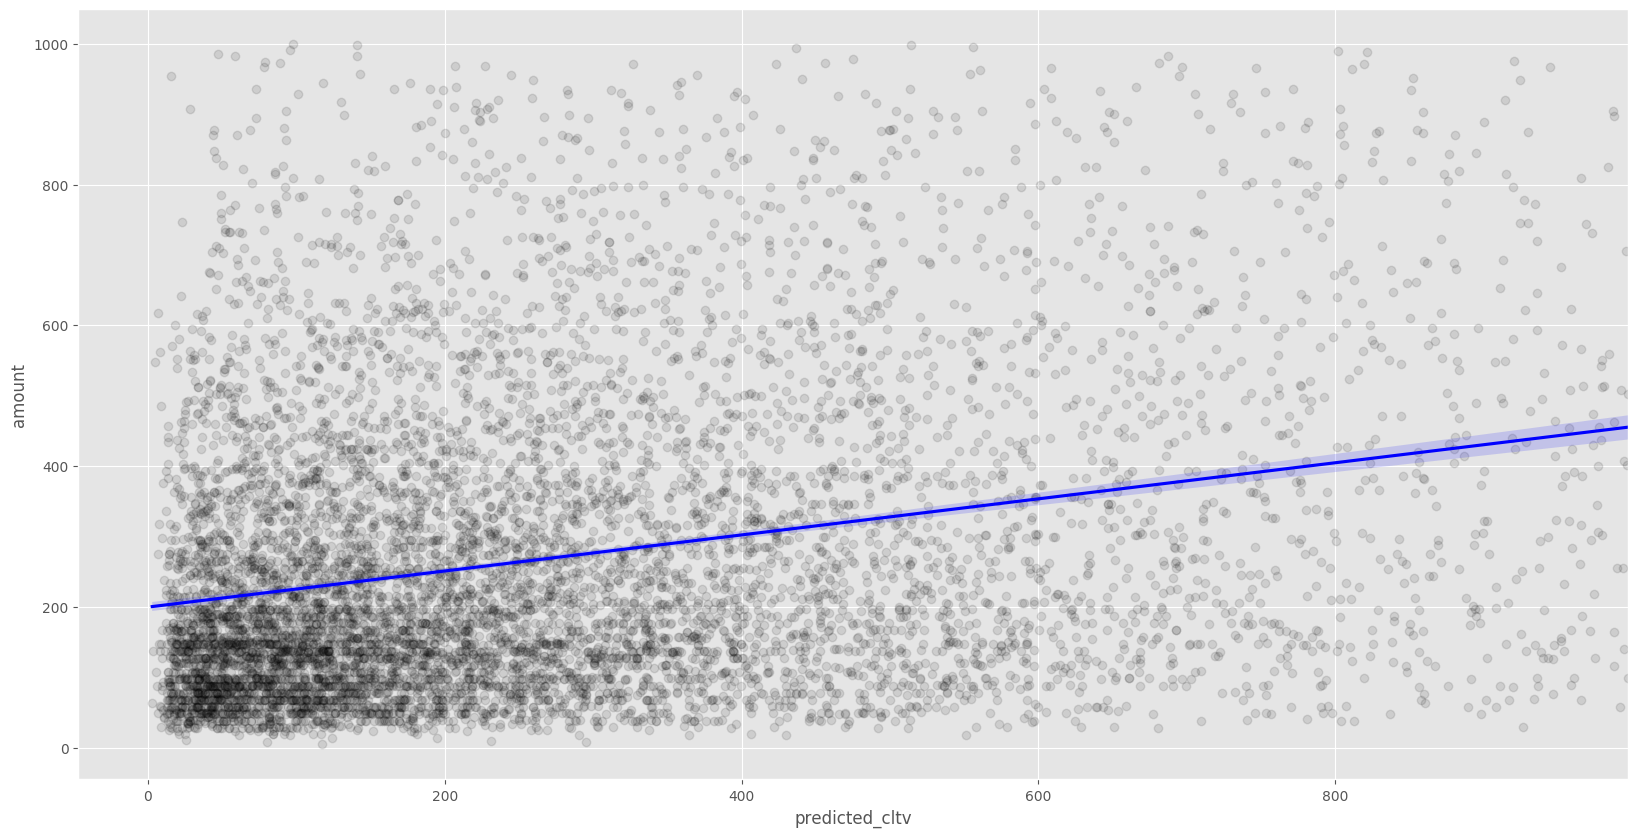

In [2985]:
sns.regplot(dff_r.predicted_cltv, dff_r.amount, scatter_kws={"color": "black", 'alpha':0.1}, line_kws={"color": "blue"})
dff_r[['predicted_cltv','amount']].corr()

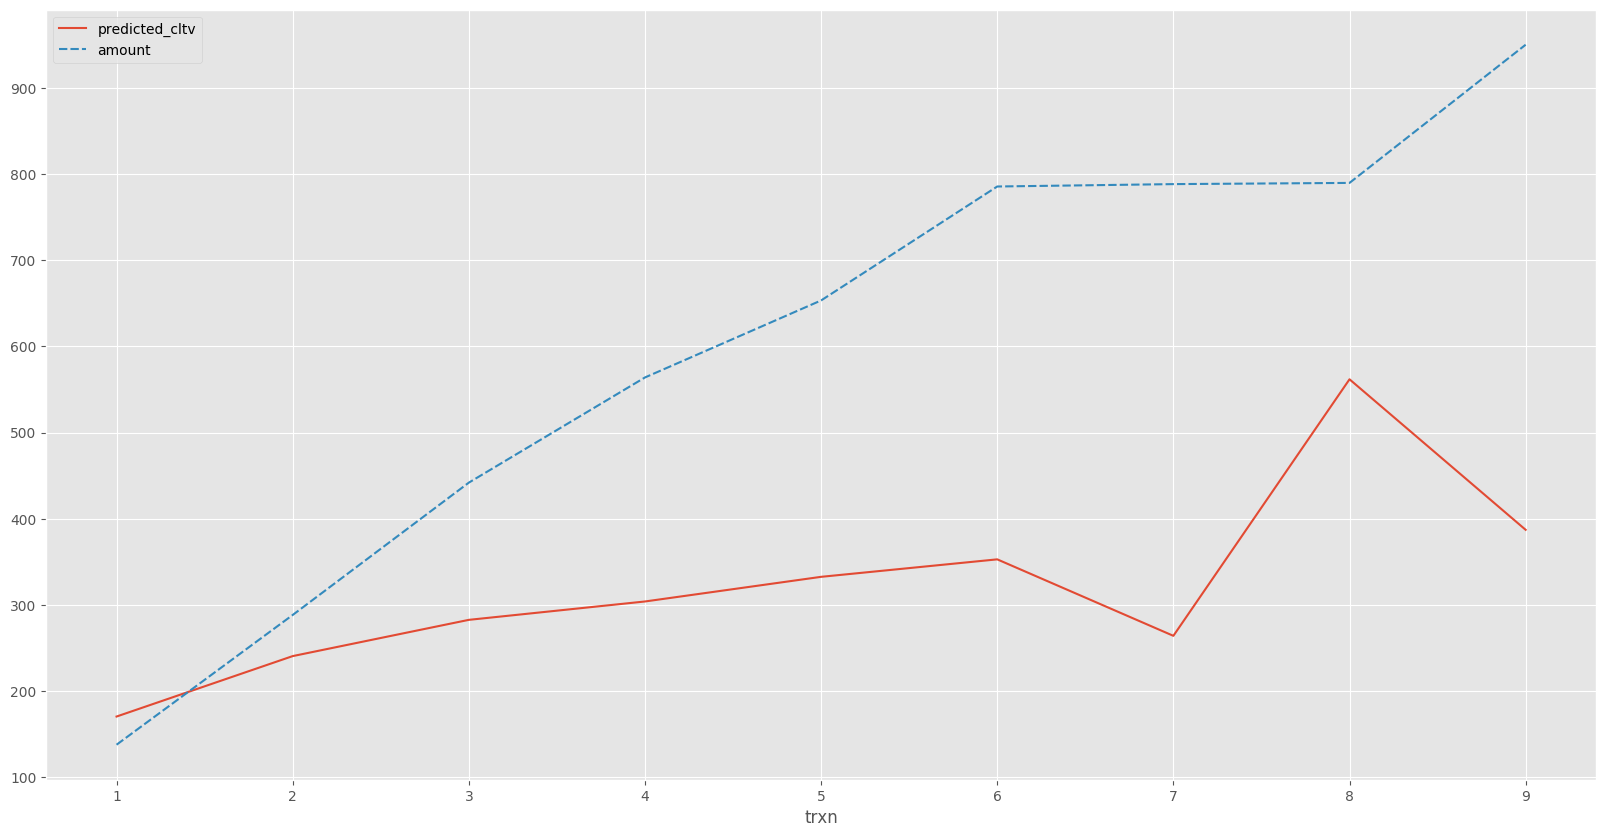

In [2986]:
z = dff_r.groupby('trxn')[['predicted_cltv', 'amount']].median()
sns.lineplot(data=z[z.index <10].iloc[:, :2])

In [2987]:
z = z.reset_index()
z

trxn  predicted_cltv     amount
0     1        170.6910  138.00000
1     2        240.7940  288.50000
2     3        282.8375  442.00000
3     4        304.1480  564.00000
4     5        332.7400  653.33330
5     6        353.0170  785.50000
6     7        264.3145  788.27080
7     8        561.8720  789.66660
8     9        387.2880  949.95200
9    10        569.8005  663.57445

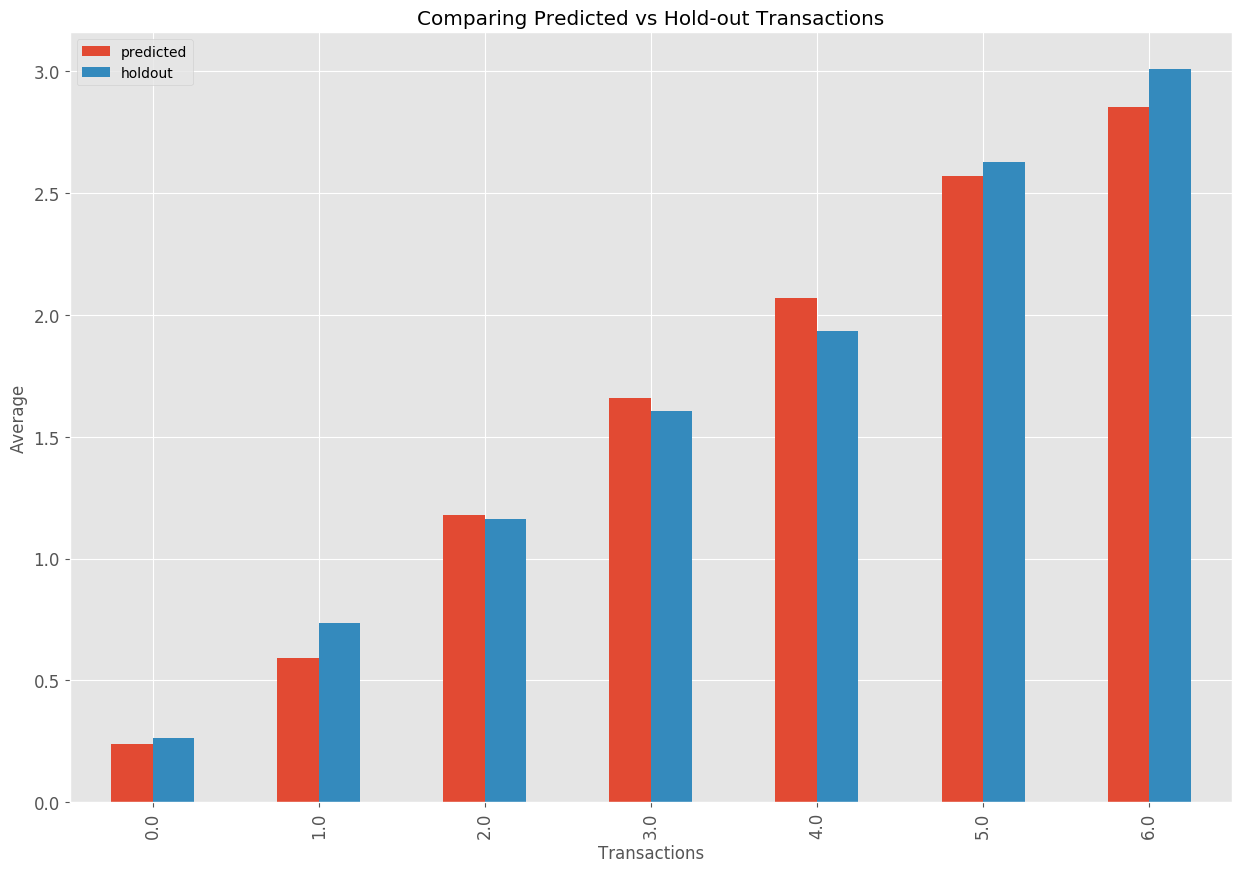

In [2258]:
#import matplotlib.pyplot as plt
ax = df_y[['predicted','holdout']].plot(kind='bar', title ="Comparing Predicted vs Hold-out Transactions", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Transactions", fontsize=12)
ax.set_ylabel("Average", fontsize=12)
plt.show()

# Intuitive Explaination

We now have the prediction for the number of purchases a customer will make in the next 90 days.

the fourth customer, in 519 days, they purchased 1 time, so in one day they purchase 1/519 times = .00192.  The model predicts they will make .057 purchases in the next 90 days.  The predicted value is different that simply .00192*90 = .1734 due to various model assumptions, drop out rates, etc.


# Forecasting

In [296]:
engine = create_engine(url)
con = engine.raw_connection()

In [259]:
def bayes_forecast(y, x, d, lb, fam, pl, discount):
    k=1
    Y=y
    Xf = []
    prior_length = pl
    forecast_start = 0                                 
    forecast_end = len(Y)-1
    #discount = 0.98


    mod, samples = analysis(Y, X=x, family=fam,
    forecast_start=forecast_start,      
    forecast_end=forecast_end,         
    k=k,
    holiday = holidays,
    ntrend=2,
    seasPeriods=[52,12],
    nsamps=2000, 
    seasHarmComponents=[[1,2,3,4,5,6,7],[1,2]],
    prior_length=prior_length, 
    rho=.6,
    deltrend=discount,                      
    delregn=discount,                        
    delVar=discount,
    delseas=discount,
    s0=0.01)

    forecast = median(samples)
    ci = 95
    alpha = (100-ci)/2
    upper = np.percentile(samples, [100-alpha],axis=0).reshape(-1)
    lower = np.percentile(samples, [alpha],axis=0).reshape(-1)
    #x_axis = np.arange(0,y[140:].shape[0],1)
    
    #if x_f is None:
    #    Xf == None
    #else:
    #    Xf = x_f.reshape(-1,1)
    #    
    #future_y = median(mod.forecast_path(tf, X=Xf, nsamps=1000))
    
    print(np.round(MAPE(Y[-lb:], forecast[-lb:]), 4))

    lb = lb

    plt.figure(figsize=(24,15)) 
    plt.plot(d[-lb:], y[-lb:], color='black', linewidth=1, label='Actual')
    plt.plot(d[-lb:],forecast[-lb:], linestyle='--', linewidth=1, label='Predicted', color='red')
    plt.fill_between(d[-lb:], upper[-lb:], lower[-lb:], alpha=.1, color='r', label='95% CI')
    plt.legend(loc="upper left")
    plt.suptitle('Actual vs. Predicted', fontsize=30)
    return plt, forecast, mod, y, d
    

In [255]:
def future(mod, forecast, new_x, t, y, d, lb):
    X = []
    if new_x is None:
        X == None
    else: 
        X = new_x.reshape(-1,1)
    
    future_y = mod.forecast_path(t, X=X, nsamps=1000)
    fy_median = median(future_y)
    
    # set the future date
    d = pd.to_datetime(d)
    future_dates = pd.date_range(d.max(), periods=t, freq='W')[-t:]
    
    ci = 95
    alpha = (100-ci)/2
    upper = np.percentile(future_y, [100-alpha],axis=0).reshape(-1)
    lower = np.percentile(future_y, [alpha],axis=0).reshape(-1)
    
    plt.figure(figsize=(24,15)) 
    plt.plot(d[-lb:], y[-lb:], color='black', linewidth=1, label='Actual')
    plt.plot(d[-lb:], forecast[-lb:], linestyle='--', linewidth=1, label='Predicted', color='red')
    plt.plot(future_dates, fy_median, color='blue')
    plt.fill_between(future_dates, upper, lower, alpha=.1, color='b', label='95% CI')
    
    return fy_median, future_dates

In [30]:
def make_forecast_df(date, actual, forecast, future, future_dates, lb):
    xdf_sales = pd.DataFrame(date[-lb:]).reset_index(drop=True)
    ydf_sales = pd.DataFrame(actual[-lb:]).reset_index(drop=True)
    fdf_sales = pd.DataFrame(forecast[-lb:]).reset_index(drop=True)
    f_sales_df = pd.concat([xdf_sales, ydf_sales, fdf_sales,], axis=1)
    f_sales_df.columns=['date', 'actual', 'predicted']
    x_fut = pd.DataFrame(future_dates).reset_index(drop=True)
    y_fut = pd.DataFrame(future).reset_index(drop=True)
    fut_df = pd.concat([x_fut, y_fut], axis=1)
    fut_df.columns=['date', 'forecast']
    sales_df = pd.concat([f_sales_df, fut_df], axis=0)
    return sales_df

### Get FORECAST Data

In [284]:
df_f = pd.read_sql(sql_forecast, con)
#   # remove where there is no taffic, and the most recent (current) week


In [285]:
df_f.head()

WEEK_DATE  TOTAL_GROSS_MARGIN   AVG_DISC    A_PRICE     PDISC  \
0  2014-12-29                72.0   0.000000  72.000000  0.000000   
1  2015-01-05               149.4  33.200000  83.000000  0.400000   
2  2015-01-12               472.2   5.640000  76.350000  0.073870   
3  2015-01-19               473.8   6.300000  94.916667  0.066374   
4  2015-01-26               252.3  21.016667  96.666667  0.217414   

   TOTAL_UNITS  TOTAL_ORDERS  
0            1             1  
1            3             1  
2            9             4  
3            6             4  
4            4             2

In [286]:
import datetime 
df_f.columns = map(str.lower, df_f.columns)
df_f = df_f[df_f.week_date > pd.Timestamp(2015,12,31)][:-1]
df_f

week_date  total_gross_margin  avg_disc    a_price     pdisc  \
53   2016-01-04        9.810230e+03  8.304932  46.706922  0.177809   
54   2016-01-11        1.706005e+04  7.280961  48.816876  0.149148   
55   2016-01-18        1.324910e+04  7.127248  50.272752  0.141772   
56   2016-01-25        1.258807e+04  6.785155  51.125379  0.132716   
57   2016-02-01        1.419038e+04  6.908478  56.033078  0.123293   
..          ...                 ...       ...        ...       ...   
306  2020-11-09        2.276827e+06  9.741605  80.655876  0.120780   
307  2020-11-16        2.672563e+06  9.222273  80.480298  0.114590   
308  2020-11-23        4.276532e+06  9.882493  75.543059  0.130819   
309  2020-11-30        4.899281e+06  8.483831  80.187097  0.105800   
310  2020-12-07        5.608167e+06  7.964515  80.661663  0.098740   

     total_units  total_orders  
53           292           113  
54           481           196  
55           341           152  
56           313           135  
57           336           149  
..           ...           ...  
306        55194         24018  
307        61357         25847  
308       100347         37412  
309        98865         44164  
310       111113         51297  

[258 rows x 7 columns]

# Test

In [346]:
x2 = np.array([x, x1])

In [357]:
orders_future

array([ 85241. ,  72026.5,  62780. ,  56833. ,  55105.5,  57671. ,
        60163.5,  64133. ,  69189. ,  70090. ,  69923.5,  73035.5,
        80422.5,  97091. , 117660.5, 139217.5, 159925.5, 166809. ,
       171881.5, 178036. , 184328. , 192234.5, 198307.5, 193722.5,
       196646. , 188347. ])

In [358]:
x2_f = np.array([orders_future, v0])

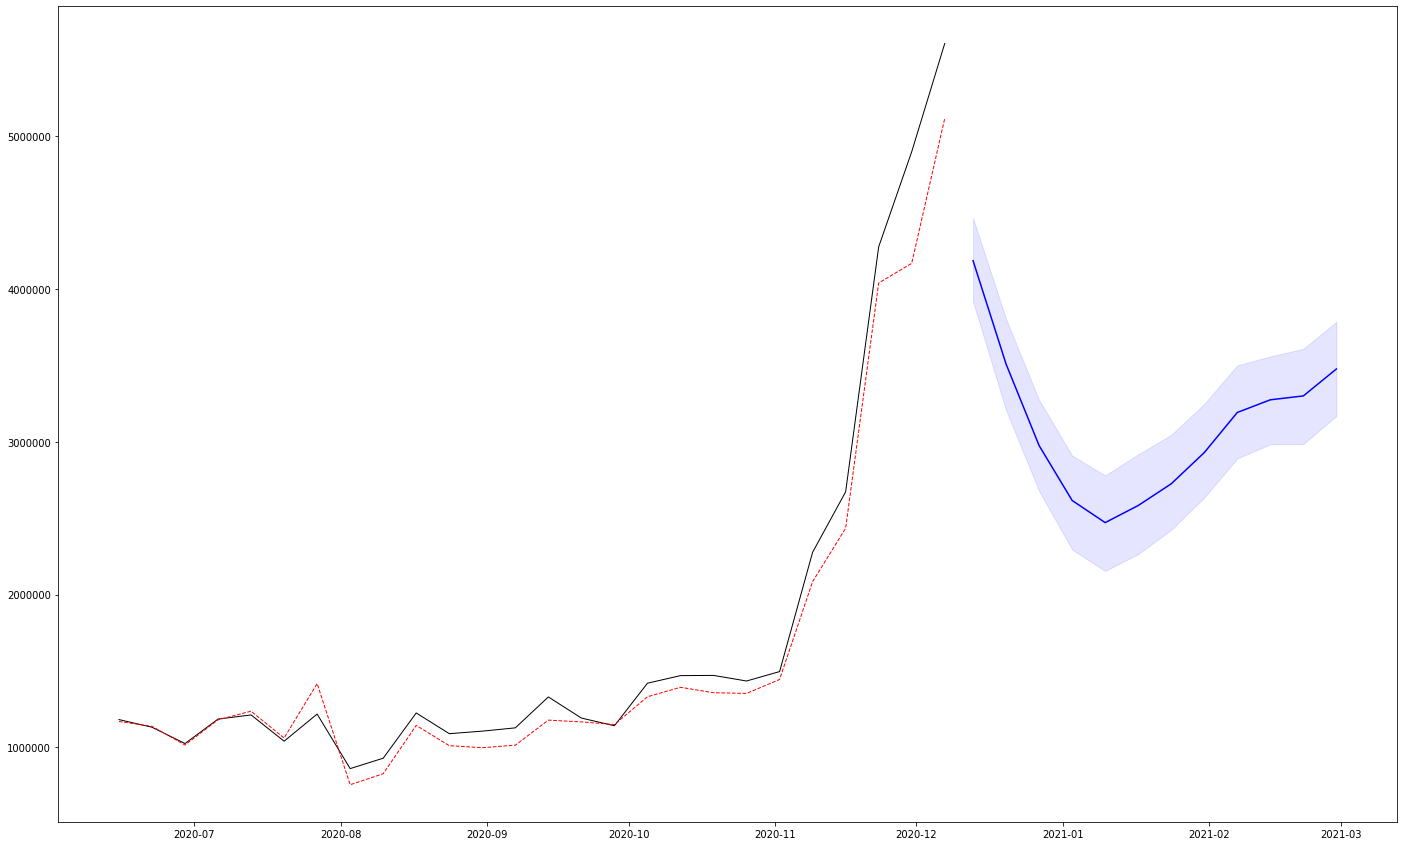

In [391]:
sales_fut, future_dates = future(mod_sales, f, x2_f.reshape(-1,1), 12, y, d, 26)

In [364]:
sales_fut

array([4635581.27721982, 4062446.57371479, 3539788.94054271,
       3142462.21222139, 2960599.68329507, 3016622.68626988,
       3122230.56315991, 3342565.51929736, 3610217.85656847,
       3730937.10163196, 3827446.50645081, 4003288.97513637])

6.3131


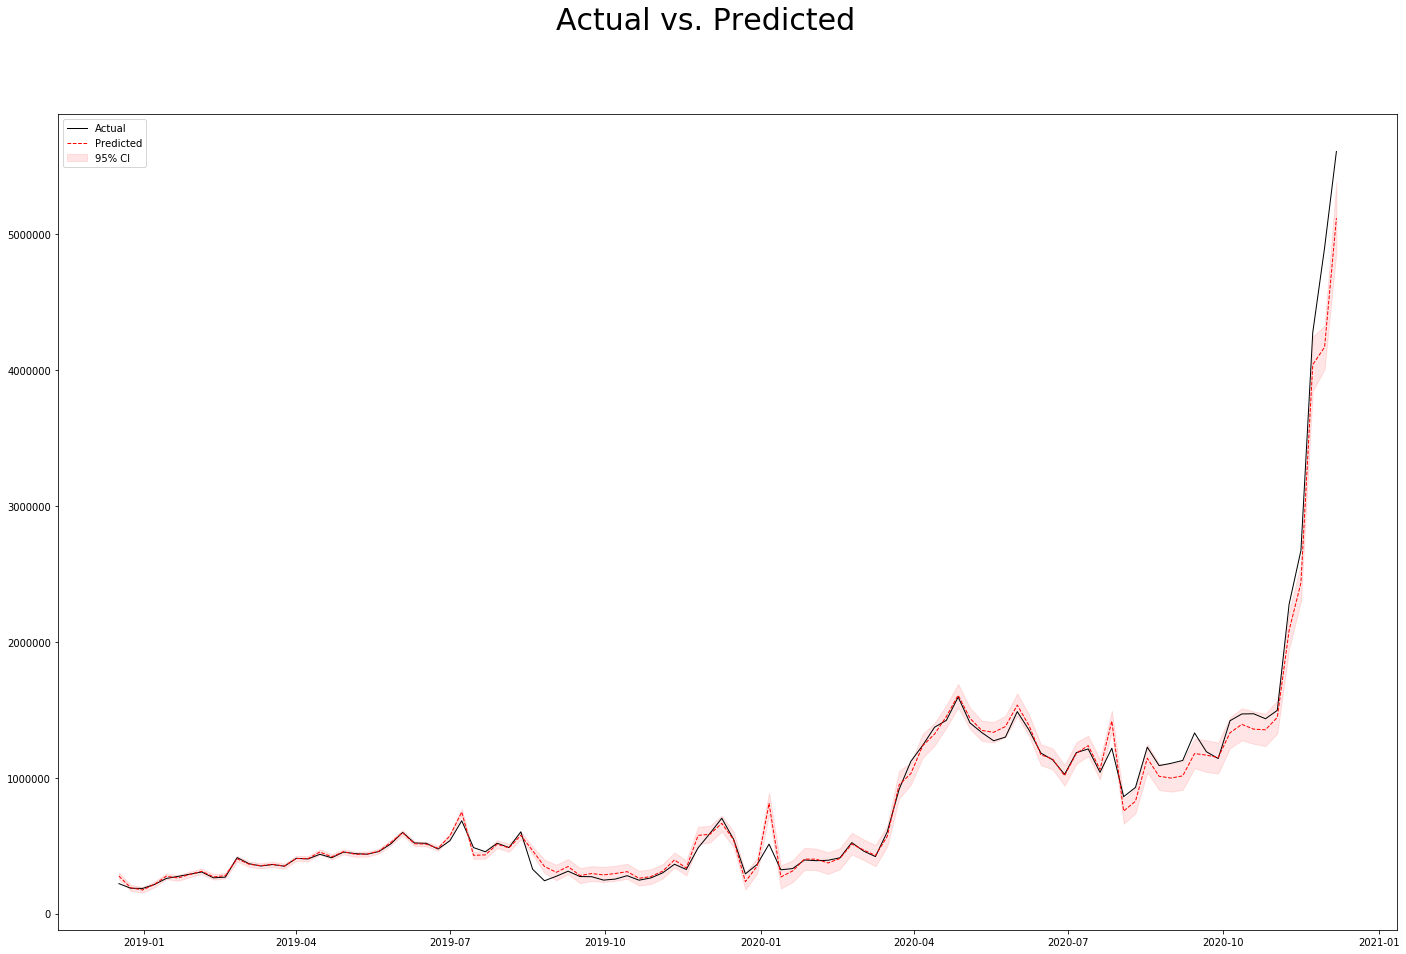

In [390]:
plot, f, mod_sales, y, d = bayes_forecast(y, x2.reshape(-1,1), d, 104, 'normal', 4, .98)

In [385]:
mod_sales.a[mod_sales.iregn].round(4), mod_sales.R.diagonal()[mod_sales.iregn].round(4)

(array([[39.4098]]), array([12.0012]))

In [386]:
mod_sales.a[mod_sales.iregn].round(4)

array([[39.4098]])

In [395]:
print(mod_sales.get_coef('regn'))

AttributeError: 'dlm' object has no attribute 'get_coef'

In [382]:
mod_sales.a

array([[ 7.36243158e+05],
       [ 1.36159375e+04],
       [ 3.94097836e+01],
       [ 5.42458704e+04],
       [ 1.78304650e+05],
       [ 7.61053474e+04],
       [ 2.31225537e+04],
       [ 1.04296803e+05],
       [ 5.35592252e+02],
       [ 6.65645885e+04],
       [-5.16231262e+04],
       [ 4.63956014e+04],
       [-6.46959140e+03],
       [ 5.23883698e+04],
       [-5.89513949e+03],
       [ 2.59238661e+04],
       [-1.10463931e+04],
       [ 1.05041778e+05],
       [ 4.12985014e+04],
       [ 1.58316149e+04],
       [-1.12683774e+04]])

## Sales Forecast
here we are using "number of orders" as an independent variable to predict Sales

In [360]:
# For Forecasting Sales
y = df_f.total_gross_margin.values
x = df_f.total_units.values
x1 = df_f.pdisc.values
d = df_f.week_date
print(len(d))
v = np.repeat(x1[-1:],12)
v0 = np.repeat(.0,12)
v1 = np.repeat(.05,12)
v2 = np.repeat(.1,12)
v3 = np.repeat(.15,12)
v4 = np.repeat(.2,12)
v5 = np.repeat(.25,12)
v6 = np.repeat(.3,12)

258


17.8254
[86555.5 75227.5 66010.5 60894.5 57065.  59207.  59628.  66744.5 68249.5
 70001.  70167.  73472.5]


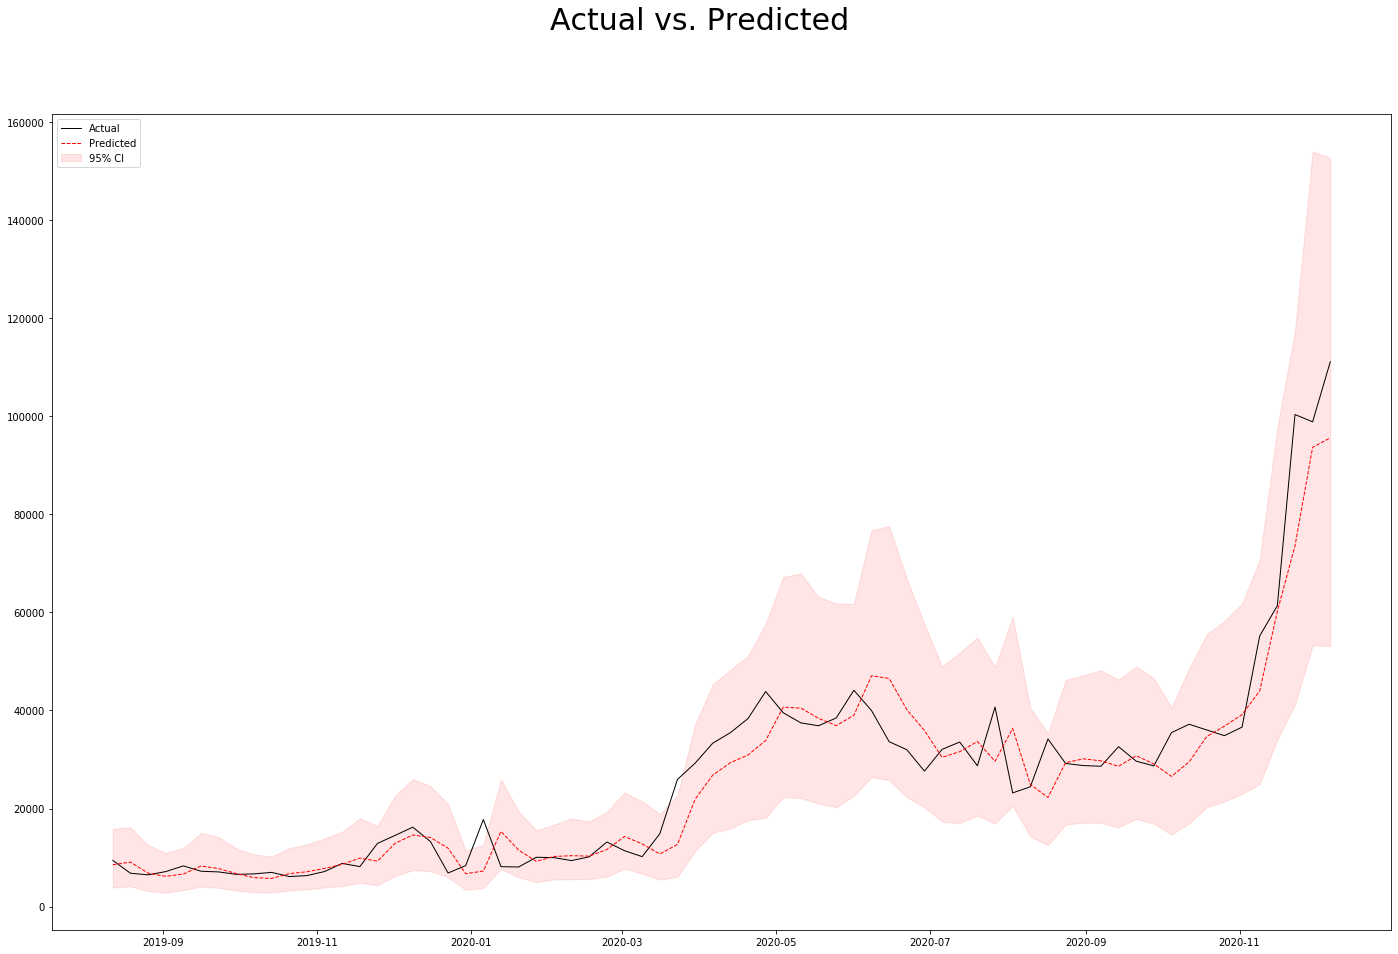

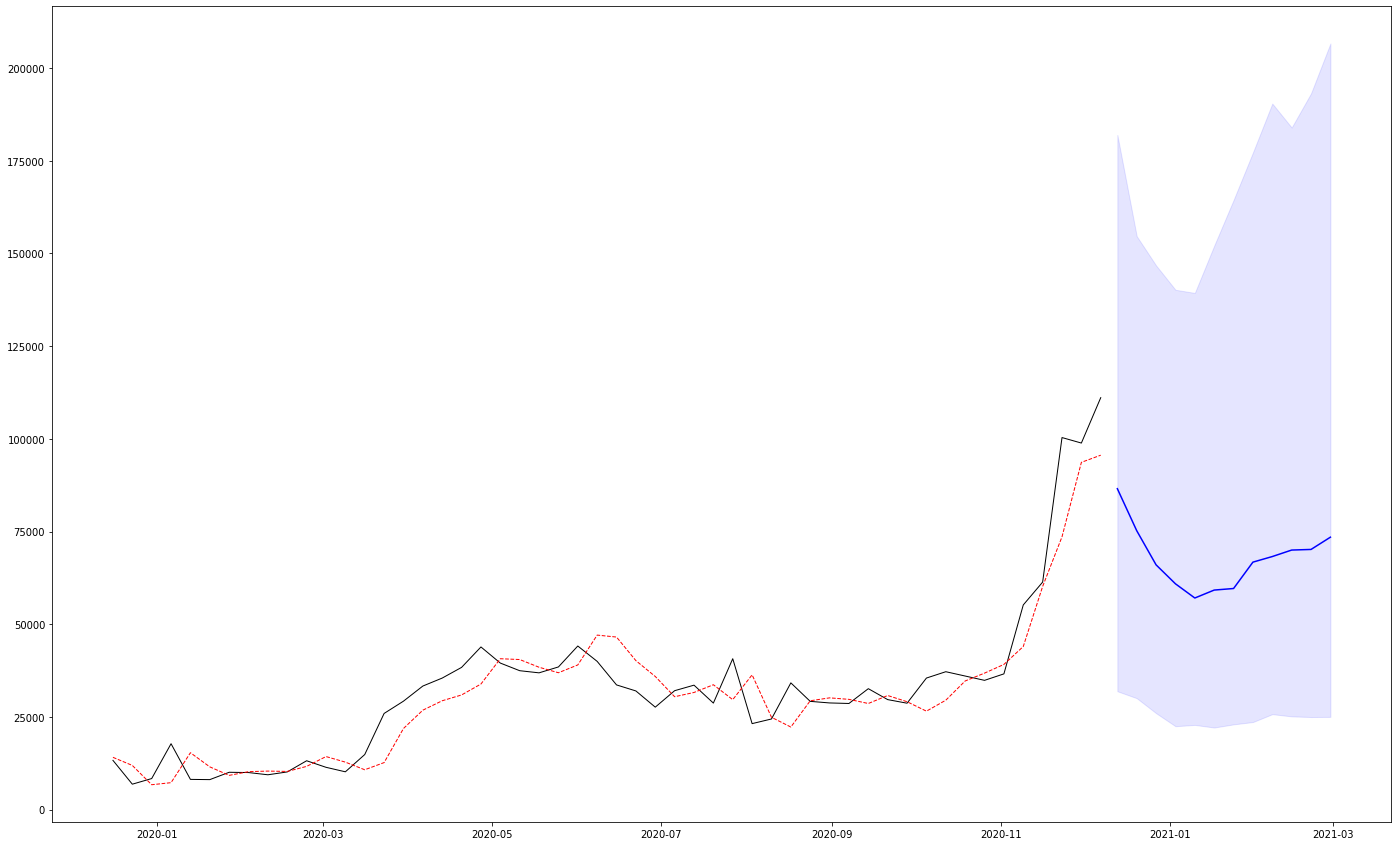

In [361]:
prior_length = 4
look_back = 70
discount = .96

# Need to predict Orders first, since it is the independent variable
plot_orders, orders_f, orders_mod, y_orders, d_orders = bayes_forecast(x, x1, d, look_back, 'poisson', prior_length, discount)

# run the model into the future N steps
orders_future, fo_date = future(orders_mod, orders_f, v0, 12, y_orders, d, 52)
print(orders_future)

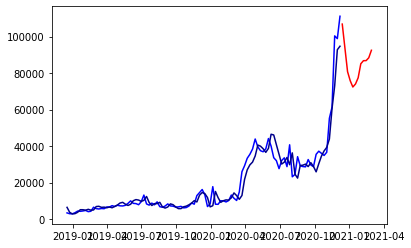

In [294]:
orders_df = make_forecast_df(d_orders, y_orders, orders_f, orders_future, fo_date, 104, 'all_products')
orders_df['date'] = pd.to_datetime(orders_df['date'])
plt.plot(orders_df.date, orders_df.actual, color='blue')
plt.plot(orders_df.date, orders_df.predicted, color='darkblue')
plt.plot(orders_df.date, orders_df.forecast, color='red')

In [340]:
mod_sales.a[mod_sales.iregn].round(4), mod_sales.R.diagonal()[mod_sales.iregn].round(4)

(array([[2959231.1611]]), array([3.88321131e+13]))

16.94


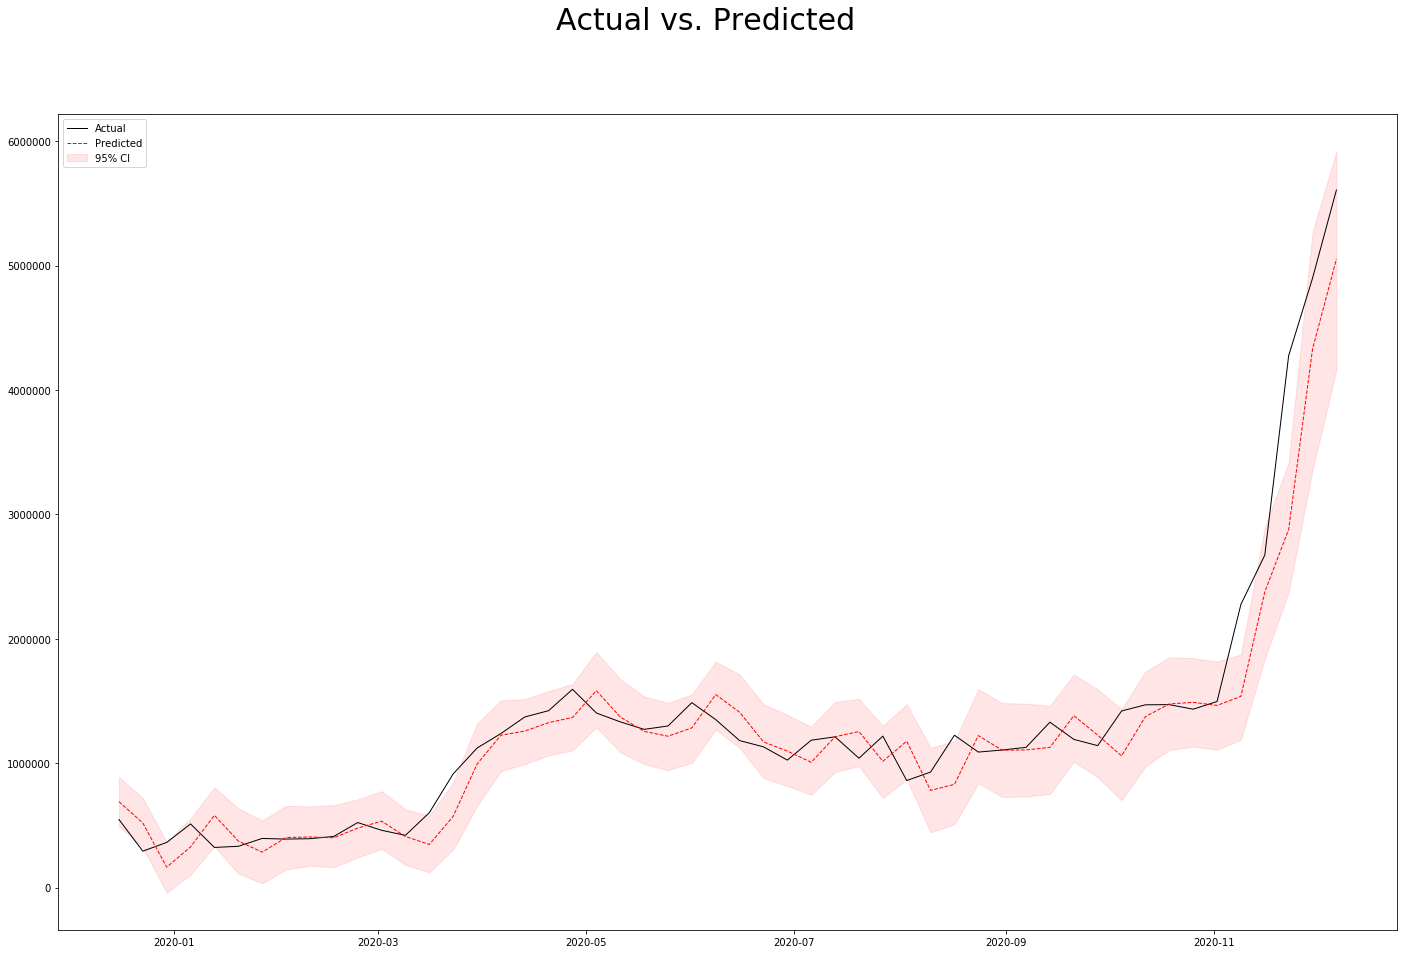

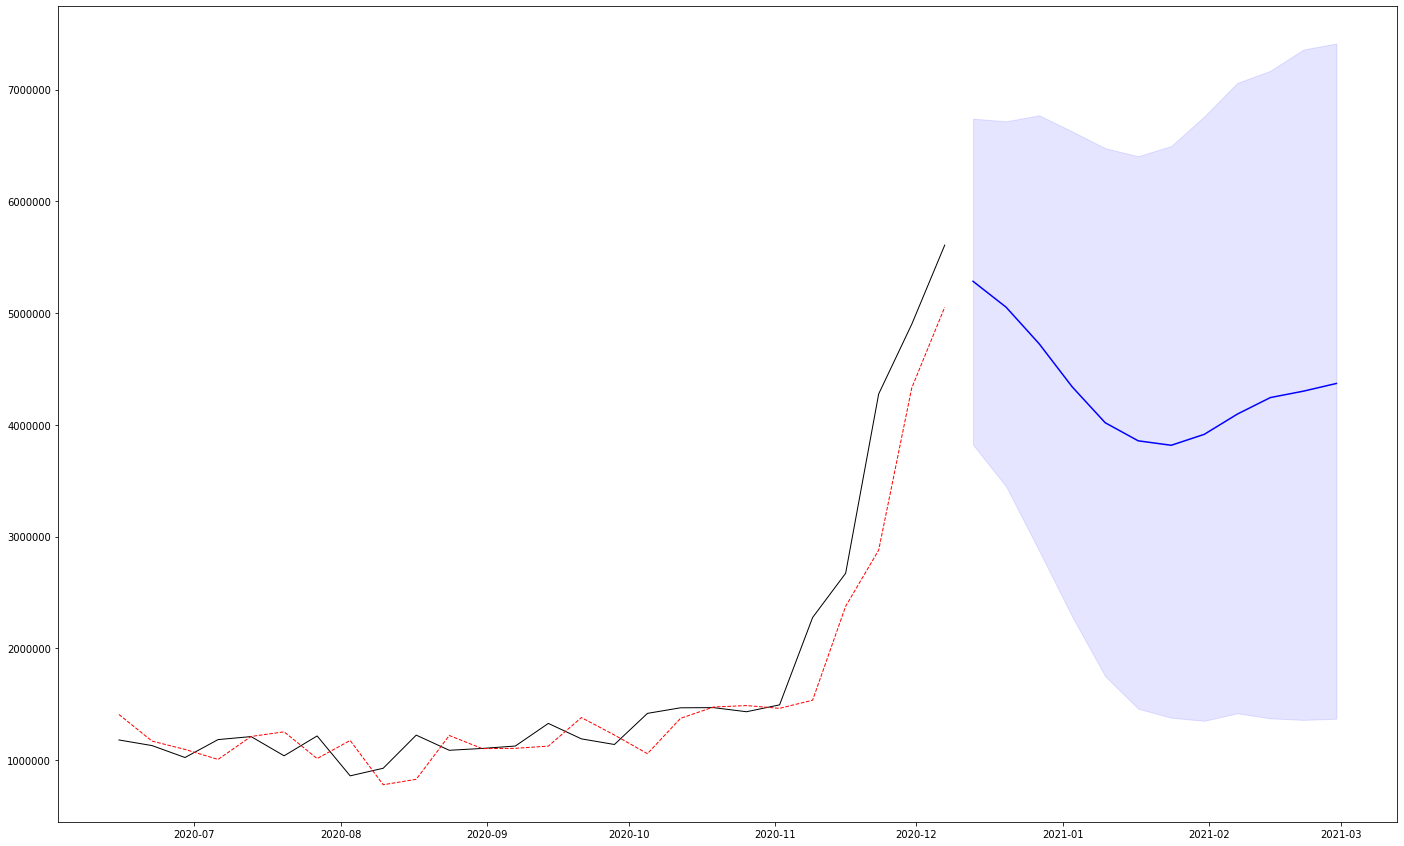

In [332]:
# using Discount to predict Sales
plot, f, mod_sales, y, d = bayes_forecast(y, x1, d, 52, 'normal', 4, .94)
sales_fut, future_dates = future(mod_sales, f, v0, 12, y, d, 26)
#plt.plot(sales_fut)

In [333]:
sales_df = make_forecast_df(d, y, f, sales_fut, future_dates, 104, 'all_products')
sales_df['date'] = pd.to_datetime(sales_df['date'])

In [334]:
v0_df = make_forecast_df(d, y, f, sales_fut, future_dates, 104, 'all_products')

In [321]:
v1_df = make_forecast_df(d, y, f, sales_fut, future_dates, 104, 'all_products')

In [323]:
v2_df = make_forecast_df(d, y, f, sales_fut, future_dates, 104, 'all_products')

In [325]:
v3_df = make_forecast_df(d, y, f, sales_fut, future_dates, 104, 'all_products')

In [327]:
v4_df = make_forecast_df(d, y, f, sales_fut, future_dates, 104, 'all_products')

In [329]:
v5_df = make_forecast_df(d, y, f, sales_fut, future_dates, 104, 'all_products')

In [331]:
v6_df = make_forecast_df(d, y, f, sales_fut, future_dates, 104, 'all_products')

In [335]:
sales_df['forecast_0disc'] = v0_df['forecast']
sales_df['forecast_5disc'] = v1_df['forecast']
sales_df['forecast_10disc'] = v2_df['forecast']
sales_df['forecast_15disc'] = v3_df['forecast']
sales_df['forecast_20disc'] = v4_df['forecast']
sales_df['forecast_25disc'] = v5_df['forecast']
sales_df['forecast_30disc'] = v6_df['forecast']
sales_df

date     actual      predicted      forecast         Group  \
0  2018-12-17  220472.70  592679.883534           NaN  all_products   
1  2018-12-24  186487.21  110732.228638           NaN  all_products   
2  2018-12-31  185210.14  134666.490661           NaN  all_products   
3  2019-01-07  214130.37  174577.765398           NaN  all_products   
4  2019-01-14  258519.37  224954.693183           NaN  all_products   
..        ...        ...            ...           ...           ...   
7  2021-01-31        NaN            NaN  3.915352e+06  all_products   
8  2021-02-07        NaN            NaN  4.096187e+06  all_products   
9  2021-02-14        NaN            NaN  4.244217e+06  all_products   
10 2021-02-21        NaN            NaN  4.301449e+06  all_products   
11 2021-02-28        NaN            NaN  4.370549e+06  all_products   

    forecast_0disc  forecast_5disc  forecast_10disc  forecast_15disc  \
0              NaN             NaN              NaN              NaN   
1              NaN             NaN              NaN              NaN   
2              NaN             NaN              NaN              NaN   
3              NaN             NaN              NaN              NaN   
4              NaN             NaN              NaN              NaN   
..             ...             ...              ...              ...   
7     3.915352e+06    4.119828e+06     4.263739e+06     4.395301e+06   
8     4.096187e+06    4.250683e+06     4.443636e+06     4.567159e+06   
9     4.244217e+06    4.334645e+06     4.596590e+06     4.734288e+06   
10    4.301449e+06    4.409710e+06     4.692303e+06     4.800008e+06   
11    4.370549e+06    4.464318e+06     4.768444e+06     4.831063e+06   

    forecast_20disc  forecast_25disc  forecast_30disc  
0               NaN              NaN              NaN  
1               NaN              NaN              NaN  
2               NaN              NaN              NaN  
3               NaN              NaN              NaN  
4               NaN              NaN              NaN  
..              ...              ...              ...  
7      4.535679e+06     4.751646e+06     4.829615e+06  
8      4.679942e+06     4.885395e+06     4.964380e+06  
9      4.846415e+06     5.010809e+06     5.057330e+06  
10     4.986353e+06     5.132725e+06     5.156995e+06  
11     5.023910e+06     5.235948e+06     5.244197e+06  

[116 rows x 12 columns]

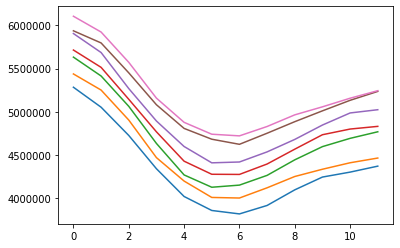

In [337]:
plt.plot(v0_df['forecast'])
plt.plot(v1_df['forecast'])
plt.plot(v2_df['forecast'])
plt.plot(v3_df['forecast'])
plt.plot(v4_df['forecast'])
plt.plot(v5_df['forecast'])
plt.plot(v6_df['forecast'])

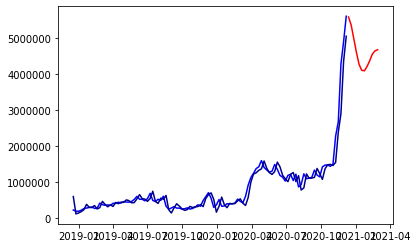

In [320]:
plt.plot(sales_df.date, sales_df.actual, color='blue')
plt.plot(sales_df.date, sales_df.predicted, color='darkblue')
plt.plot(sales_df.date, sales_df.forecast, color='red')

In [338]:
# Send Sales Forecast to Database
send_data(sales_df, 'sales_forecast_history')

sales_forecast_history updated!


In [297]:
# Send Orders Forecast to Database
send_data(orders_df, 'order_forecast_history')

order_forecast_history updated!


# Orders Forecast Model Product Level

In [135]:
df_f_prod = pd.read_sql(sql_forecast_product, con)

WEEK_DATE PRODUCT_TYPE  AVG_DISC    A_PRICE     PDISC  TOTAL_GROSS_MARGIN  \
1  2019-06-10  Boardshorts  4.373684  60.631579  0.072135           1068.9000   
2  2019-06-17  Boardshorts  4.937073  64.443089  0.076611          44169.4400   
3  2019-06-24  Boardshorts  4.989723  64.120666  0.077818          42873.6987   
4  2019-07-01  Boardshorts  4.375404  61.533333  0.071106          40488.3400   
5  2019-07-08  Boardshorts  4.155826  56.344994  0.073757          43556.9743   

   TOTAL_UNITS  TOTAL_ORDERS  
1           19            19  
2          742           738  
3          724           721  
4          708           705  
5          834           829

In [232]:
df_f_prod = df_f_prod.groupby('PRODUCT_TYPE').filter(lambda x: len(x) > 52)
df_f_prod

WEEK_DATE PRODUCT_TYPE  AVG_DISC    A_PRICE     PDISC  \
1     2019-06-10  Boardshorts  4.373684  60.631579  0.072135   
2     2019-06-17  Boardshorts  4.937073  64.443089  0.076611   
3     2019-06-24  Boardshorts  4.989723  64.120666  0.077818   
4     2019-07-01  Boardshorts  4.375404  61.533333  0.071106   
5     2019-07-08  Boardshorts  4.155826  56.344994  0.073757   
...          ...          ...       ...        ...       ...   
1039  2020-11-16         Tops  9.118650  59.520430  0.153202   
1040  2020-11-23         Tops  7.341881  58.091032  0.126386   
1041  2020-11-30         Tops  7.747221  58.316203  0.132849   
1042  2020-12-07         Tops  7.568642  58.104047  0.130260   
1043  2020-12-14         Tops  7.223485  56.188980  0.128557   

      TOTAL_GROSS_MARGIN  TOTAL_UNITS  TOTAL_ORDERS  
1              1068.9000           19            19  
2             44169.4400          742           738  
3             42873.6987          724           721  
4             40488.3400          708           705  
5             43556.9743          834           829  
...                  ...          ...           ...  
1039         315107.8674         9724          9398  
1040         511352.4427        14421         14061  
1041         549809.4670        15105         14769  
1042         587350.7811        16114         15791  
1043         151686.6104         4226          4138  

[959 rows x 8 columns]

In [233]:
df_f_prod.groupby('PRODUCT_TYPE')['PRODUCT_TYPE'].count()

PRODUCT_TYPE
Boardshorts            80
Bra                    79
Graphic Tees           80
Headwear               80
Jackets & Hoodies      80
Joggers                80
Jumpsuits & Dresses    79
Leggings               80
Pants                  80
Shorts                 80
Tanks                  81
Tops                   80
Name: PRODUCT_TYPE, dtype: int64

In [234]:
# For Forecasting Sales
y_p = df_f_prod.TOTAL_GROSS_MARGIN.values
x_p = df_f_prod.TOTAL_ORDERS.values
x1_p = df_f_prod.PDISC.values
d_p = df_f_prod.WEEK_DATE
print(len(d_p))

959


In [190]:
y1 = pd.DataFrame(np.concatenate(y, axis=0 ))
forecast1 = pd.DataFrame(np.concatenate(forecast, axis=0 ))
f_date1 = pd.DataFrame(np.concatenate(f_date, axis=0 ))


In [198]:
y2 = pd.concat([y1, forecast1, f_date1], axis = 1)
y2['product'] = df_f_prod['PRODUCT_TYPE']
y2.columns = ['actual', 'forecast', 'date', 'product_type']
y2

actual  forecast        date product_type
0         19       0.0  2019-06-10          NaN
1        738       0.0  2019-06-17  Boardshorts
2        721       0.0  2019-06-24  Boardshorts
3        705       0.0  2019-07-01  Boardshorts
4        829       0.0  2019-07-08  Boardshorts
...      ...       ...         ...          ...
1052      18      43.0  2020-11-16        Water
1053      59      23.0  2020-11-23        Water
1054      23     262.0  2020-11-30        Water
1055      28       7.0  2020-12-07        Water
1056       4      12.0  2020-12-14        Water

[1057 rows x 4 columns]

In [ ]:
tf = pd.DataFrame({'labels': filename , 'numbers': numbers})

In [214]:
def make_forecast_df(date, actual, forecast, future, future_dates, lb, product_name):
    xdf_sales = pd.DataFrame(date[-lb:]).reset_index(drop=True)
    ydf_sales = pd.DataFrame(actual[-lb:]).reset_index(drop=True)
    fdf_sales = pd.DataFrame(forecast[-lb:]).reset_index(drop=True)
    f_sales_df = pd.concat([xdf_sales, ydf_sales, fdf_sales,], axis=1)
    f_sales_df.columns=['date', 'actual', 'predicted']
    x_fut = pd.DataFrame(future_dates).reset_index(drop=True)
    y_fut = pd.DataFrame(future).reset_index(drop=True)
    fut_df = pd.concat([x_fut, y_fut], axis=1)
    fut_df.columns=['date', 'forecast']
    sales_df = pd.concat([f_sales_df, fut_df], axis=0)
    sales_df = sales_df.assign(Group=product_name)
    return sales_df

In [212]:
all_dfs

[                   date  actual  predicted  forecast
 0            2019-06-10    19.0        0.0       NaN
 1            2019-06-17   738.0        0.0       NaN
 2            2019-06-24   721.0        0.0       NaN
 3            2019-07-01   705.0        0.0       NaN
 4            2019-07-08   829.0        0.0       NaN
 ..                  ...     ...        ...       ...
 7   2021-02-07 00:00:00     NaN        NaN     419.0
 8   2021-02-14 00:00:00     NaN        NaN     491.5
 9   2021-02-21 00:00:00     NaN        NaN     359.0
 10  2021-02-28 00:00:00     NaN        NaN     210.5
 11  2021-03-07 00:00:00     NaN        NaN     128.0
 
 [92 rows x 4 columns],                    date  actual  predicted  forecast
 0            2019-06-17    12.0        0.0       NaN
 1            2019-06-24    13.0        0.0       NaN
 2            2019-07-01    23.0        0.0       NaN
 3            2019-07-08    30.0        0.0       NaN
 4            2019-07-15    21.0        0.0       NaN
 ..

In [230]:
a1 = pd.concat(all_dfs)
a1['date'] = pd.to_datetime(a1['date'])
a1.columns = ['date', 'actual', 'predicted', 'forecast', 'product_type']
a1.columns = a1.columns.str.lower()
a1

date  actual  predicted  forecast product_type
0  2019-06-10    19.0        0.0       NaN  Boardshorts
1  2019-06-17   738.0        0.0       NaN  Boardshorts
2  2019-06-24   721.0        0.0       NaN  Boardshorts
3  2019-07-01   705.0        0.0       NaN  Boardshorts
4  2019-07-08   829.0        0.0       NaN  Boardshorts
..        ...     ...        ...       ...          ...
7  2021-02-07     NaN        NaN      63.5        Water
8  2021-02-14     NaN        NaN      14.0        Water
9  2021-02-21     NaN        NaN       4.0        Water
10 2021-02-28     NaN        NaN       4.0        Water
11 2021-03-07     NaN        NaN       8.0        Water

[1237 rows x 5 columns]

In [231]:
send_data(a1, 'product_forecast_history')

product_forecast_history updated!


178.4837
121.7657
94.2637
150.0277
134.6931
103.6947
339.0532
115.3506
127.0563
58.6193
71.1679


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until ex

67.9629


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


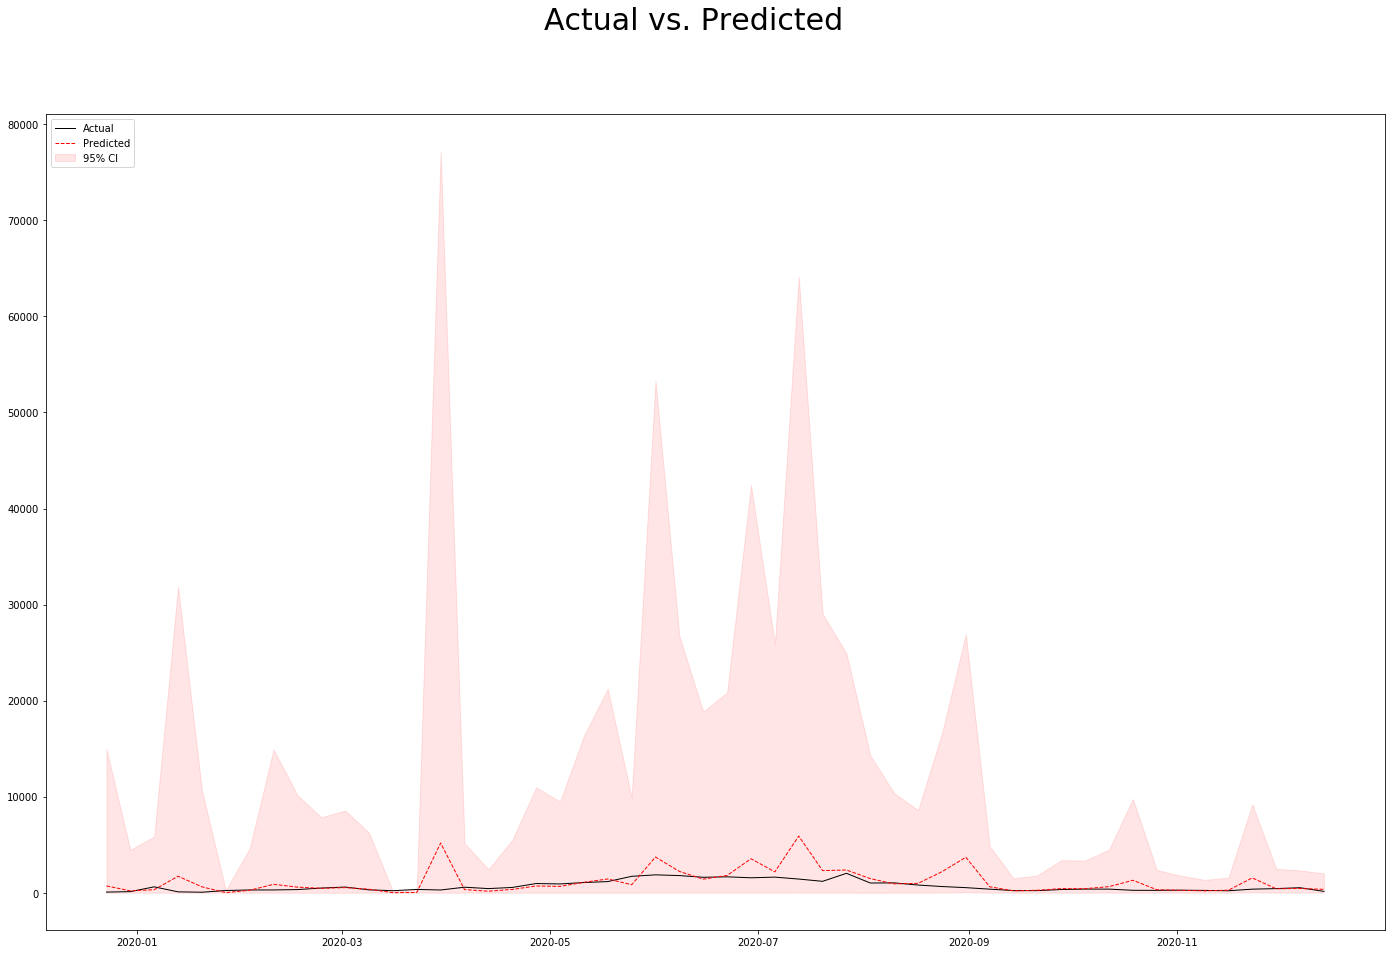

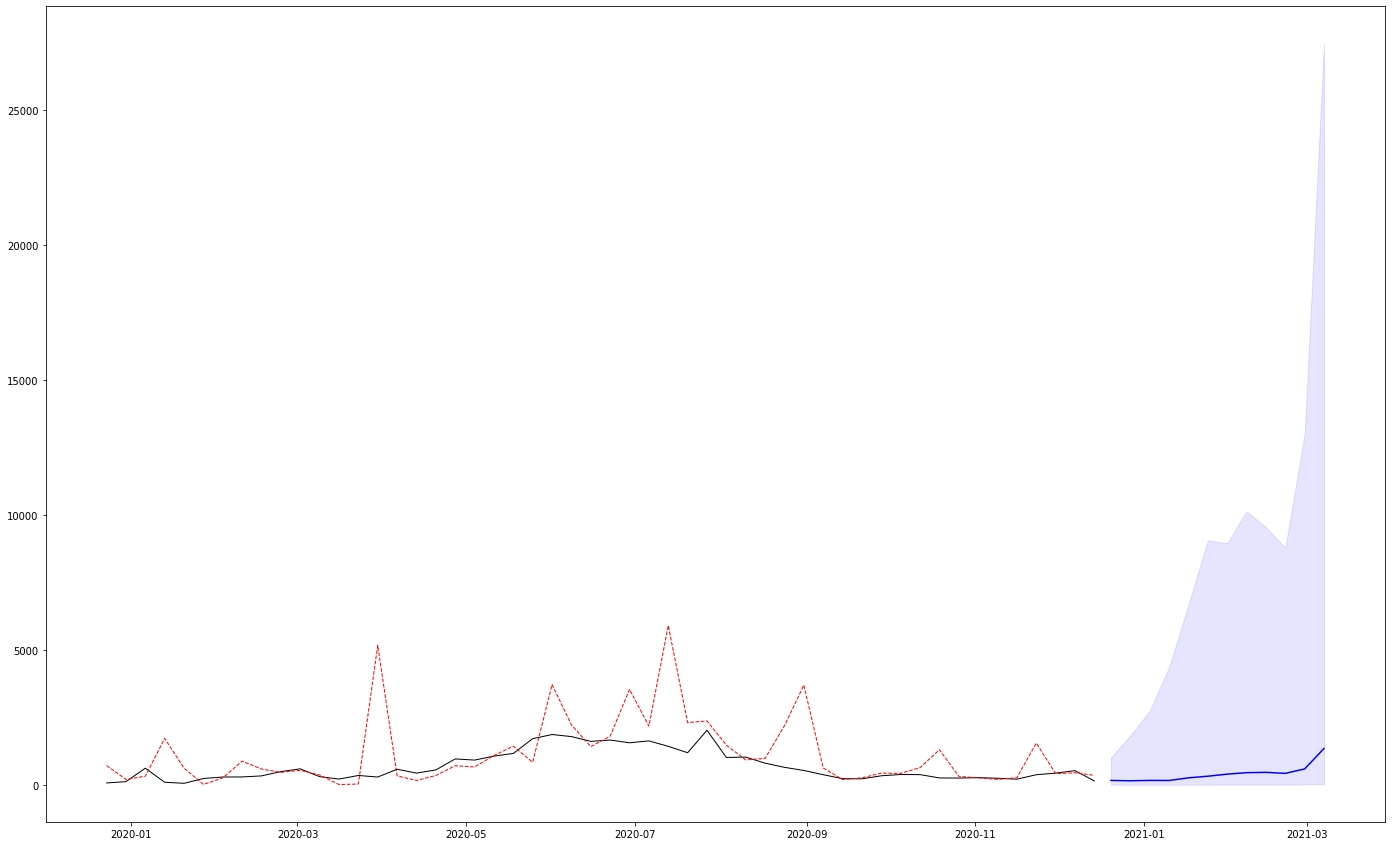

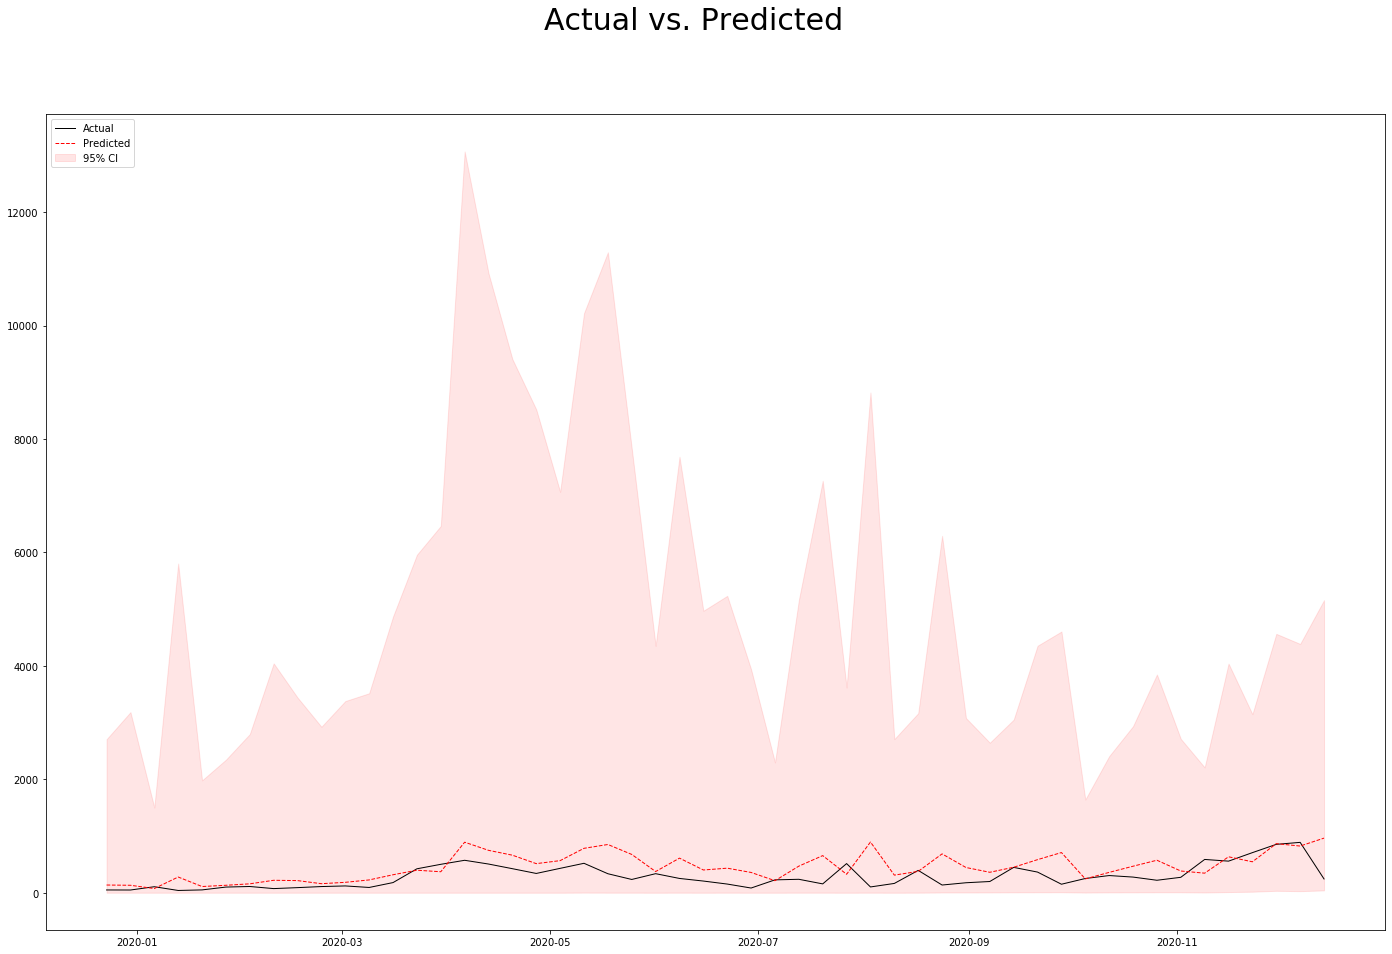

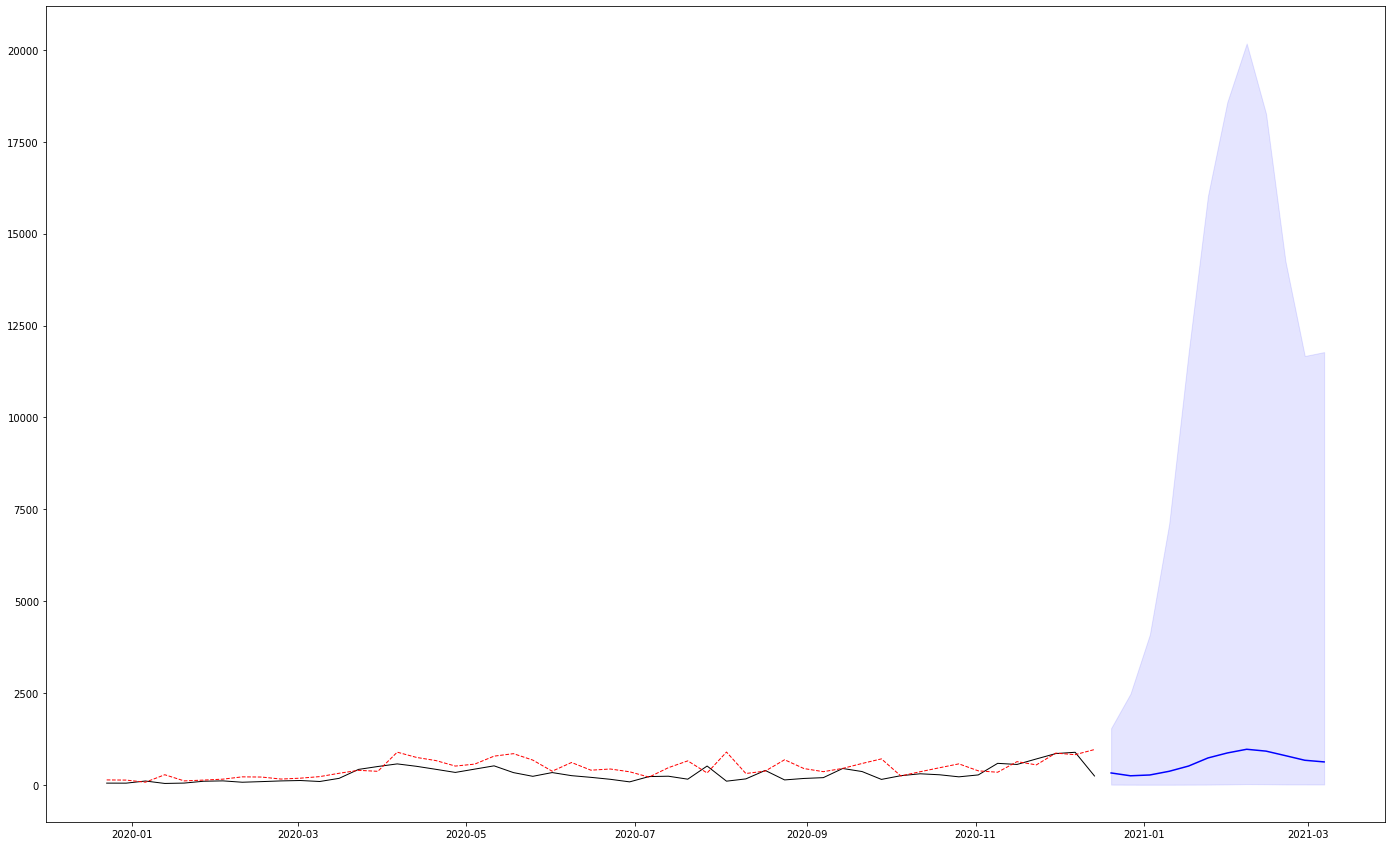

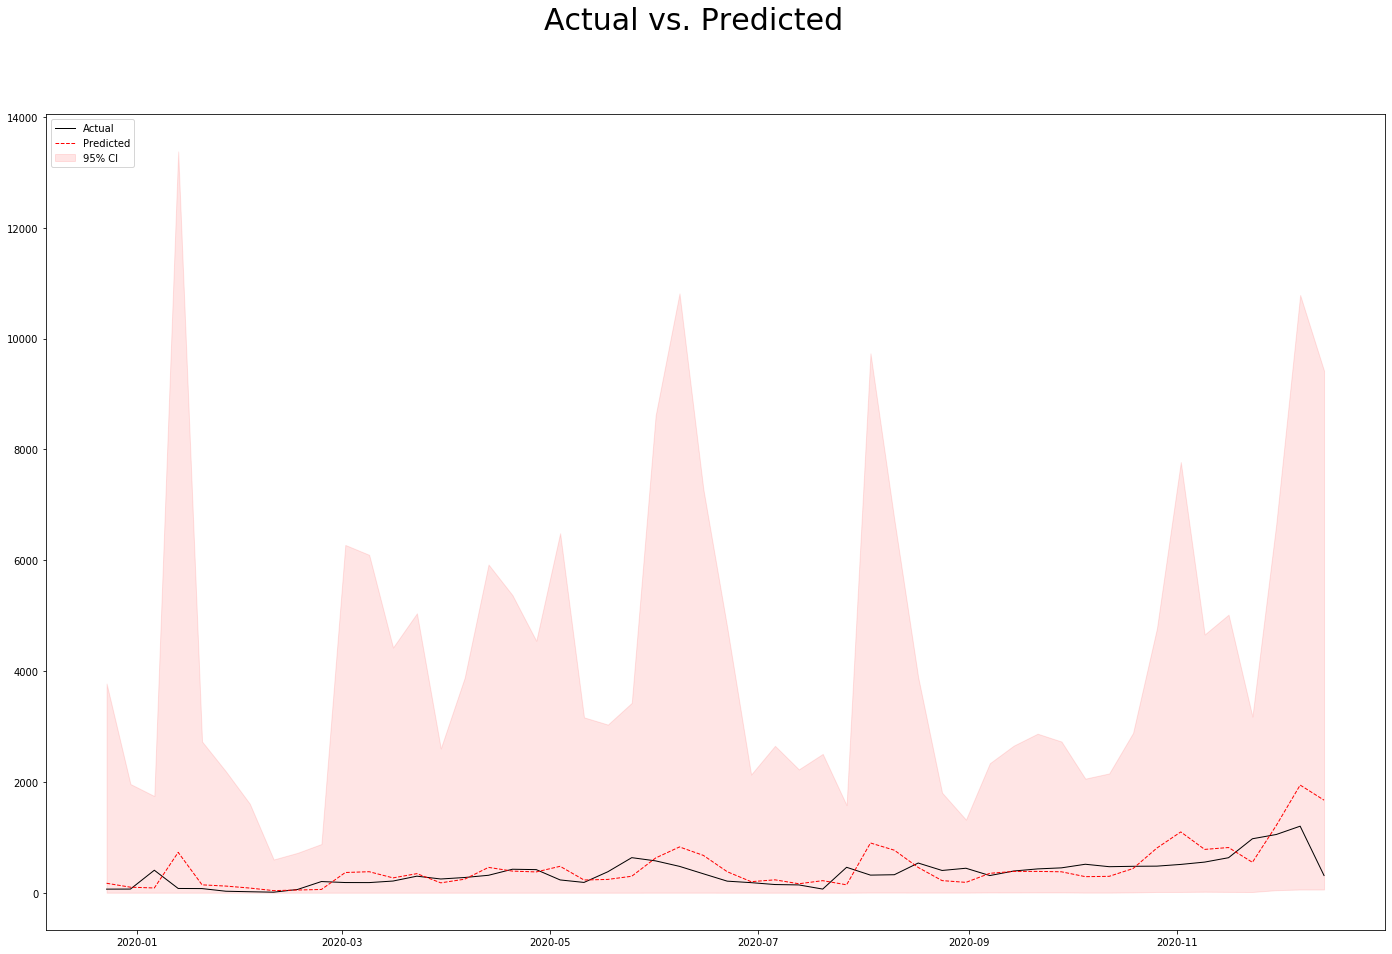

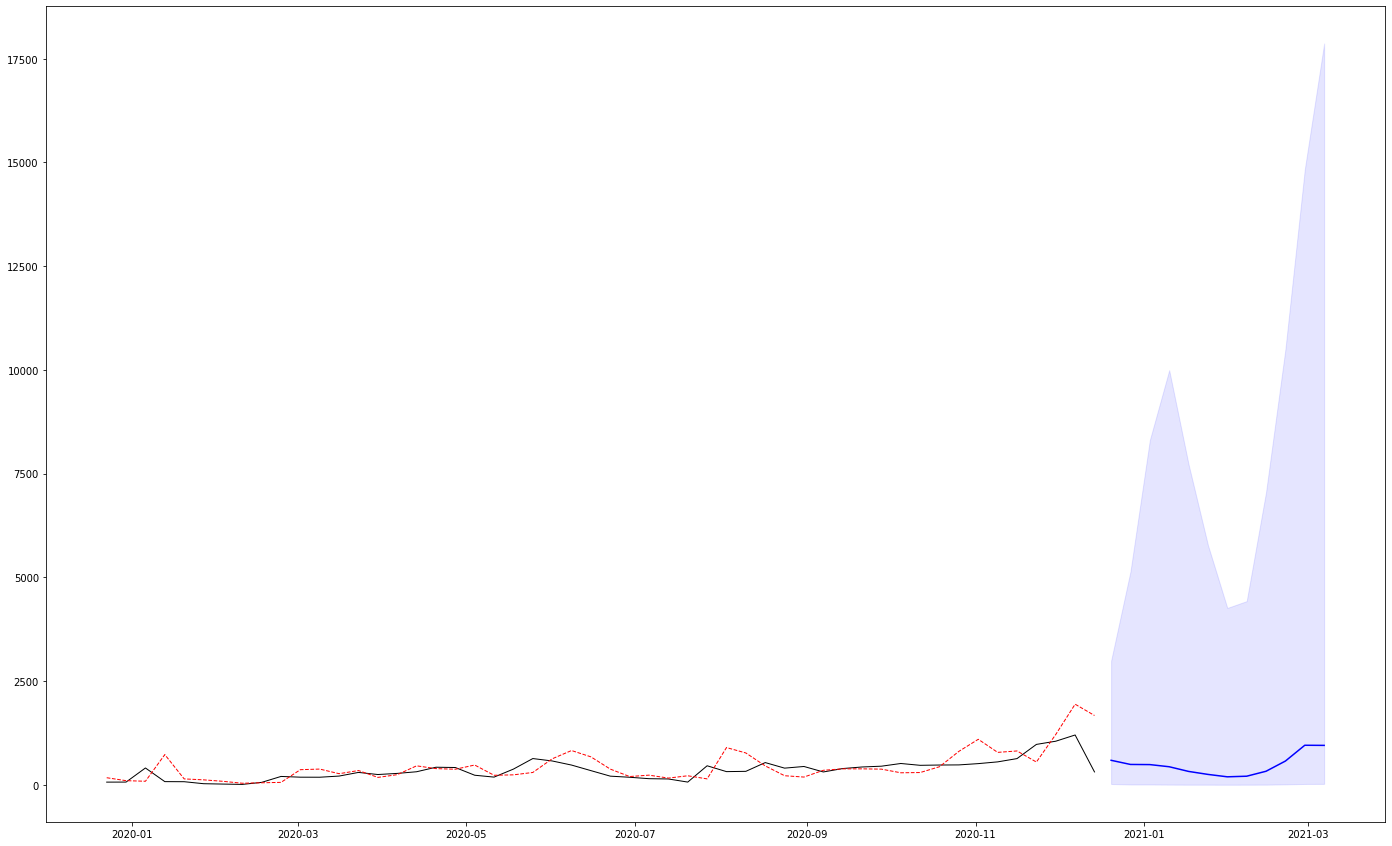

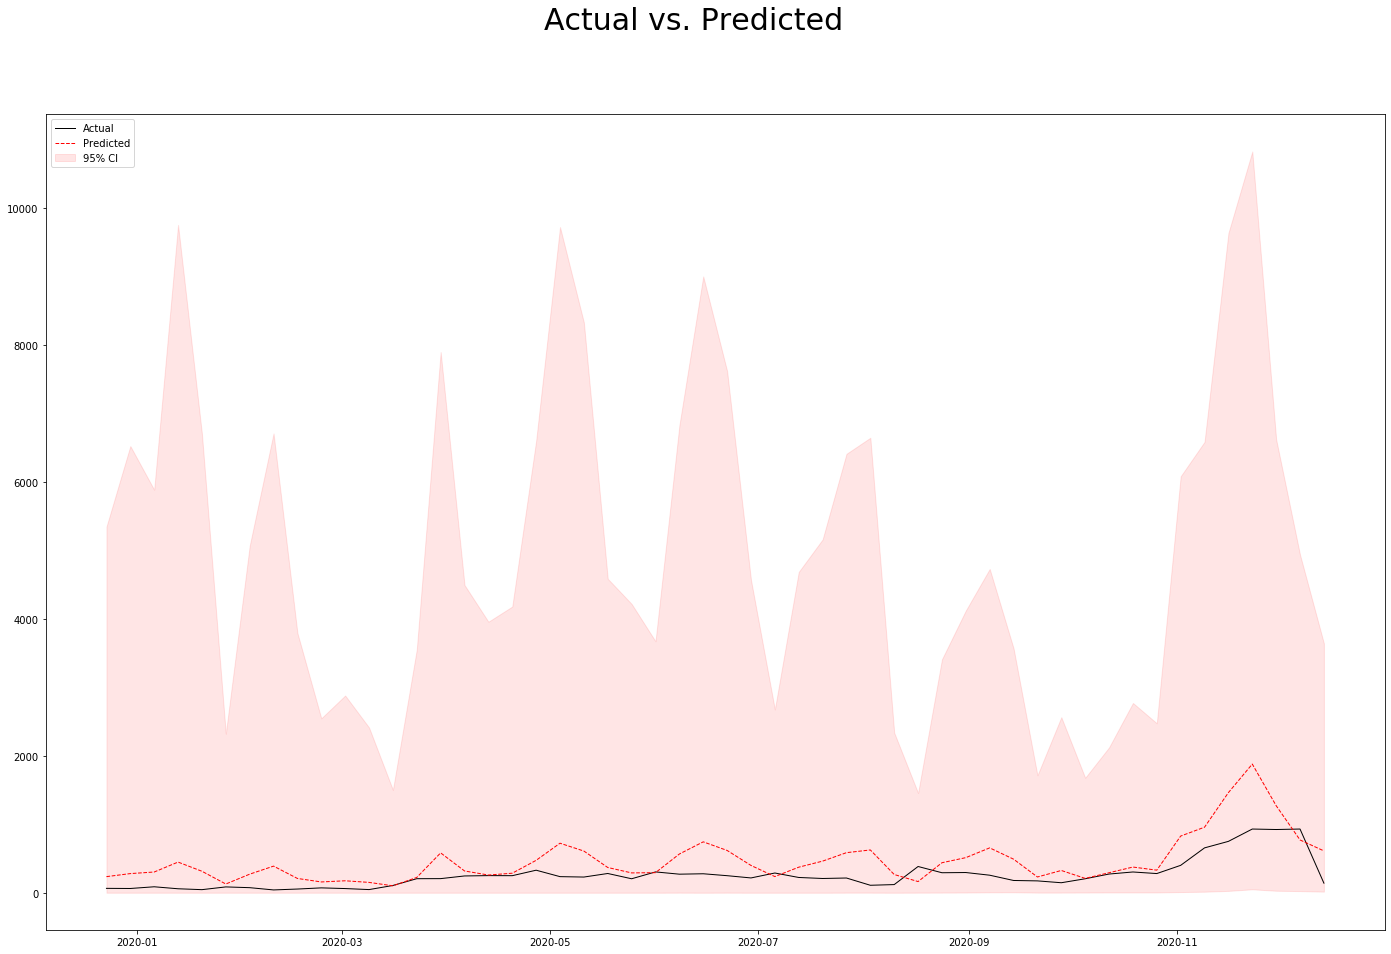

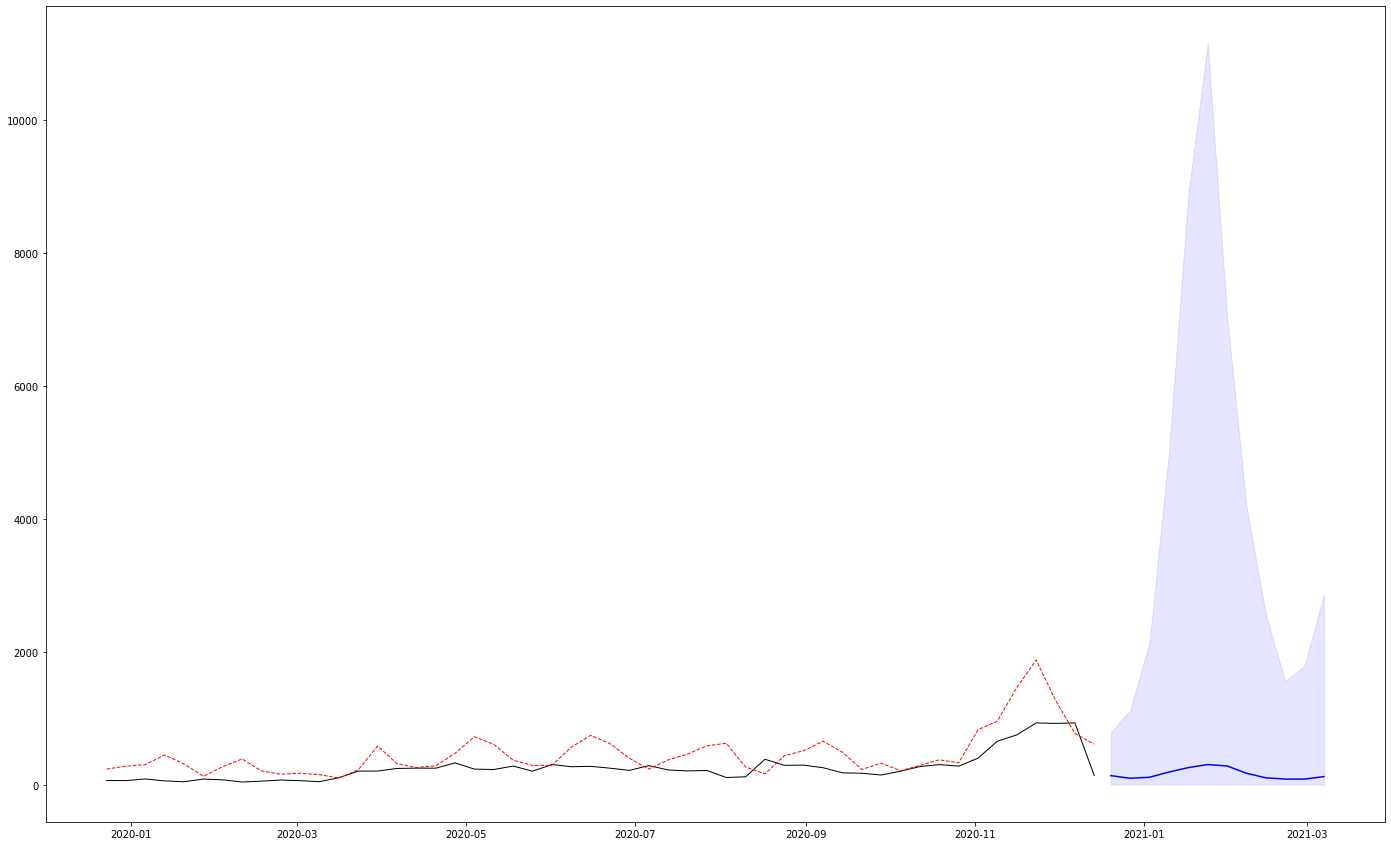

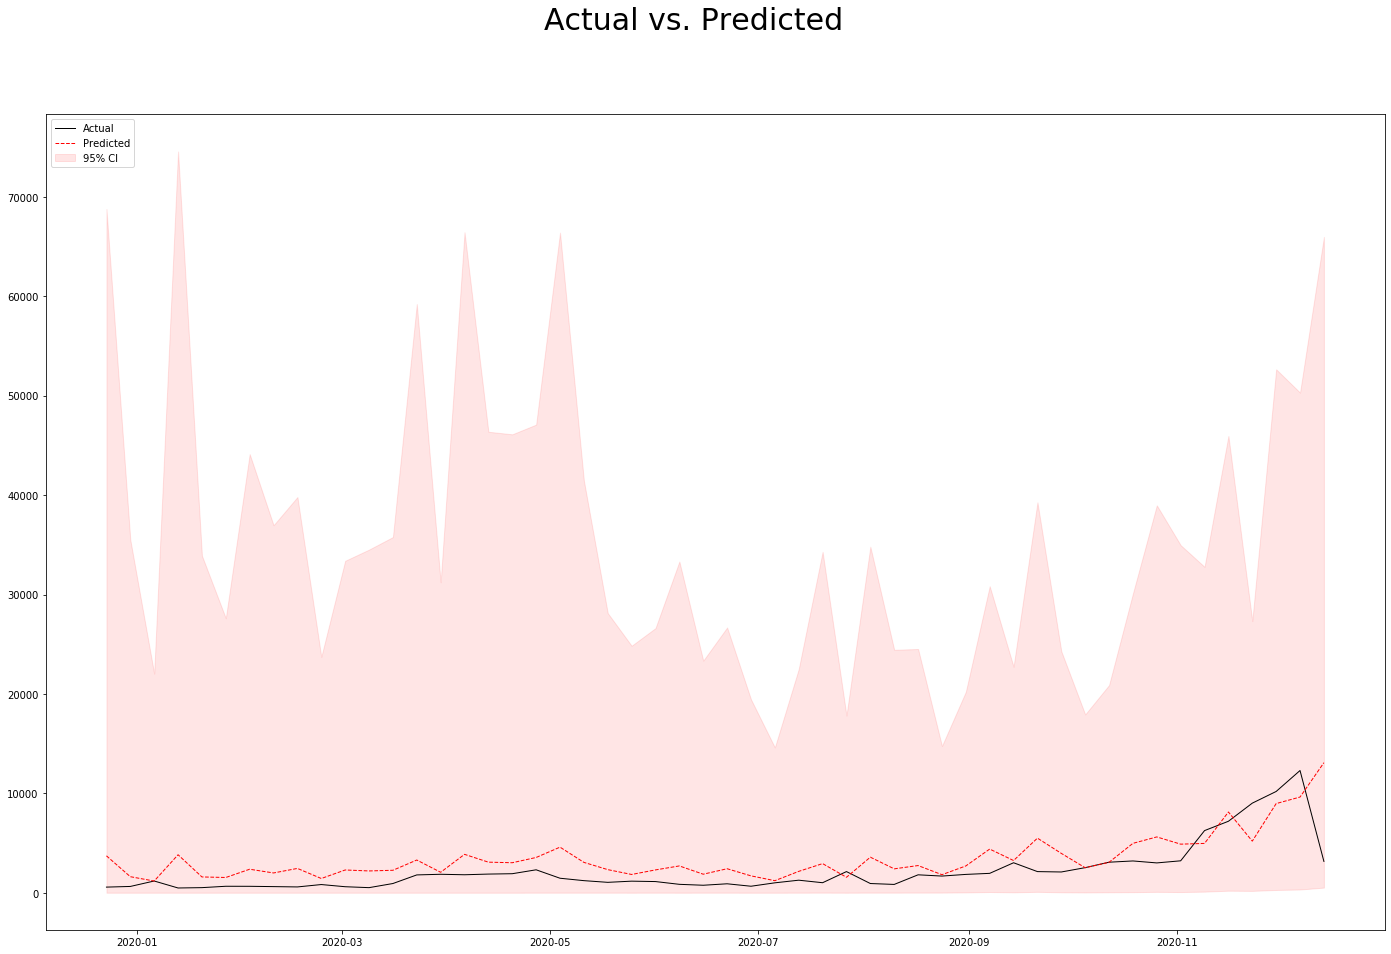

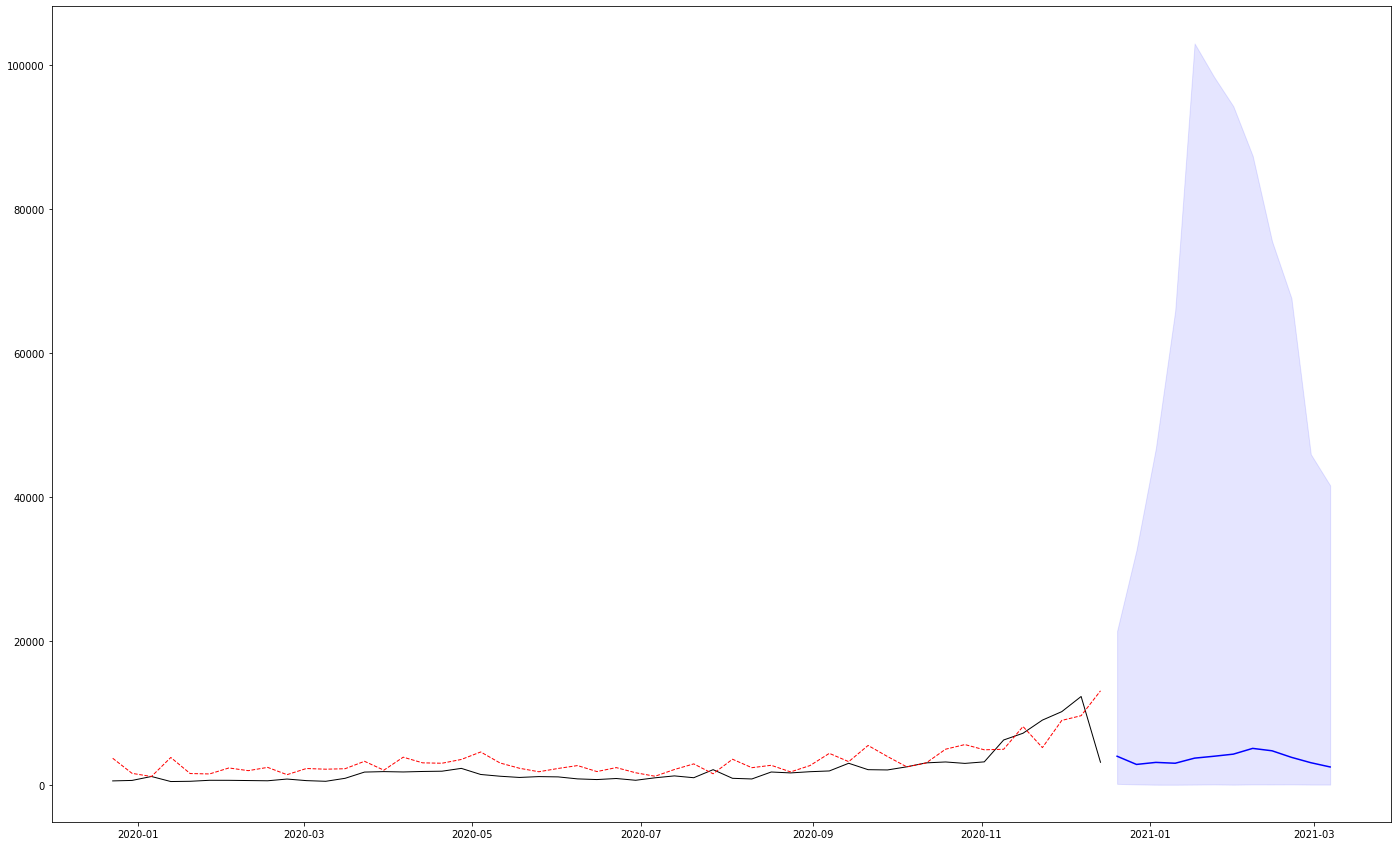

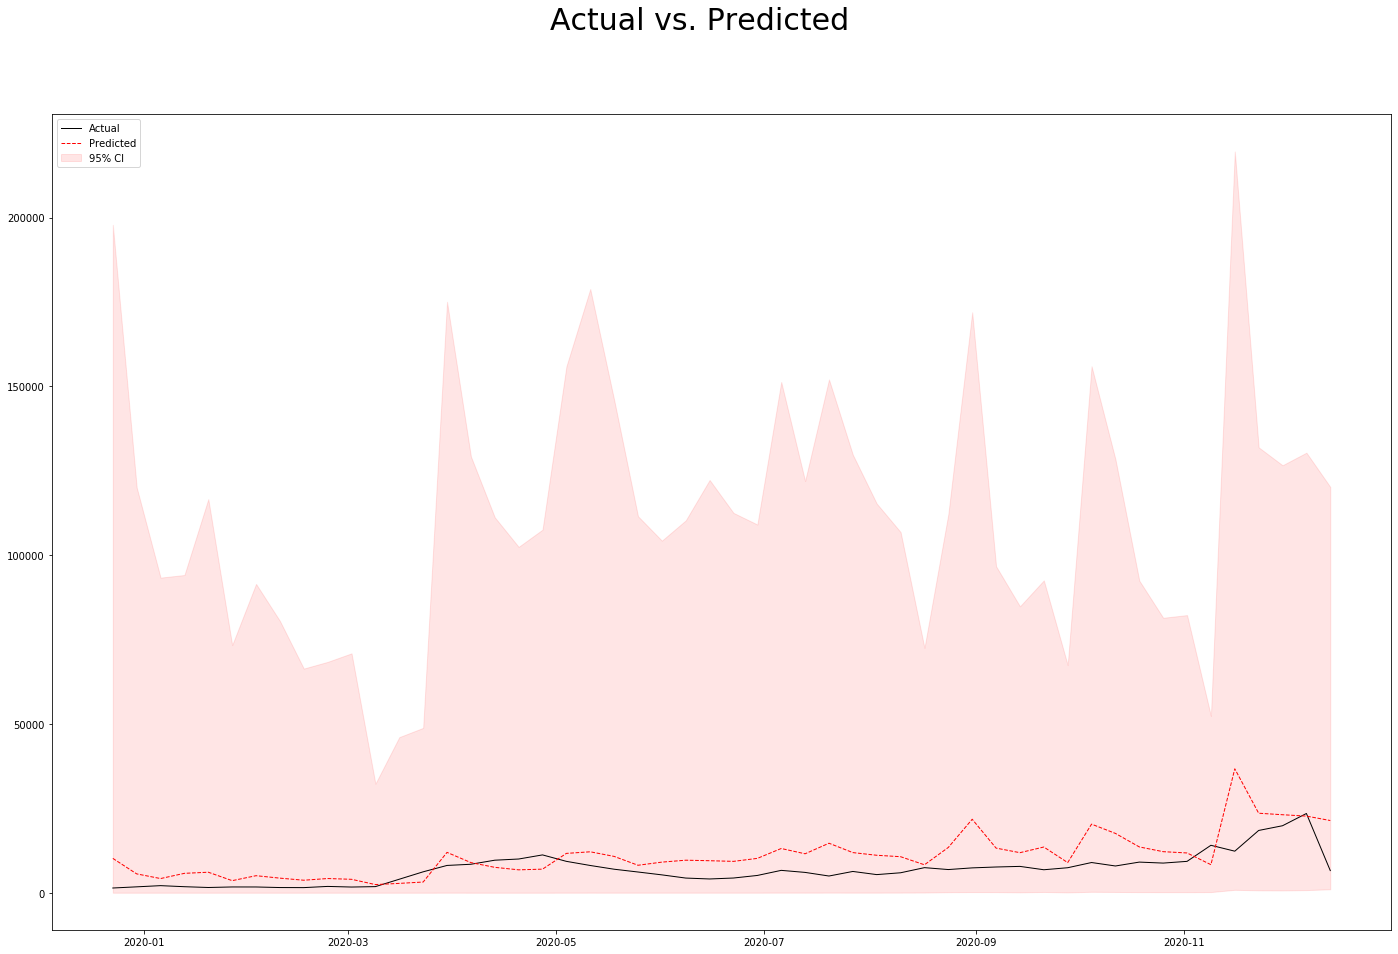

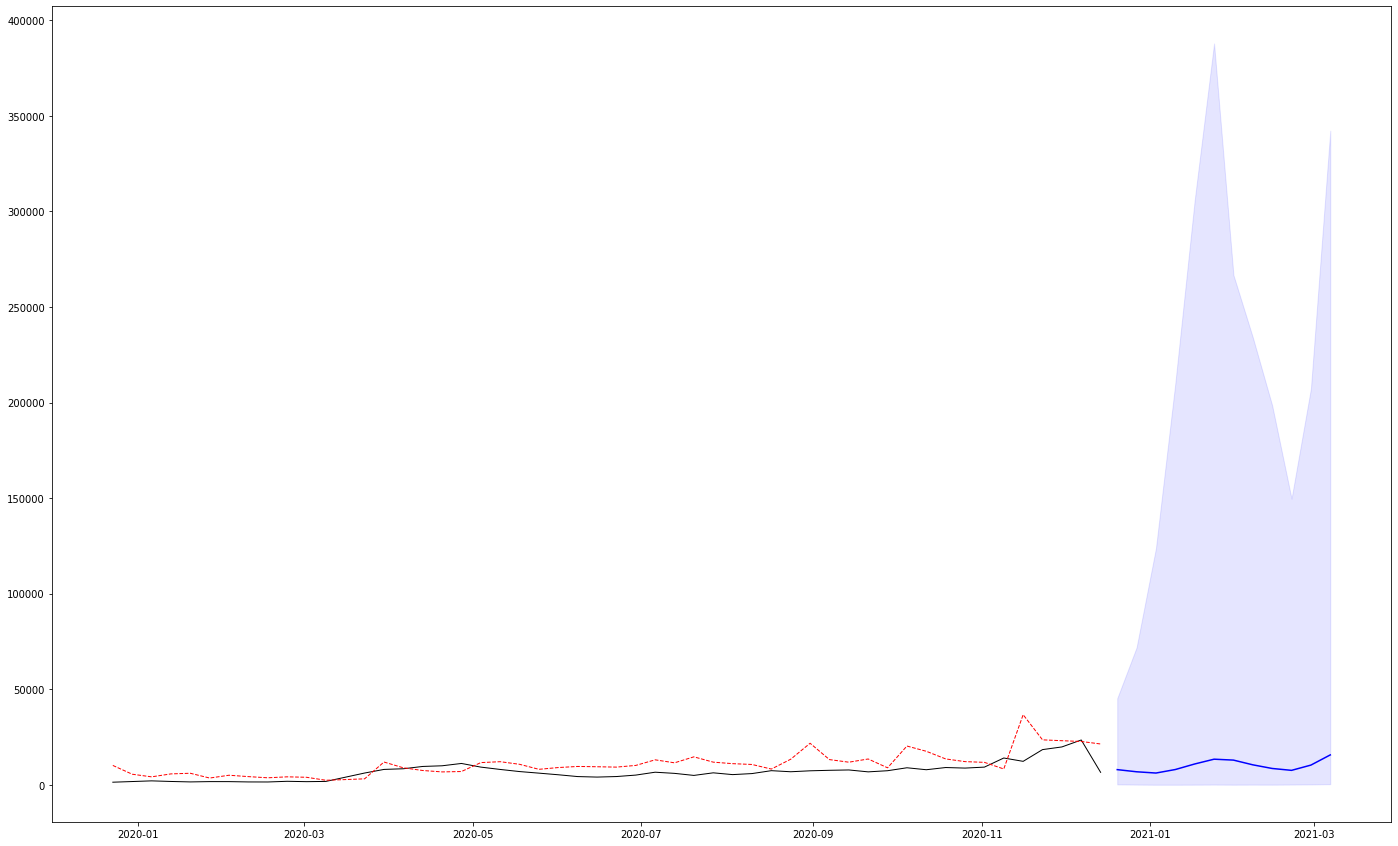

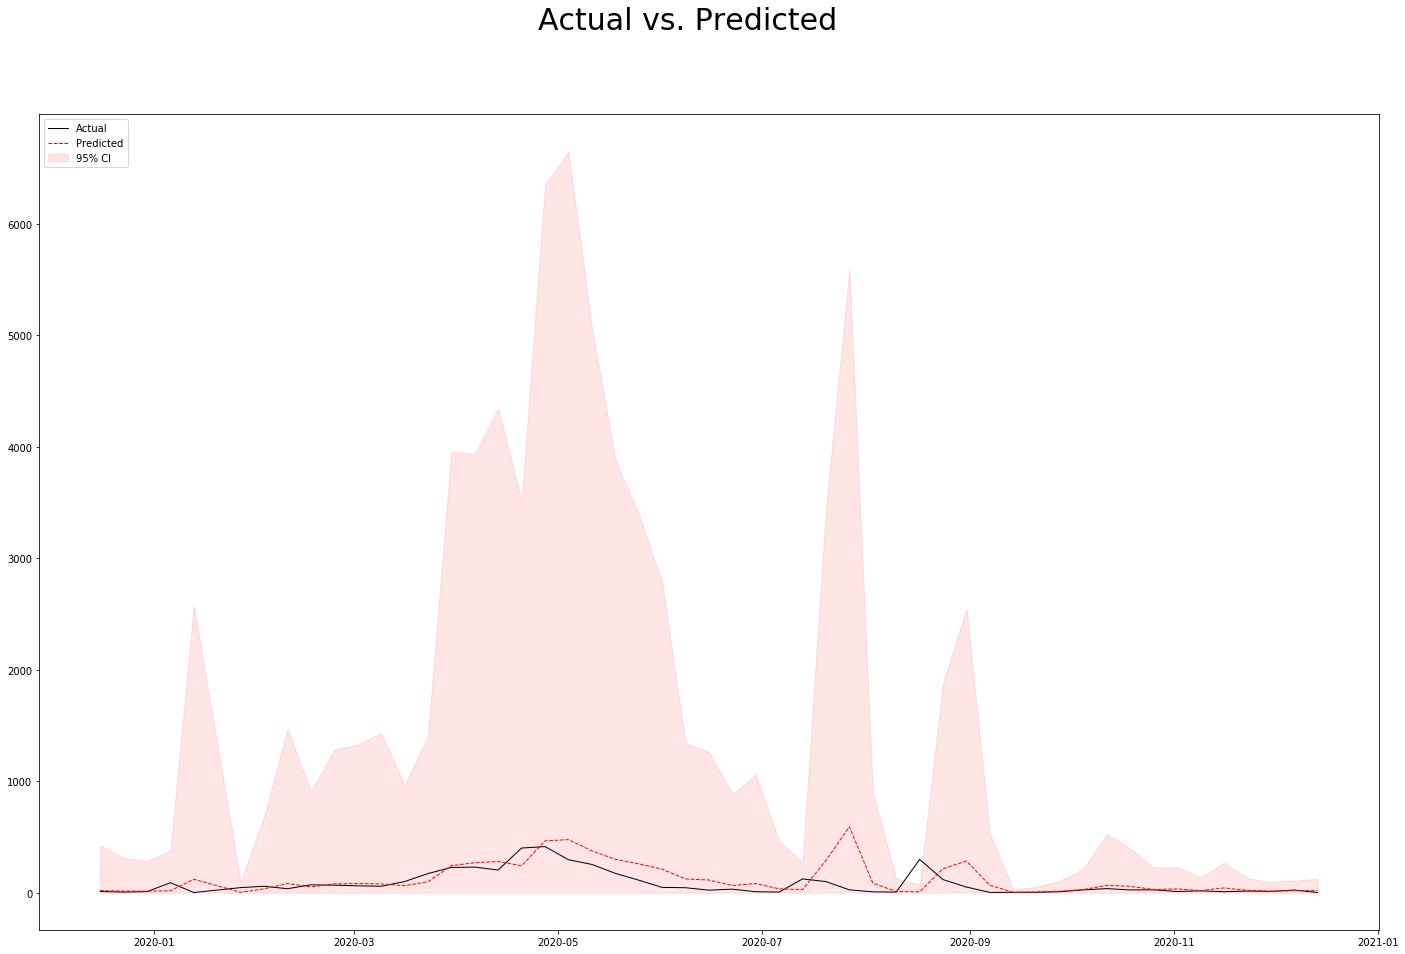

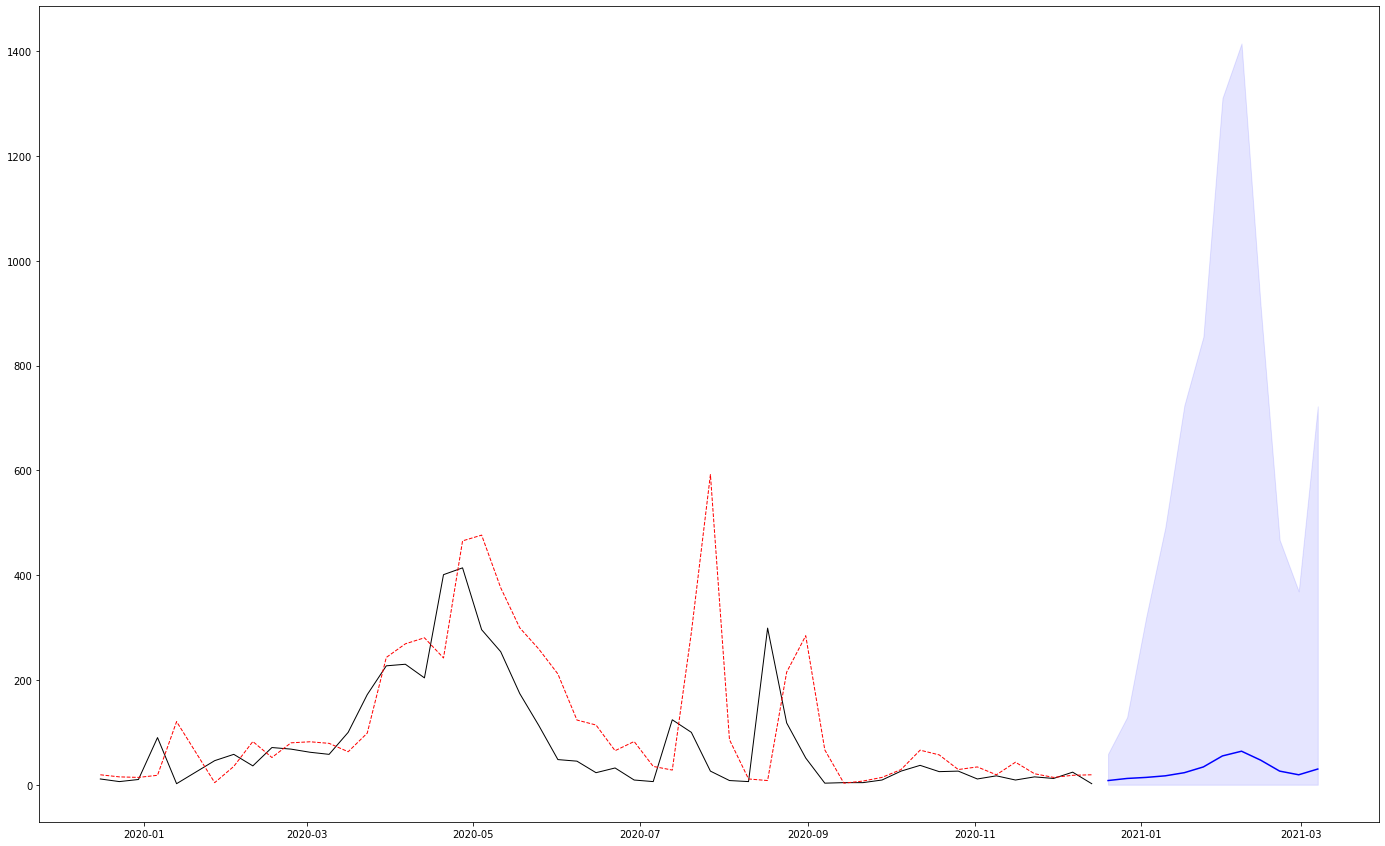

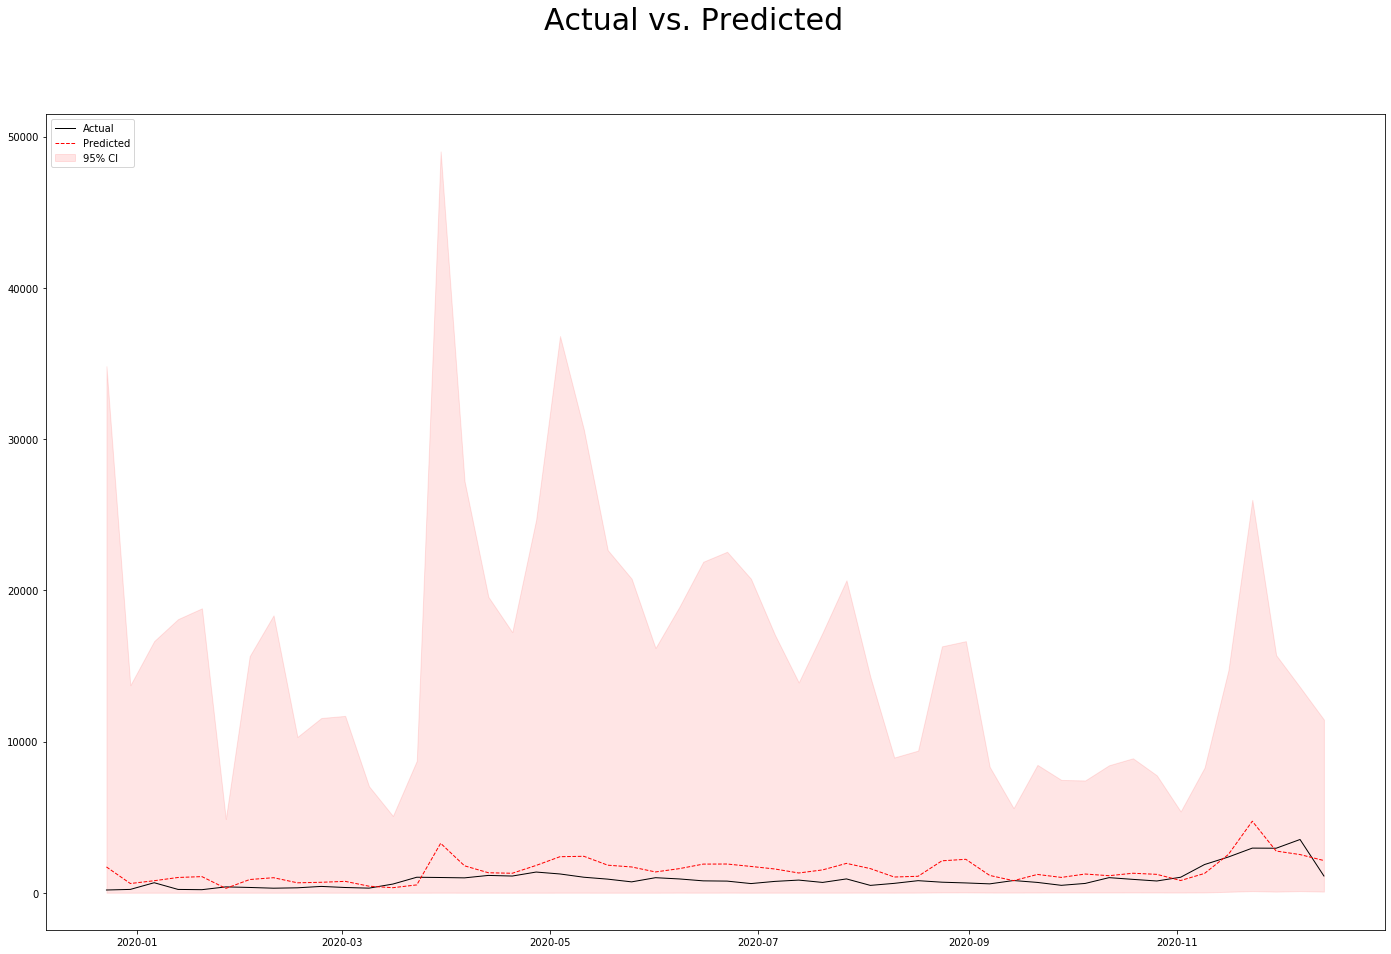

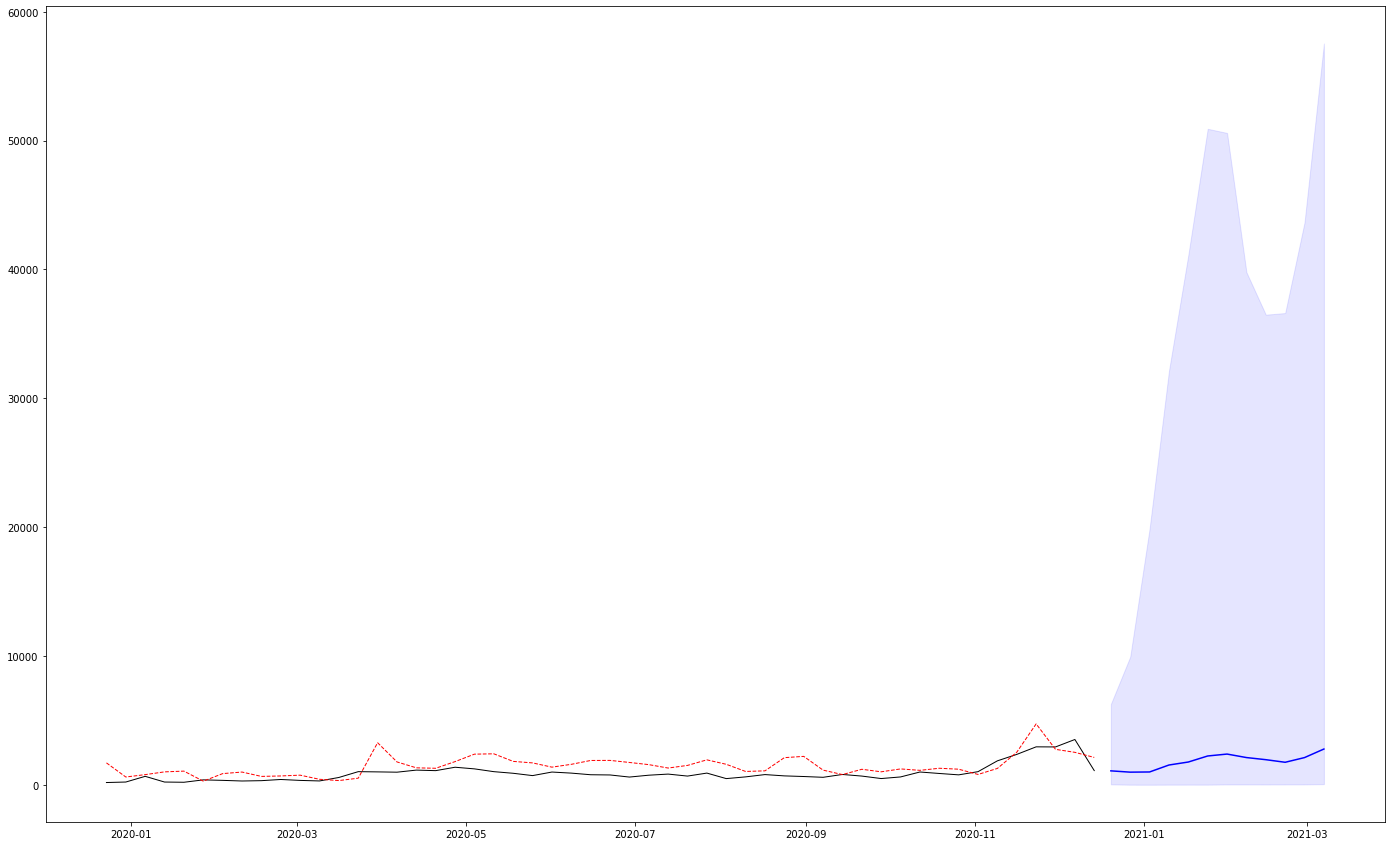

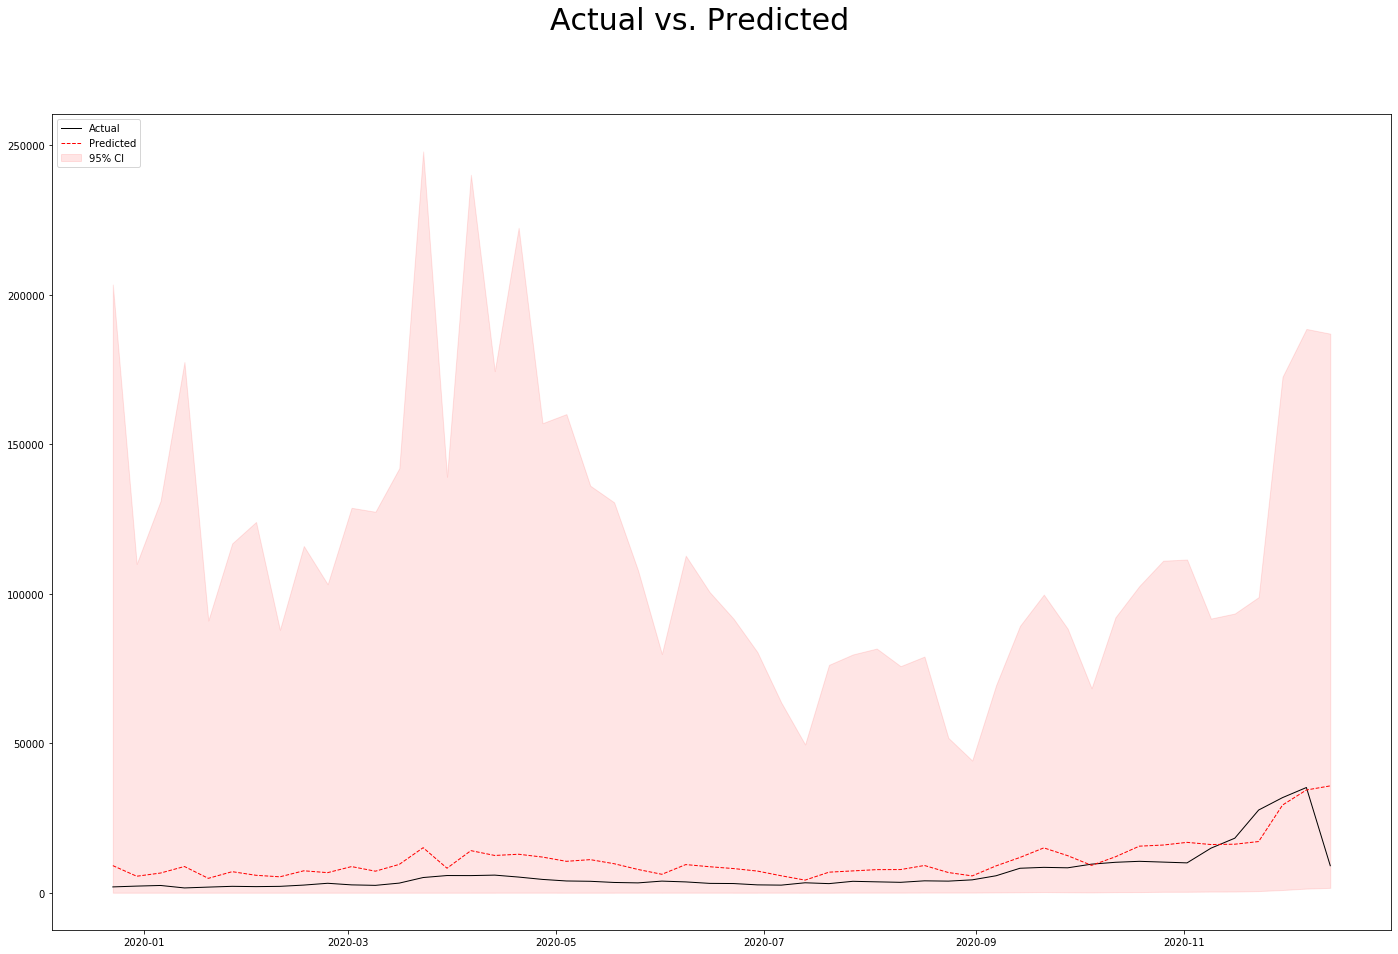

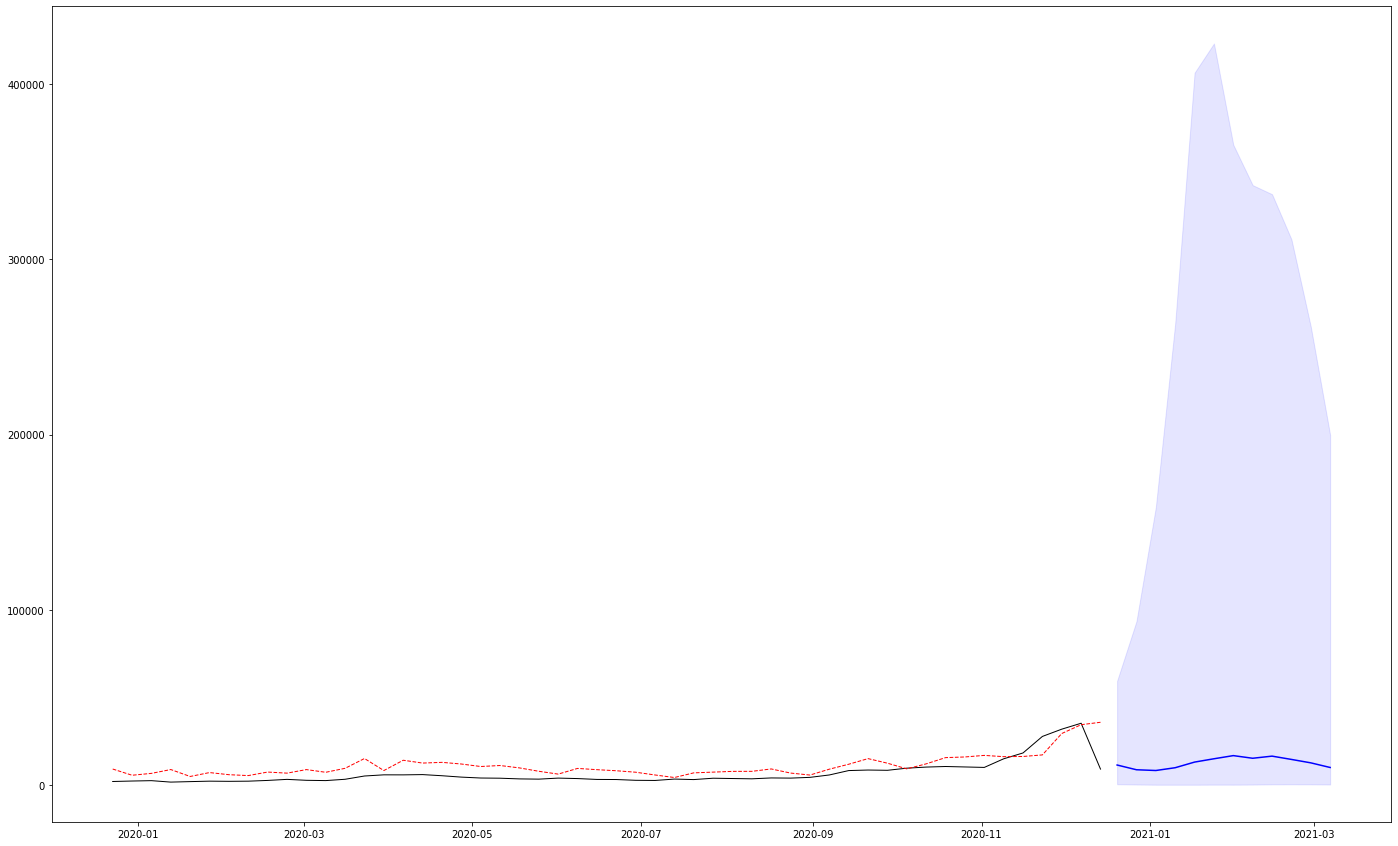

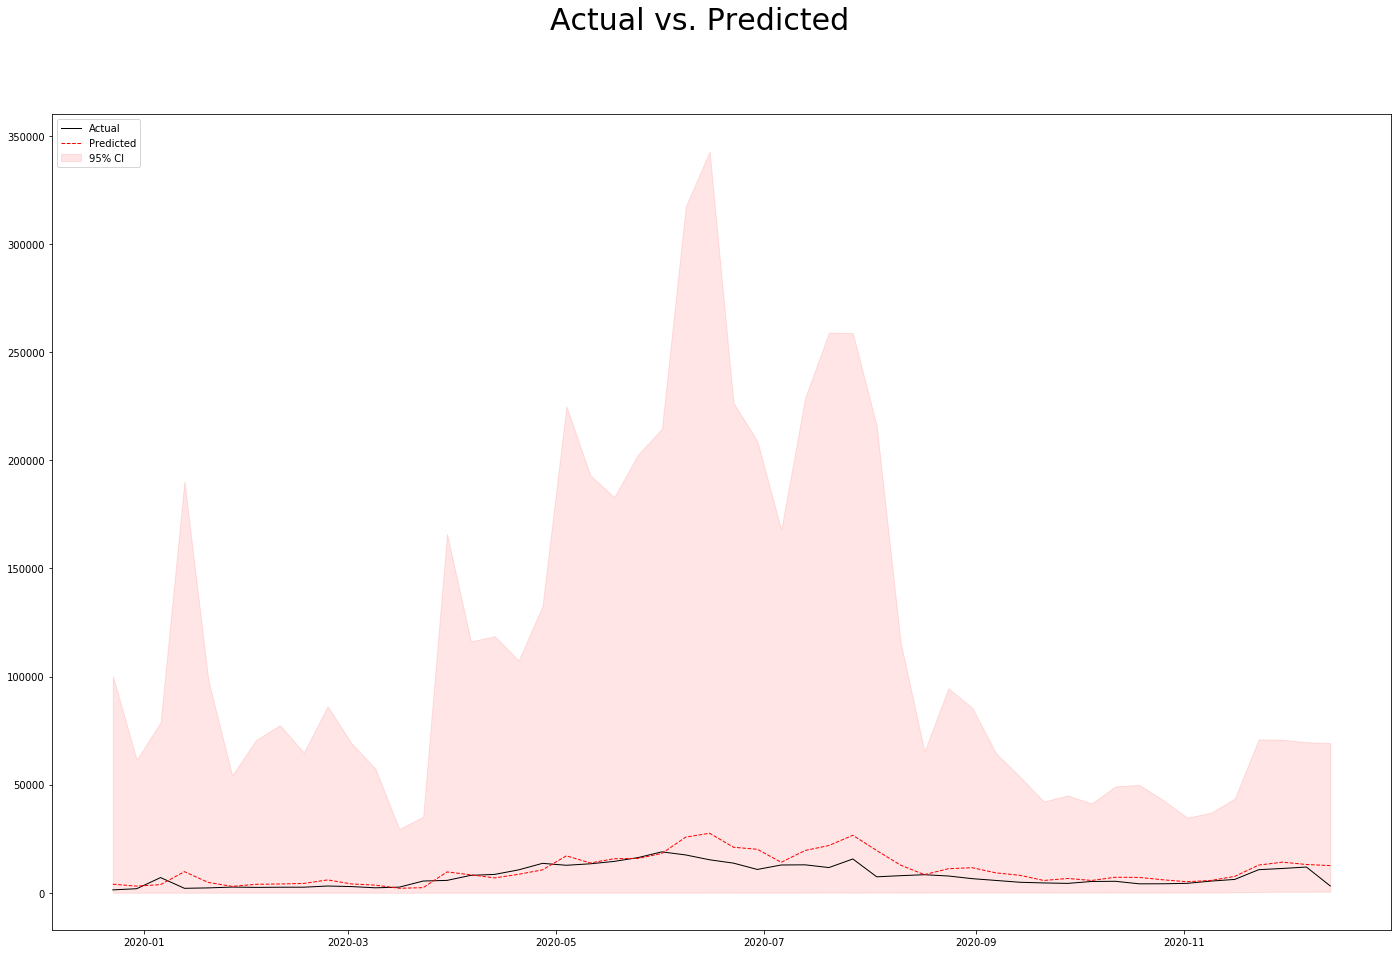

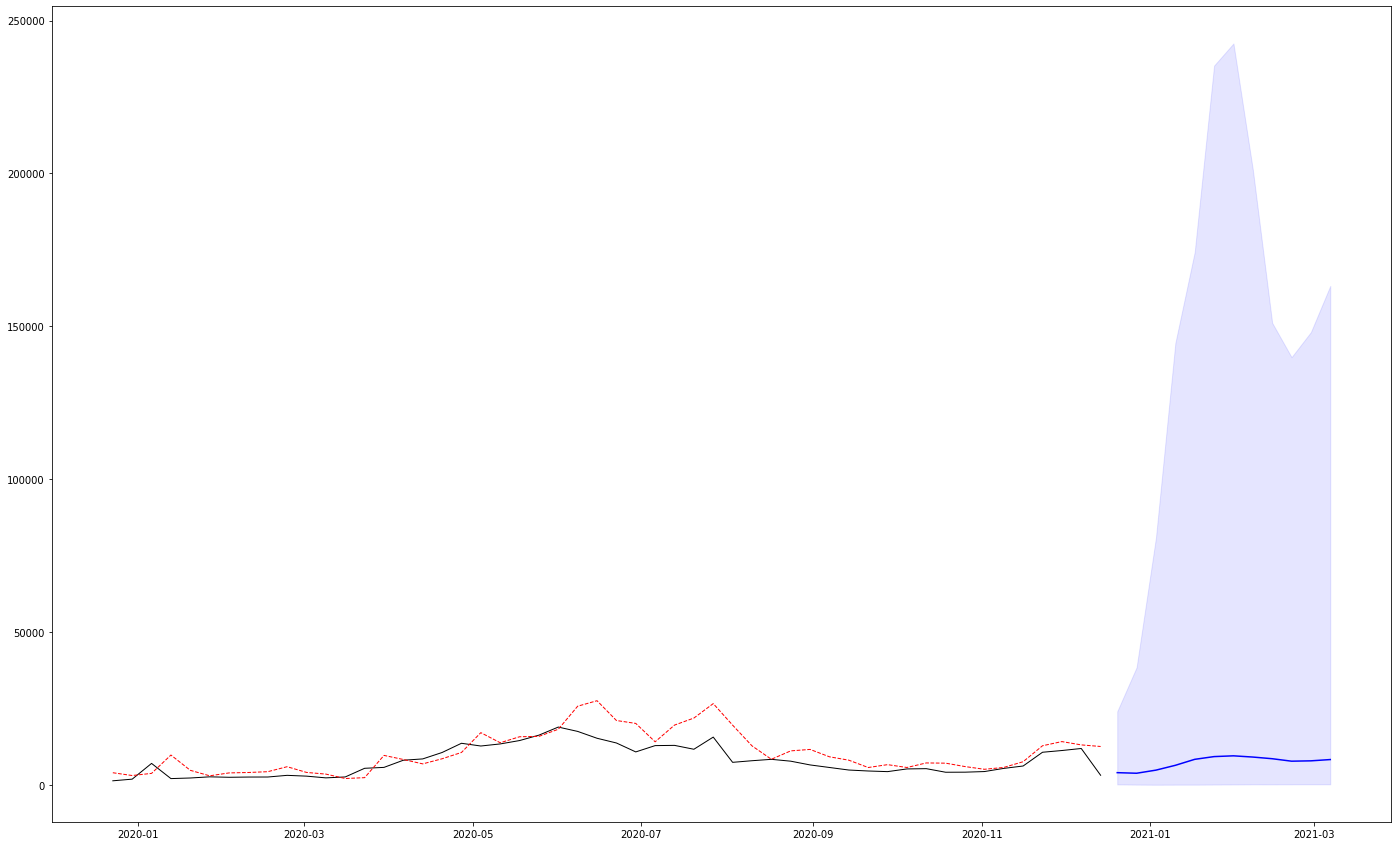

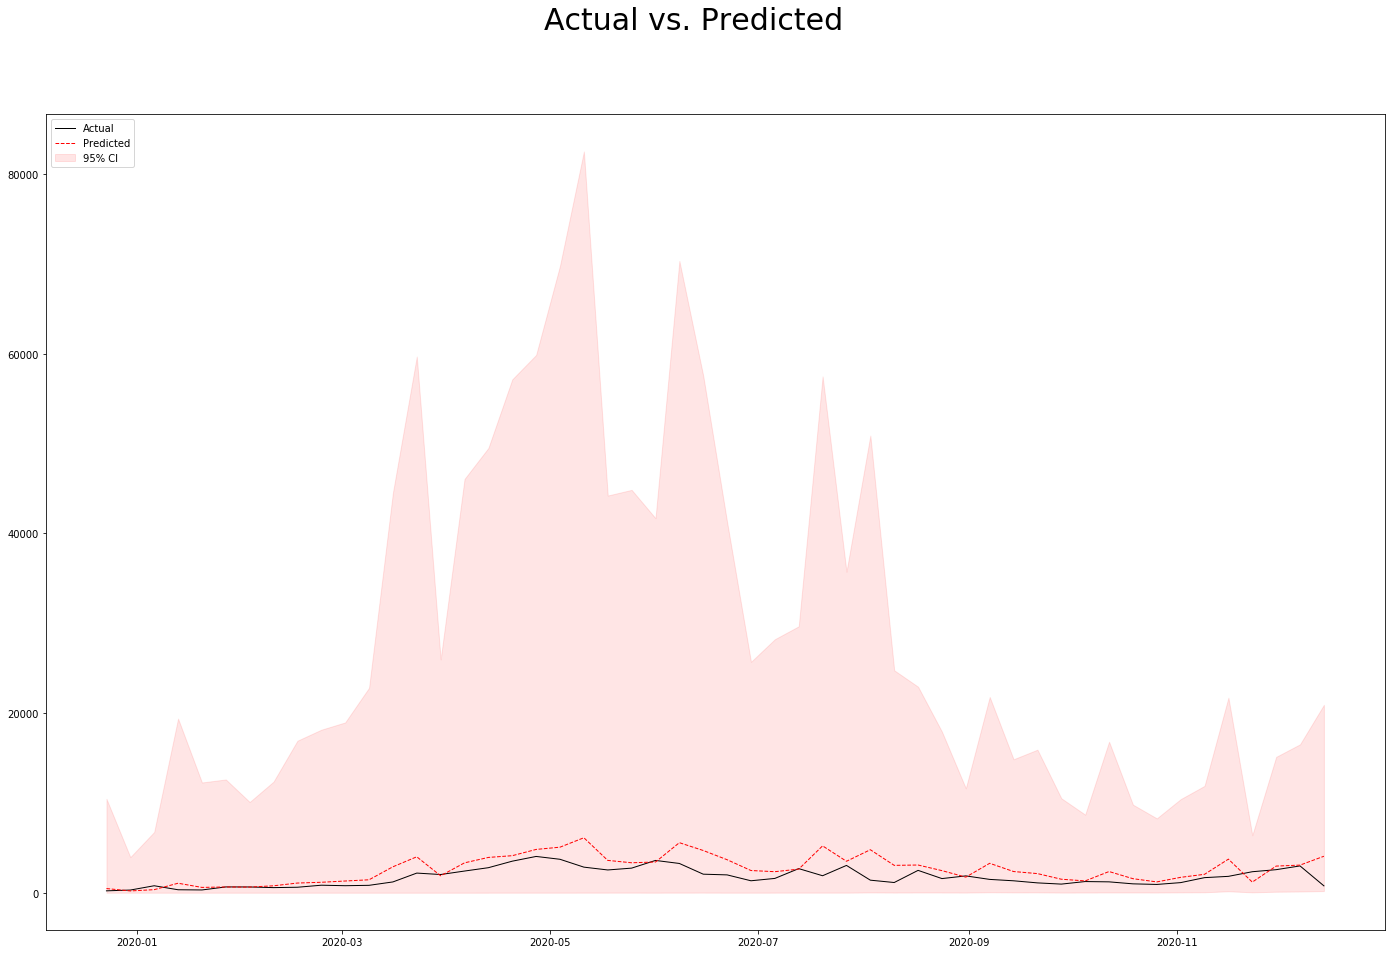

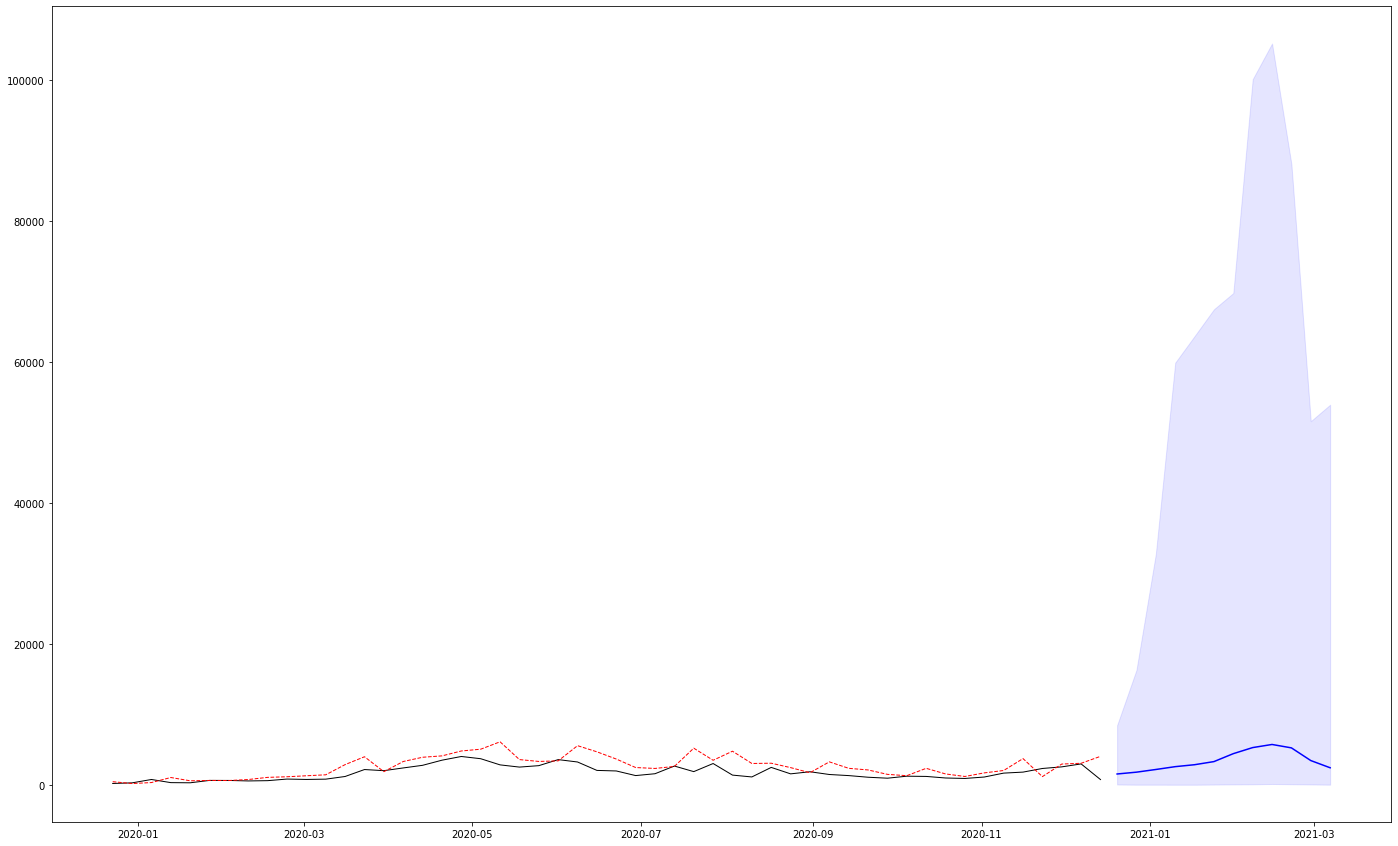

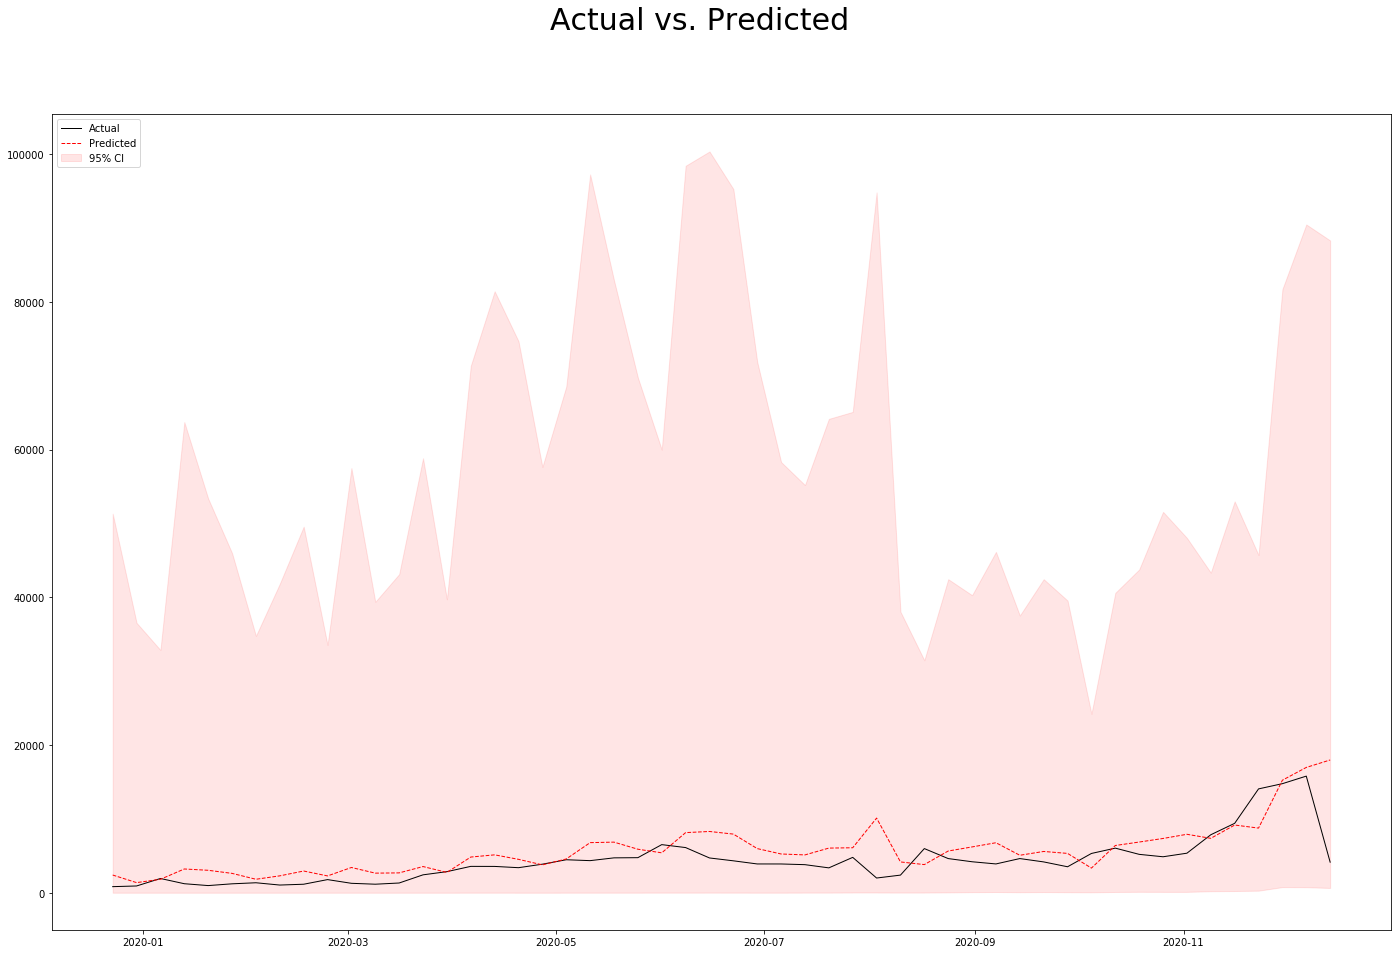

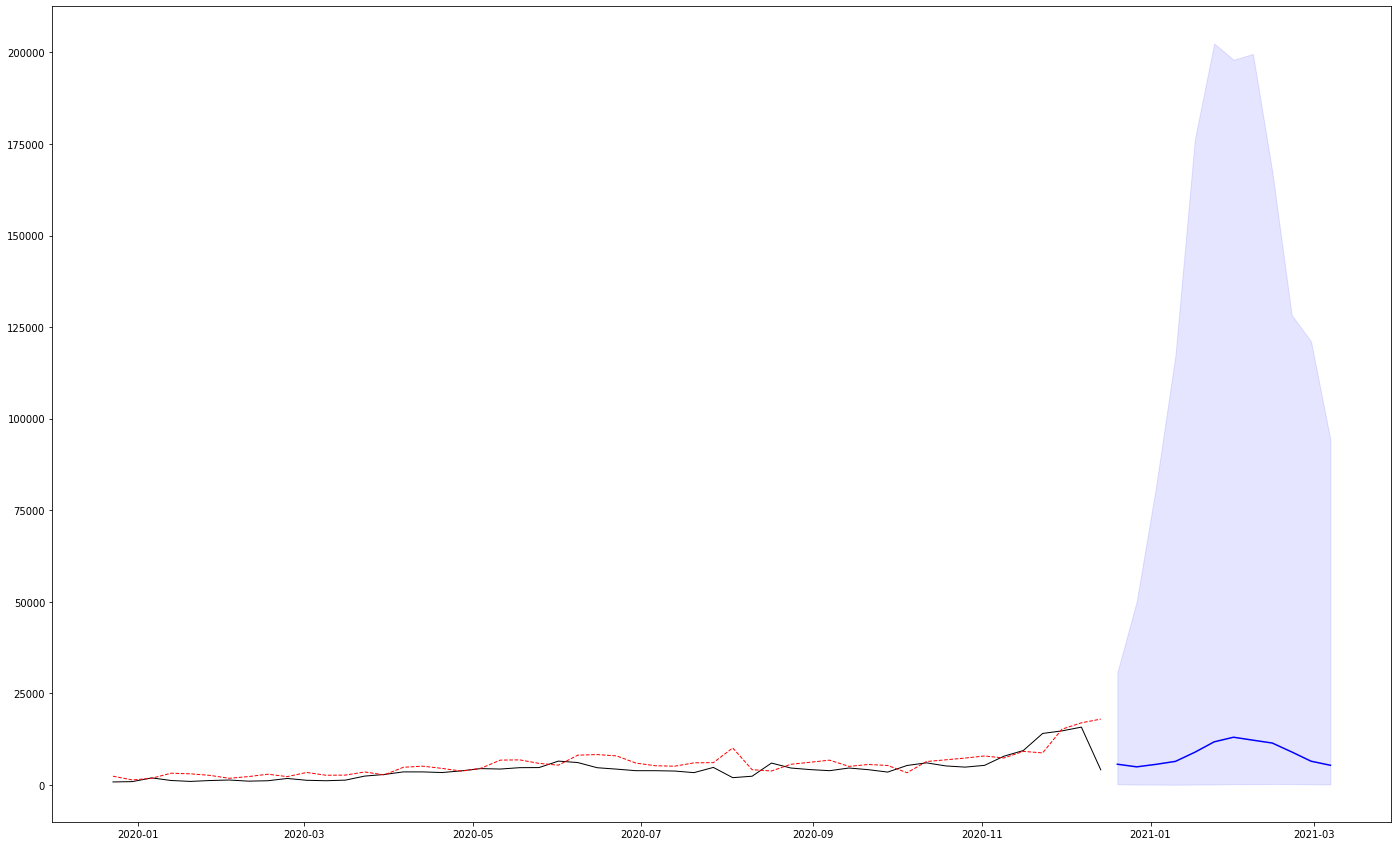

In [263]:
g = df_f_prod.groupby('PRODUCT_TYPE')
g.groups.keys()

t_f = 12

lb = 52

v_a = np.array([v, v1, v2, v3])

prior_length = 12
discount = .98

y = []
forecast = []
f_date =[]
preds = []

all_dfs = []


for name, group in g:
    y_p = group.TOTAL_GROSS_MARGIN.values
    x_p = group.TOTAL_ORDERS.values
    x1_p = group.PDISC.values
    d_p = group.WEEK_DATE
    #print(name)
    #print(group)
    
    v = np.repeat(x1_p[-1:],t_f)
    v1 = np.repeat(.05,12)
    v2 = np.repeat(.10,12)
    v3 = np.repeat(.15,12)
    v_a = np.array([v, v1, v2, v3])
    
    plot_p_orders, p_orders_f, p_orders_mod, p_y_orders, p_d_orders = bayes_forecast(x_p, x1_p, d_p, lb, 'poisson', prior_length, discount)
    y.append(p_y_orders.ravel())
    forecast.append(p_orders_f.ravel())
    f_date.append(p_d_orders.ravel())
    
    p_orders_future, fo_date = future(p_orders_mod, p_orders_f, v, t_f, p_y_orders, d_p, lb)
    f_complete = make_forecast_df(p_d_orders, p_y_orders, p_orders_f, p_orders_future, fo_date, 104, name)
    
    all_dfs.append(f_complete)
    #for i in v_a:
    #    p_orders_future, fo_date = future(p_orders_mod, p_orders_f, i, t_f, p_y_orders, d_p)
    #    preds.append(p_orders_future)

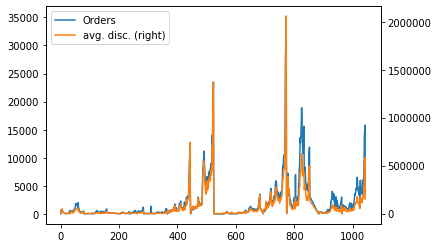

In [237]:
df_f_prod.TOTAL_ORDERS.plot(label="Orders", legend=True)
df_f_prod.TOTAL_GROSS_MARGIN.plot(secondary_y=True, label="avg. disc.", legend=True)
#plt.plot(x_p)
#plt.plot(x1_p)

In [125]:

v = np.repeat(x1_p[-1:],12)
v1 = np.repeat(.05,12)
v2 = np.repeat(.10,12)
v3 = np.repeat(.15,12)

v_a = np.array([v, v1, v2, v3])
v_a

array([[0.12171863, 0.12171863, 0.12171863, 0.12171863, 0.12171863,
        0.12171863, 0.12171863, 0.12171863, 0.12171863, 0.12171863,
        0.12171863, 0.12171863],
       [0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
        0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
        0.05      , 0.05      ],
       [0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       ],
       [0.15      , 0.15      , 0.15      , 0.15      , 0.15      ,
        0.15      , 0.15      , 0.15      , 0.15      , 0.15      ,
        0.15      , 0.15      ]])

In [ ]:
def future_product(mod, forecast, new_x, t, y, d):
    X = []
    if new_x is None:
        X == None
    else: 
        X = new_x.reshape(-1,1)
    
    future_y = mod.forecast_path(t, X=X, nsamps=1000)
    fy_median = median(future_y)
    
    # set the future date
    d = pd.to_datetime(d)
    future_dates = pd.date_range(d.max(), periods=t, freq='W')[-t:]
    
    ci = 95
    alpha = (100-ci)/2
    upper = np.percentile(future_y, [100-alpha],axis=0).reshape(-1)
    lower = np.percentile(future_y, [alpha],axis=0).reshape(-1)
    
    plt.figure(figsize=(24,15)) 
    plt.plot(d, y, color='black', linewidth=1, label='Actual')
    plt.plot(d, forecast, linestyle='--', linewidth=1, label='Predicted', color='red')
    plt.plot(future_dates, fy_median, color='blue')
    plt.fill_between(future_dates, upper, lower, alpha=.1, color='b', label='95% CI')
    
    return fy_median, future_dates

[array([1269.5,  204. ,   54. ,   36. ,   65. ,  221.5,  761. , 1776.5,
        2465.5, 2213. , 1596.5, 1037. ]),
 array([1246.5,  201. ,   53. ,   36. ,   66. ,  216. ,  728. , 1682. ,
        2366. , 2178. , 1584.5, 1042. ]),
 array([1261. ,  199. ,   52. ,   35. ,   64. ,  216.5,  737.5, 1730. ,
        2402.5, 2250.5, 1636. , 1049.5]),
 array([1286. ,  205.5,   54. ,   37. ,   68. ,  228.5,  789. , 1857.5,
        2572.5, 2316.5, 1703.5, 1123.5])]

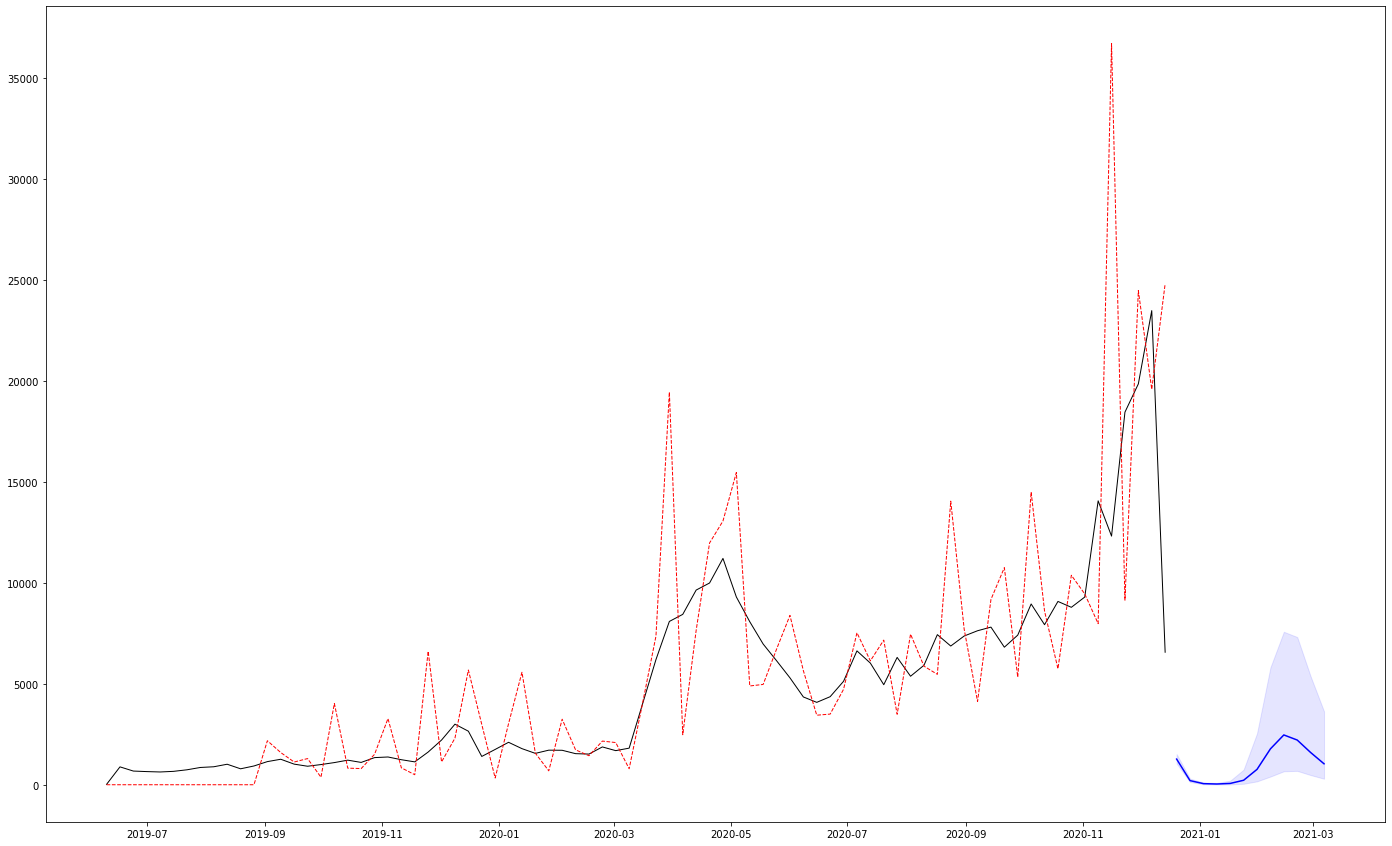

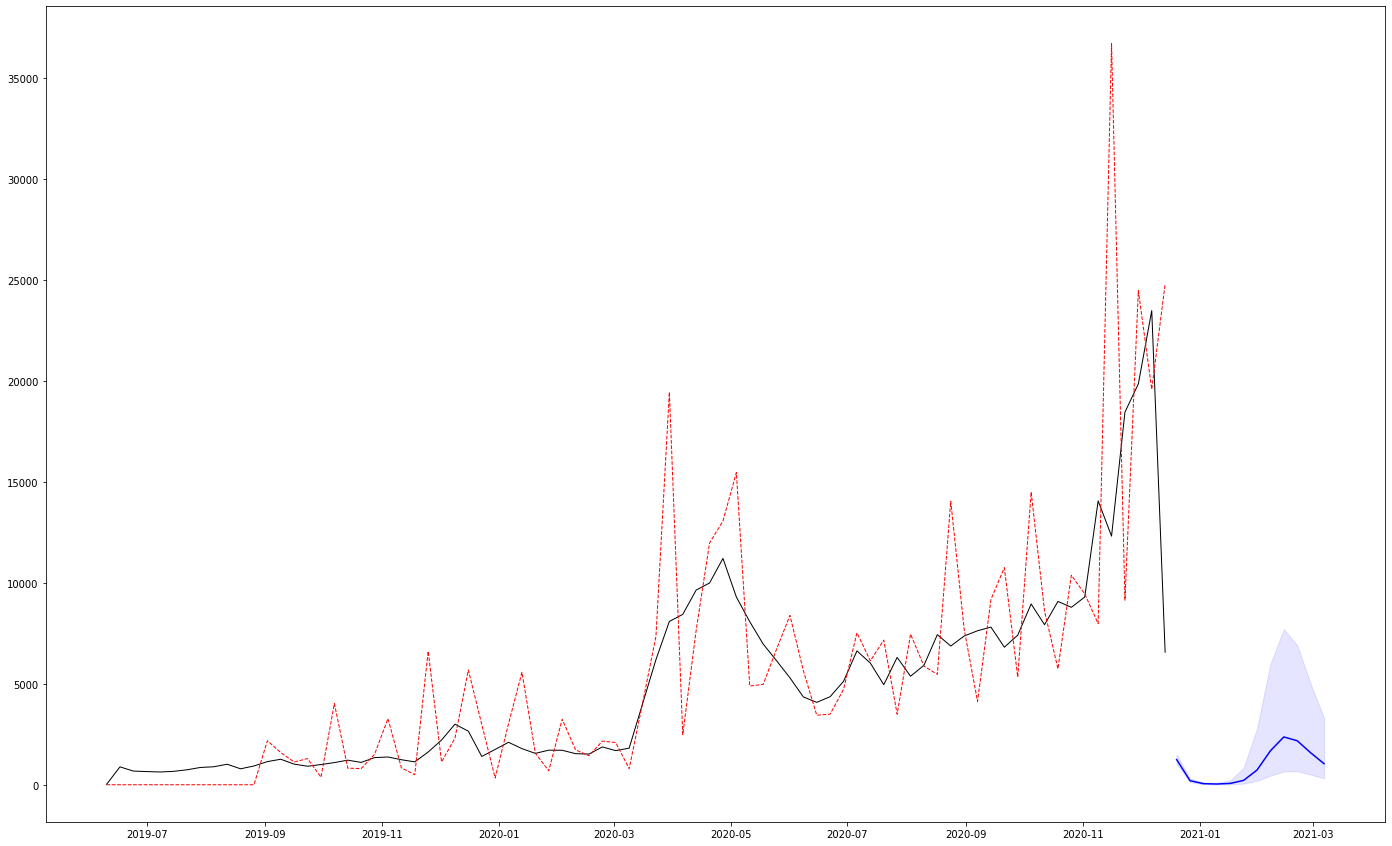

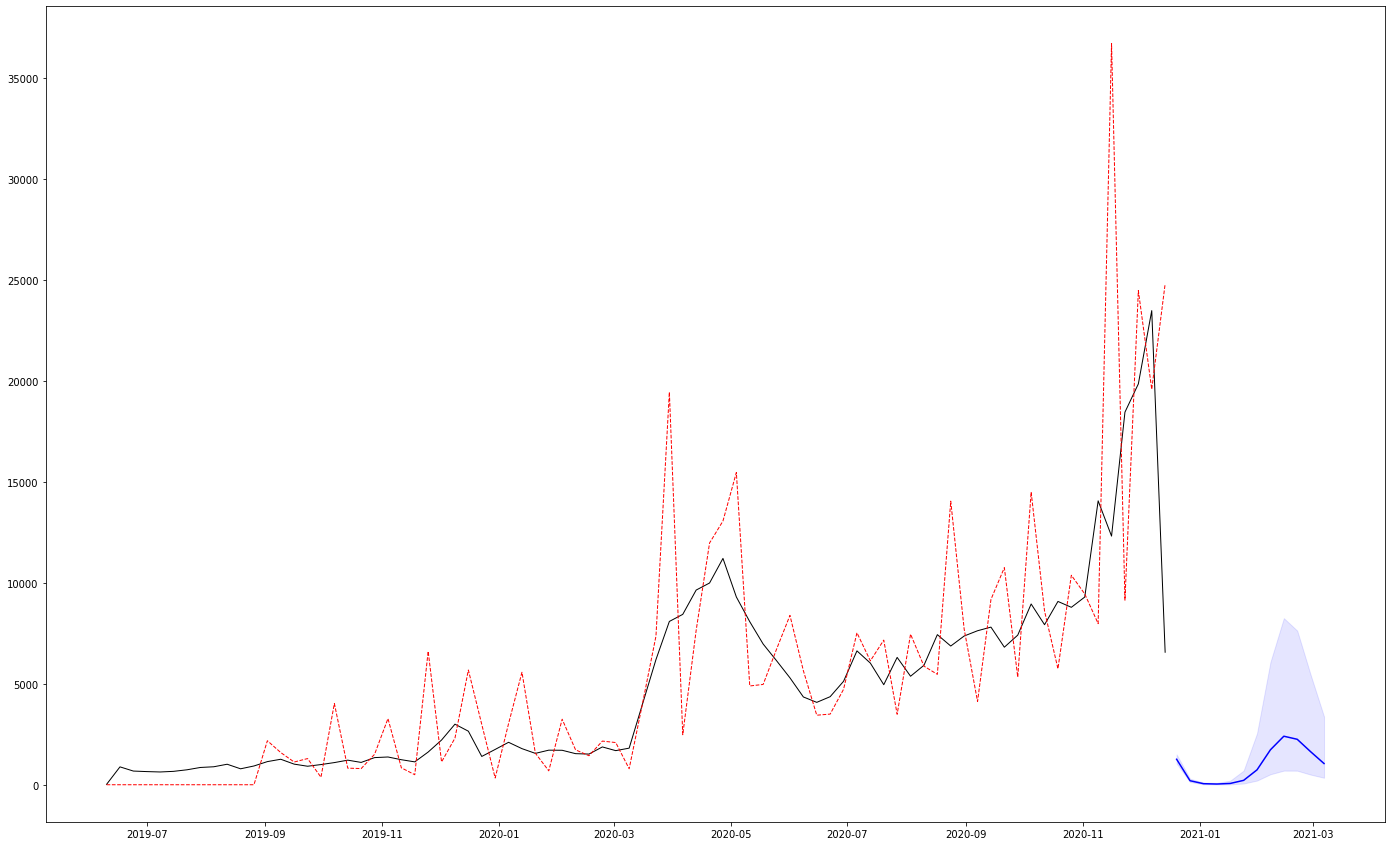

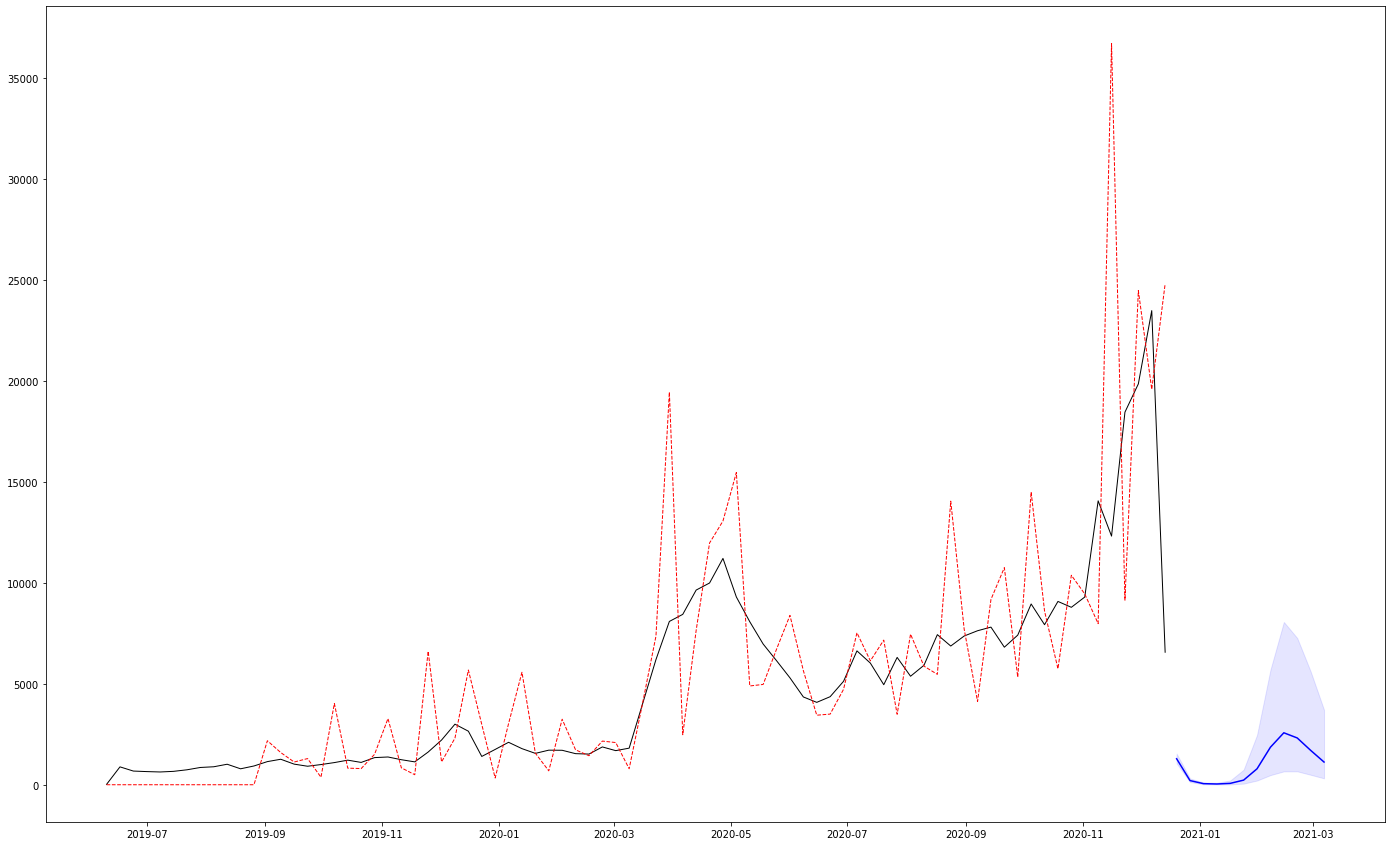

In [126]:
preds = []
for i in v_a:
    p_orders_future, fo_date = future(p_orders_mod, p_orders_f, i, 12, p_y_orders, d_p)
    preds.append(p_orders_future)
preds

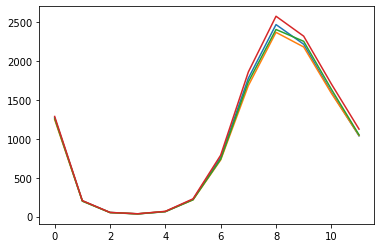

In [127]:
for i in preds:
    plt.plot(i)

61.6727


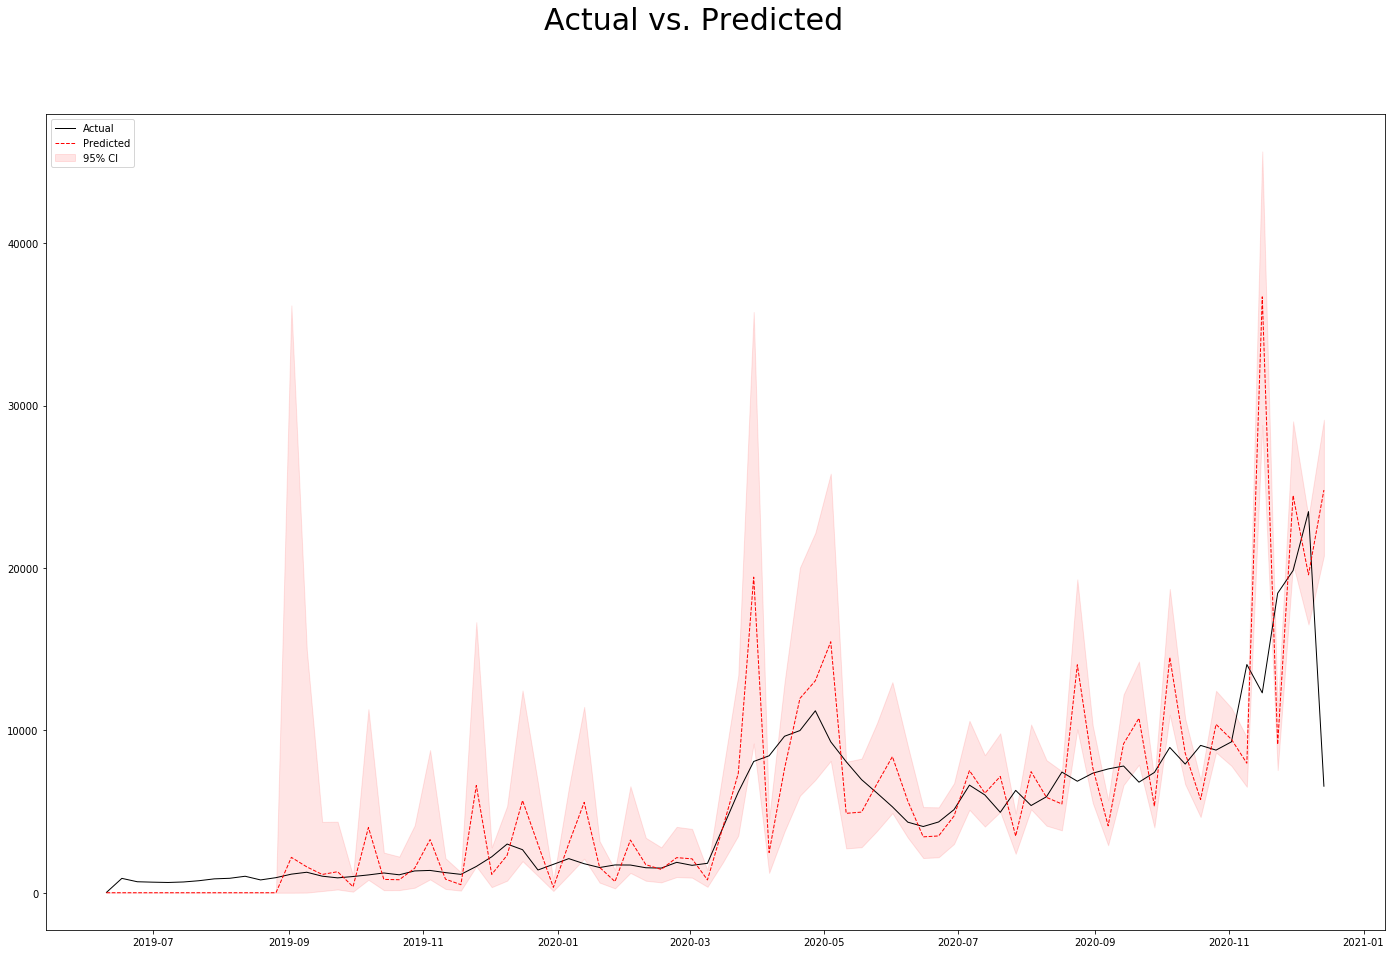

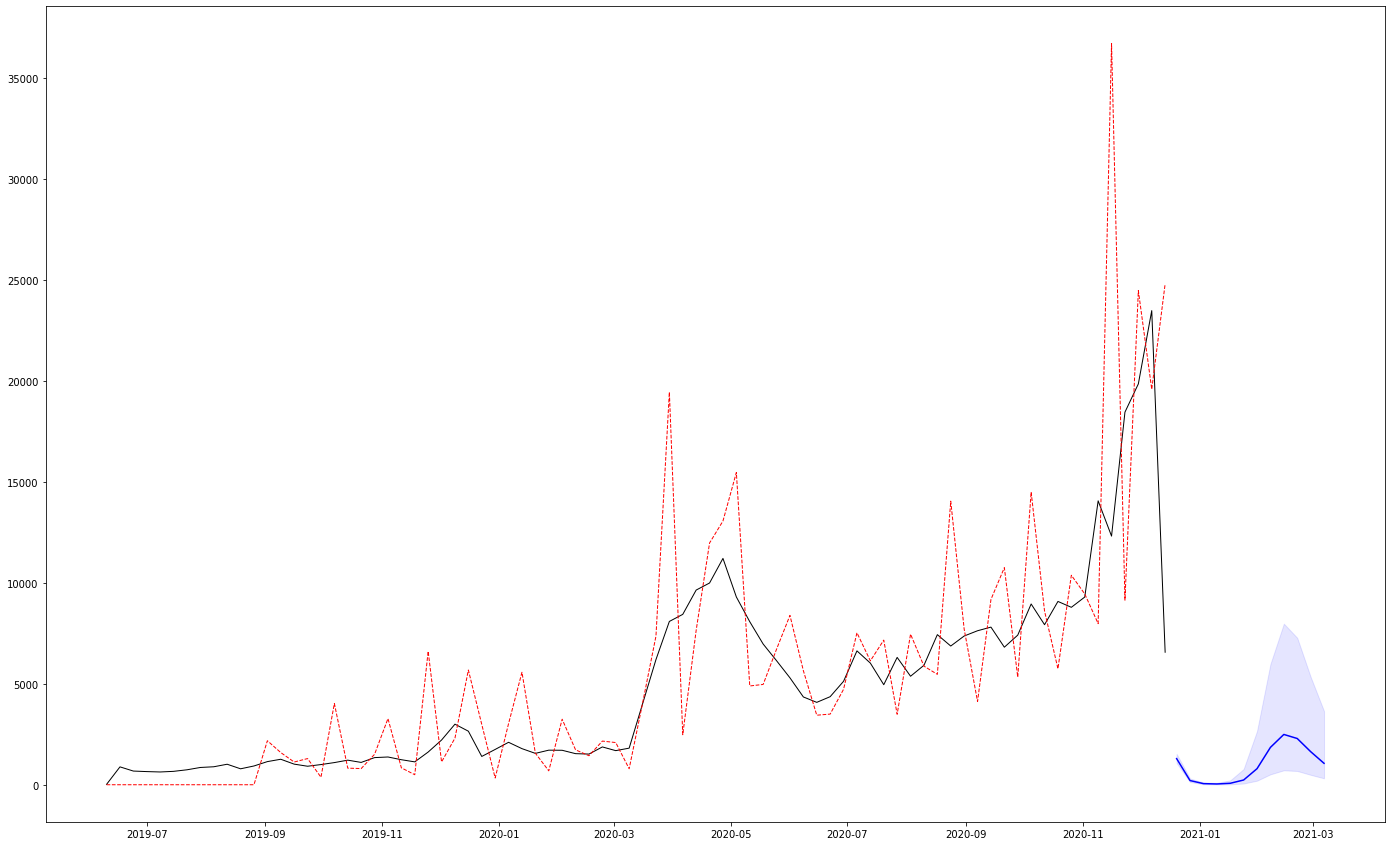

In [121]:
prior_length = 12
look_back = 104
discount = .99

# future(mod, forecast, new_x, t, y, d):

#plot_p1_orders, p1_orders_f, p1_orders_mod, p1_y_orders, p1_d_orders = bayes_forecast(x1_p, None, d_p, look_back, 'poisson', prior_length, discount)
#p1_orders_future, p1_fo_date = future(p1_orders_mod, p1_orders_f, None, 12, p1_y_orders, d_p)

# Need to predict Orders first, since it is the independent variable
plot_p_orders, p_orders_f, p_orders_mod, p_y_orders, p_d_orders = bayes_forecast(x_p, x1_p, d_p, look_back, 'poisson', prior_length, discount)

# run the model into the future N steps
p_orders_future, fo_date = future(p_orders_mod, p_orders_f, v3, 12, p_y_orders, d_p)
#print(p_orders_future)

In [116]:
v_pred = p_orders_future
v_pred

array([1270. ,  204. ,   53. ,   36. ,   65. ,  215. ,  752. , 1755. ,
       2435. , 2187.5, 1619.5, 1080. ])

In [118]:
v1_pred = p_orders_future
v1_pred

array([1247.5,  199. ,   52. ,   35. ,   64.5,  214. ,  735.5, 1722. ,
       2424. , 2222. , 1558. , 1022. ])

In [120]:
v2_pred = p_orders_future
v2_pred

array([1268.5,  204. ,   55. ,   38. ,   71. ,  235.5,  776.5, 1828.5,
       2585. , 2389. , 1706.5, 1086.5])

In [122]:
v3_pred = p_orders_future
v3_pred

array([1292.5,  207. ,   55. ,   38. ,   72. ,  234. ,  795. , 1849.5,
       2490.5, 2289.5, 1640. , 1060.5])

NameError: name 'upper' is not defined

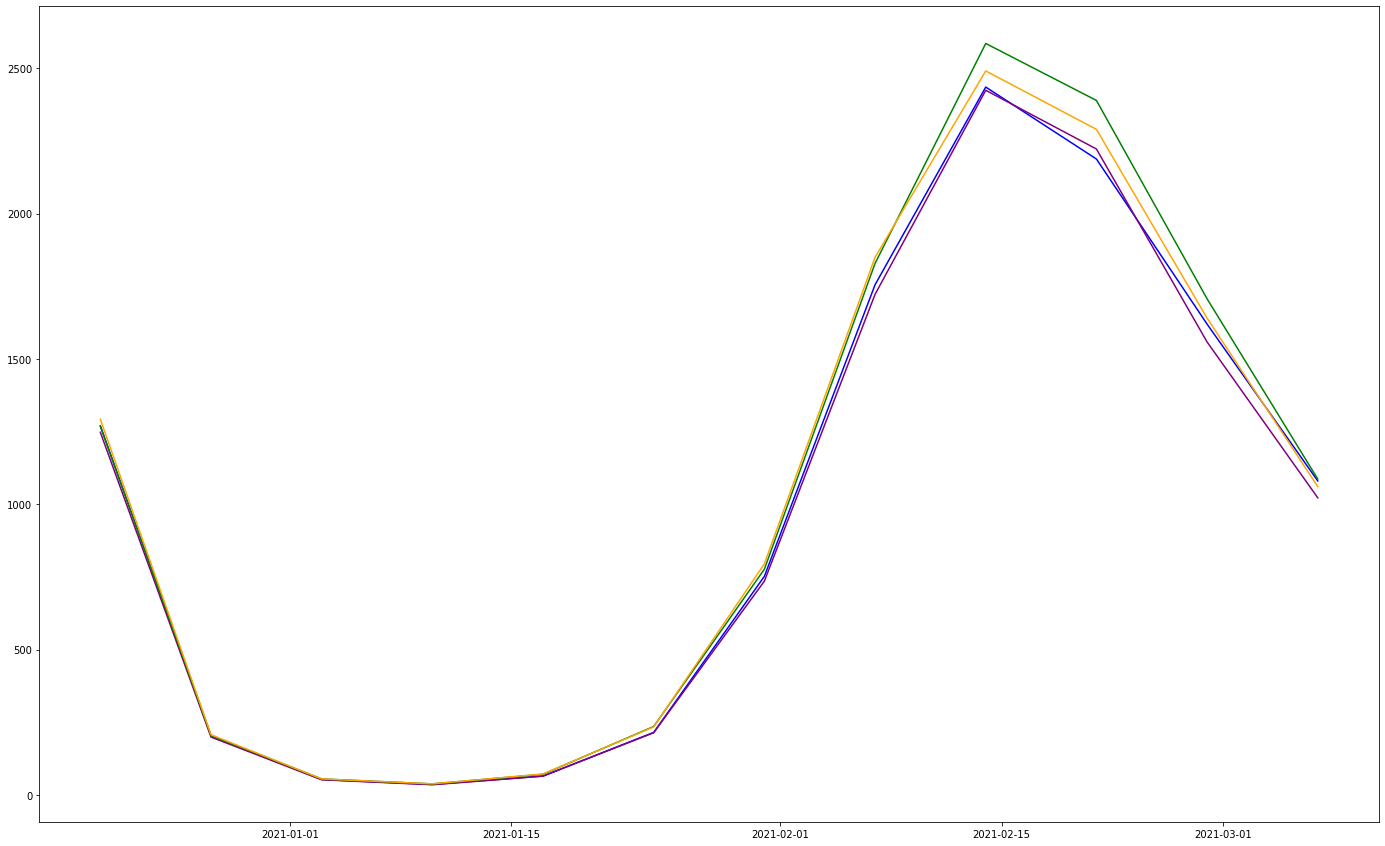

In [123]:
plt.figure(figsize=(24,15)) 
#plt.plot(d_p, x_p, color='black', linewidth=1, label='Actual')
#plt.plot(d_p, p_orders_f, linestyle='--', linewidth=1, label='Predicted', color='red')
plt.plot(fo_date, v_pred, color='blue')
plt.plot(fo_date, v1_pred, color='purple')
plt.plot(fo_date, v2_pred, color='green')
plt.plot(fo_date, v3_pred, color='orange')
plt.fill_between(fo_date, upper, lower, alpha=.1, color='b', label='95% CI')

In [3900]:
df_f.tail()

week_date  total_sales  total_units  total_orders week_date2  \
327 2020-11-02  140256.4537         1447           803 2020-11-02   
328 2020-11-09  286708.2902         2972          1523 2020-11-09   
329 2020-11-16  306739.5659         3639          1811 2020-11-16   
330 2020-11-23  338373.6099         4418          2380 2020-11-23   
331 2020-11-30  170748.0977         2069          1132 2020-11-30   

     total_traffic  
327          36689  
328          51258  
329          54254  
330          66843  
331          44825

In [3899]:
df_f['week_date'] = pd.to_datetime(df_f.week_date)
df_f_train = df_f[df_f.week_date < '2020-09-01']

In [3901]:
df_f_test = df_f[(df_f.week_date >= '2020-08-31')]
df_f_test

week_date  total_sales  total_units  total_orders week_date2  \
318 2020-08-31  171234.9375         2694          1297 2020-08-31   
319 2020-09-07  283993.6517         3545          1629 2020-09-07   
320 2020-09-14  203471.4744         2315          1168 2020-09-14   
321 2020-09-21  170459.0769         1962          1029 2020-09-21   
322 2020-09-28  203688.8785         2179          1192 2020-09-28   
323 2020-10-05  296187.9306         3087          1541 2020-10-05   
324 2020-10-12  207998.4483         2199          1154 2020-10-12   
325 2020-10-19  191438.3430         1964          1089 2020-10-19   
326 2020-10-26  138577.5884         1450           795 2020-10-26   
327 2020-11-02  140256.4537         1447           803 2020-11-02   
328 2020-11-09  286708.2902         2972          1523 2020-11-09   
329 2020-11-16  306739.5659         3639          1811 2020-11-16   
330 2020-11-23  338373.6099         4418          2380 2020-11-23   
331 2020-11-30  170748.0977         2069          1132 2020-11-30   

     total_traffic  
318          55103  
319          62615  
320          48230  
321          45958  
322          53845  
323          54876  
324          42432  
325          43224  
326          37092  
327          36689  
328          51258  
329          54254  
330          66843  
331          44825

### Test Data For Orders and Traffic

In [3902]:
# Traffic Test set
x1_test = df_f_test.total_traffic.values
# Orders Test set
y_test = df_f_test.total_orders.values

### Training Data for Orders and Traffic

In [3903]:
# For Trainining / Test
#x = pd.to_datetime(df_f_train.week_date)
#y = df_f_train.total_orders
#x1 = df_f_train.total_traffic.values

In [4011]:
# All Data (not subset)
x = pd.to_datetime(df_f.week_date)
y = df_f.total_orders
x1 = df_f.total_traffic.values

# Orders Forecast Model 

20.7526


Text(0.5, 0.98, 'Actual vs. Predicted Orders')

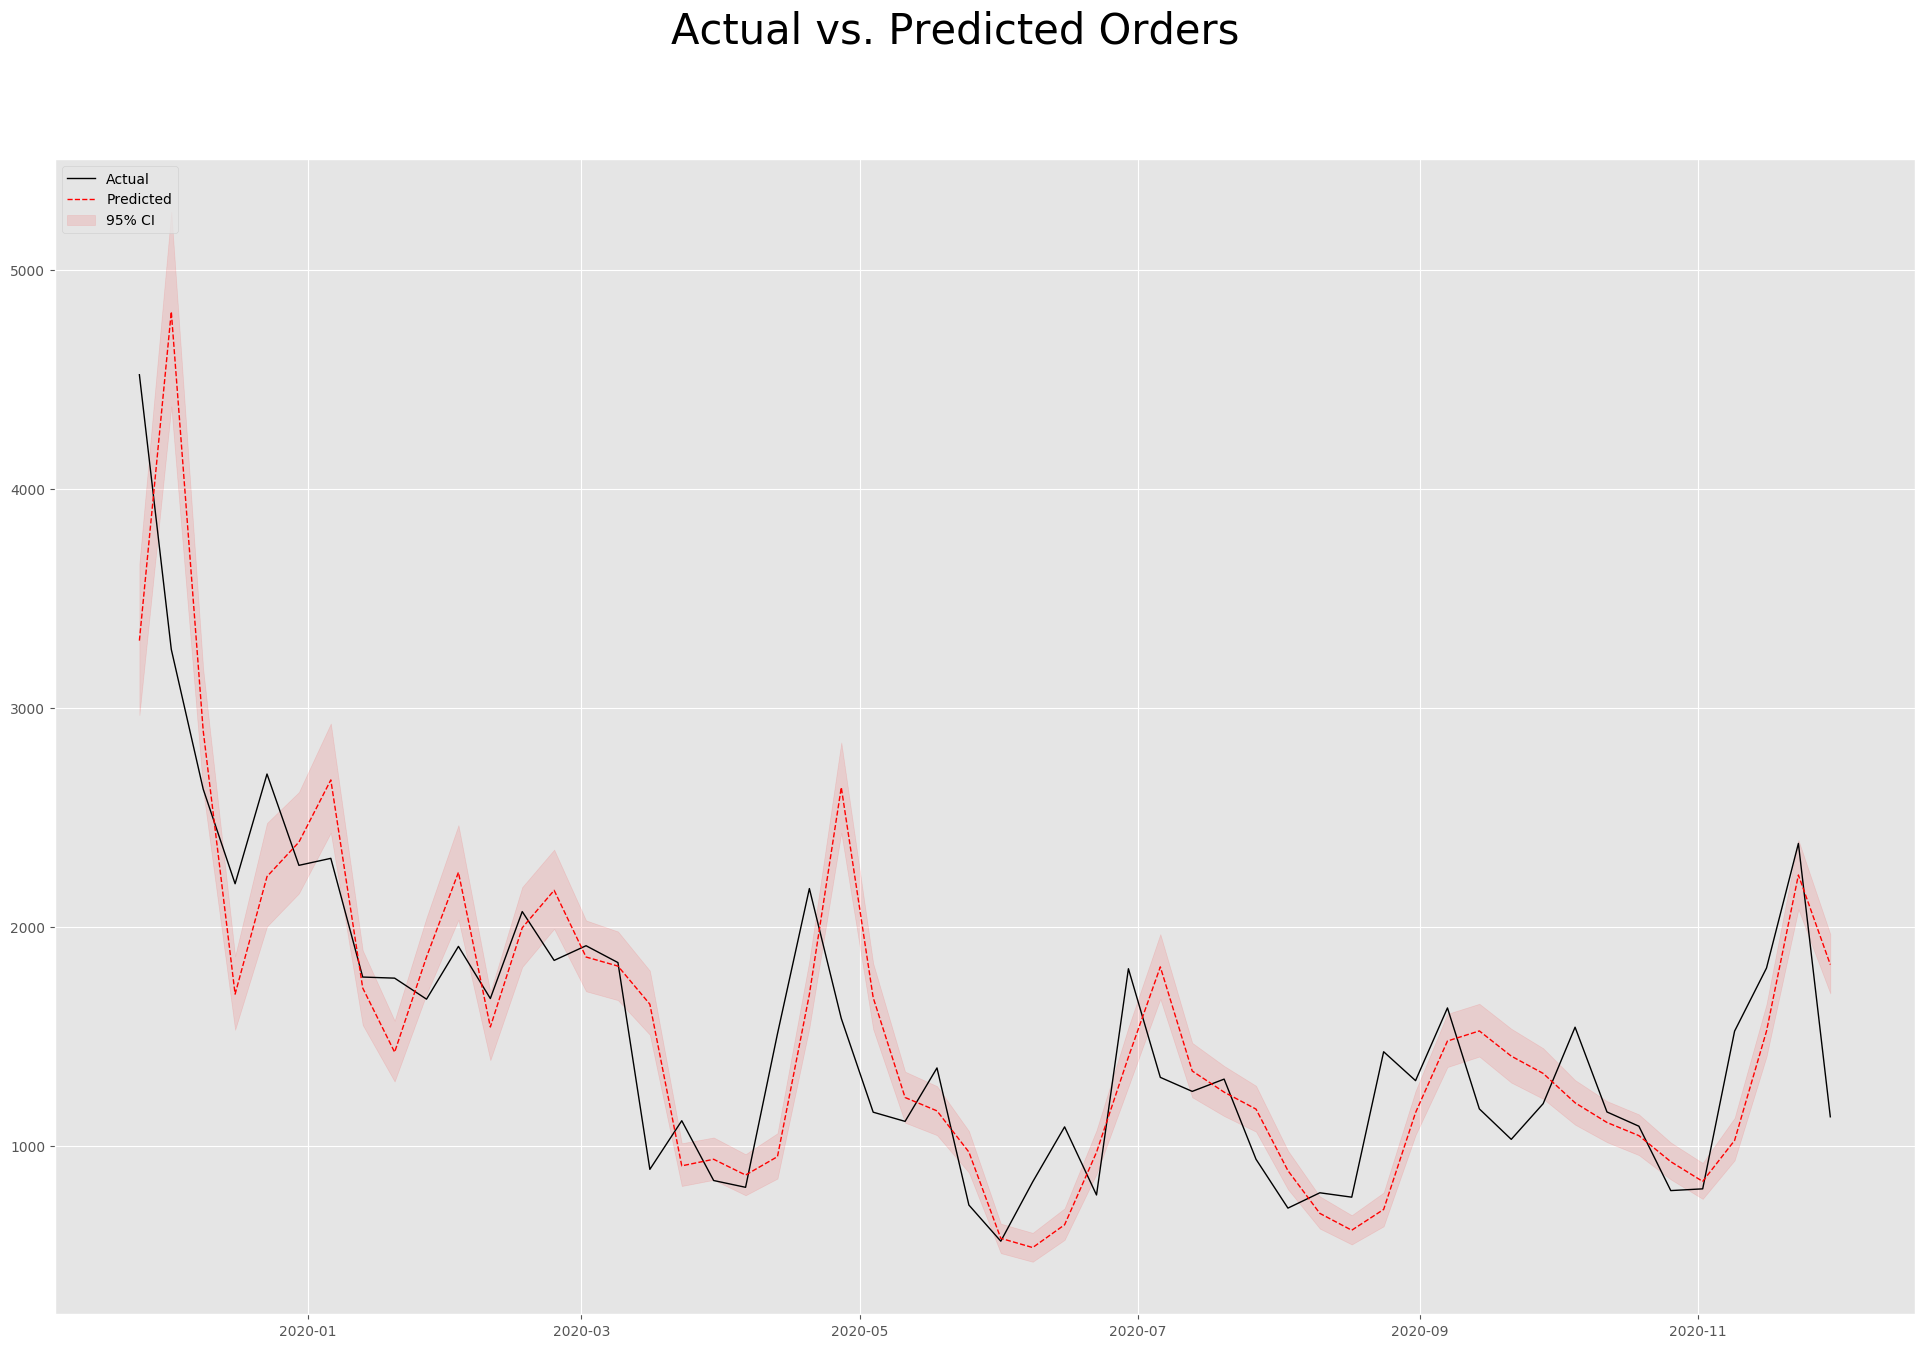

In [4165]:
k=1
Y=y.values
prior_length = 12
forecast_start = 0                                 
forecast_end = len(Y)-1
discount = 0.98


mod, samples = analysis(Y, X=x1, family="poisson",
forecast_start=forecast_start,      
forecast_end=forecast_end,         
k=k,
holiday = holidays,
ntrend=2,
seasPeriods=[52,12],
nsamps=2500, 
seasHarmComponents=[[1,2,3,4],[1,2]],
prior_length=prior_length,                     
deltrend=.98,                      
delregn=.99,                        
delVar=.98,
delseas=.99,
s0=0.001)

forecast = median(samples)
ci = 95
alpha = (100-ci)/2
upper = np.percentile(samples, [100-alpha],axis=0).reshape(-1)
lower = np.percentile(samples, [alpha],axis=0).reshape(-1)
x_axis = np.arange(0,y[140:].shape[0],1)


#future_y = mod.forecast_path(10, X=x1_test.reshape(-1,1), nsamps=1000)
future_y = mod.forecast_path(12, X=yt_forecast.reshape(-1,1), nsamps=1000)
#future_y = mod.forecast_path(12, X=None, nsamps=1000)
y_forecast = median(future_y)
upper_yf = np.percentile(future_y, [100-alpha],axis=0).reshape(-1)
lower_yf = np.percentile(future_y, [alpha],axis=0).reshape(-1)
y_forecast

# Error Metric - using the mean absolute deviation (MAD)
#print(np.round(MAPE(Y[forecast_start:forecast_end+1], forecast), 4))
print(np.round(MAPE(Y[-lb:], forecast[-lb:]), 4))

lb = 54

plt.figure(figsize=(24,15)) 
plt.plot(x[-lb:], y[-lb:], color='black', linewidth=1, label='Actual')
plt.plot(x[-lb:],forecast[-lb:], linestyle='--', linewidth=1, label='Predicted', color='red')
plt.fill_between(x[-lb:], upper[-lb:], lower[-lb:], alpha=.1, color='r', label='95% CI')
plt.legend(loc="upper left")
plt.suptitle('Actual vs. Predicted Orders', fontsize=30)

In [4166]:
y_forecast

array([1587. , 1601. , 1610. , 1504. , 1289. , 1059. ,  920. ,  890. ,
        929. ,  974.5,  982. ,  945. ])

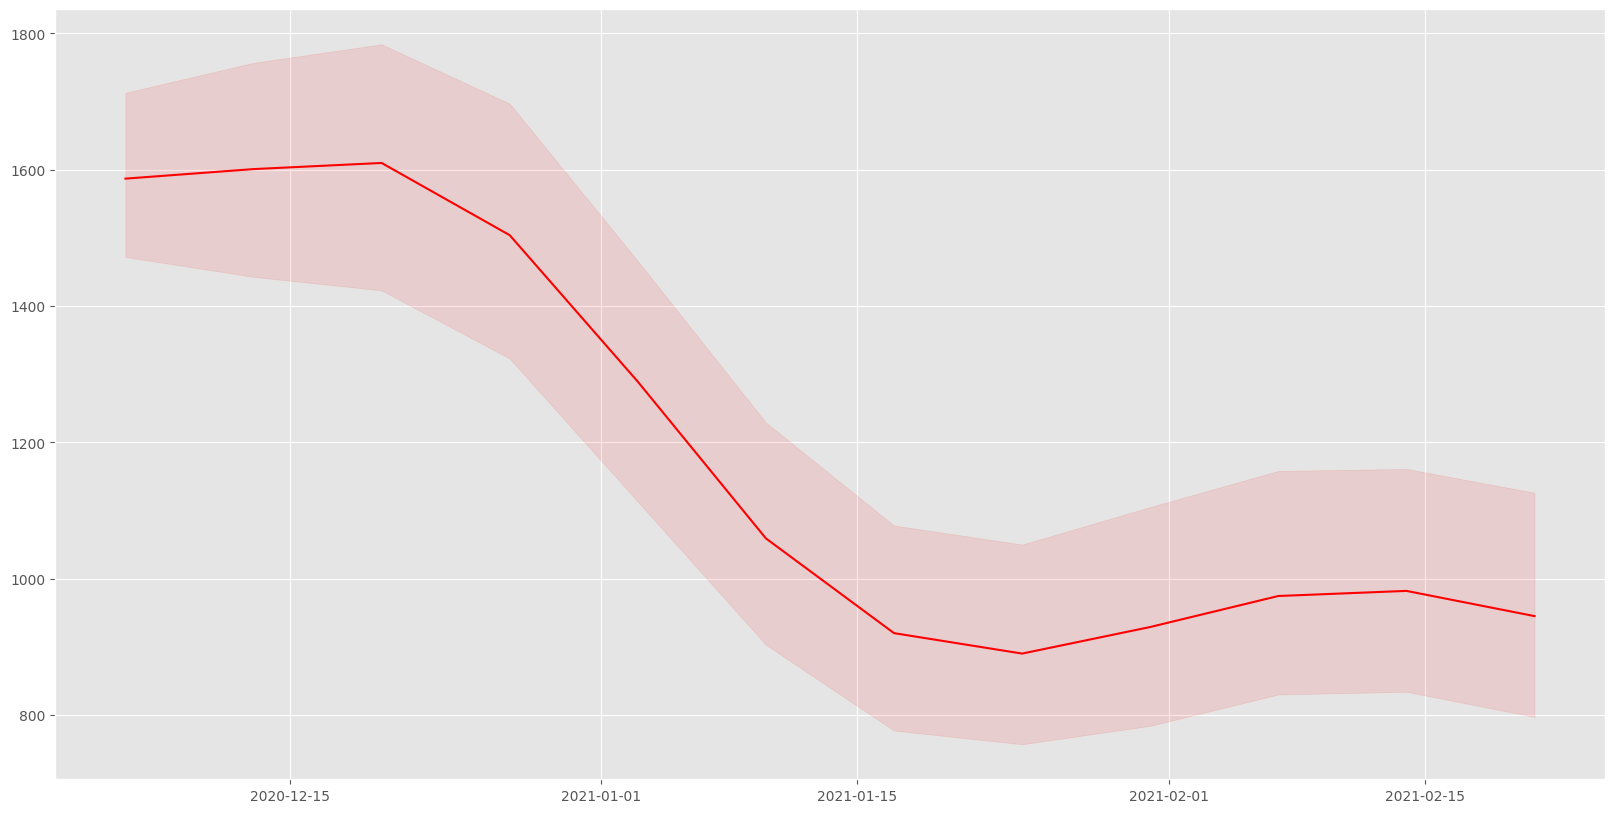

In [4167]:
date = pd.to_datetime(x)
f_date = pd.date_range(date.max(), periods=12, freq='W')[-12:]
f_date

plt.plot(f_date, y_forecast, color="red")
#plt.plot(f_date, y_test, color="black")
plt.fill_between(f_date, upper_yf, lower_yf, alpha=.1, color='r', label='95% CI')
#plt.plot(y_test, color="black")
#print(MAPE(y_test, y_forecast))

In [4168]:
xdf = pd.DataFrame(x[-lb:]).reset_index(drop=True)
ydf = pd.DataFrame(y[-lb:]).reset_index(drop=True)
fdf = pd.DataFrame(forecast[-lb:]).reset_index(drop=True)

f1_df = pd.concat([xdf, ydf, fdf,], axis=1)
f1_df.columns=['date', 'total_orders', 'forecast_orders']

In [4169]:
x_fut = pd.DataFrame(f_date).reset_index(drop=True)
y_fut = pd.DataFrame(median(future_y)).reset_index(drop=True)

fut_df = pd.concat([x_fut, y_fut], axis=1)
fut_df.columns=['date', 'future_forecast_orders']
fut_df

date  future_forecast_orders
0  2020-12-06                  1587.0
1  2020-12-13                  1601.0
2  2020-12-20                  1610.0
3  2020-12-27                  1504.0
4  2021-01-03                  1289.0
5  2021-01-10                  1059.0
6  2021-01-17                   920.0
7  2021-01-24                   890.0
8  2021-01-31                   929.0
9  2021-02-07                   974.5
10 2021-02-14                   982.0
11 2021-02-21                   945.0

In [4170]:
test_df = pd.concat([f1_df, fut_df], axis=0)
test_df

date  total_orders  forecast_orders  future_forecast_orders
0  2019-11-25        4520.0           3306.0                     NaN
1  2019-12-02        3266.0           4808.0                     NaN
2  2019-12-09        2628.0           2894.5                     NaN
3  2019-12-16        2196.0           1692.0                     NaN
4  2019-12-23        2697.0           2229.0                     NaN
..        ...           ...              ...                     ...
7  2021-01-24           NaN              NaN                   890.0
8  2021-01-31           NaN              NaN                   929.0
9  2021-02-07           NaN              NaN                   974.5
10 2021-02-14           NaN              NaN                   982.0
11 2021-02-21           NaN              NaN                   945.0

[66 rows x 4 columns]

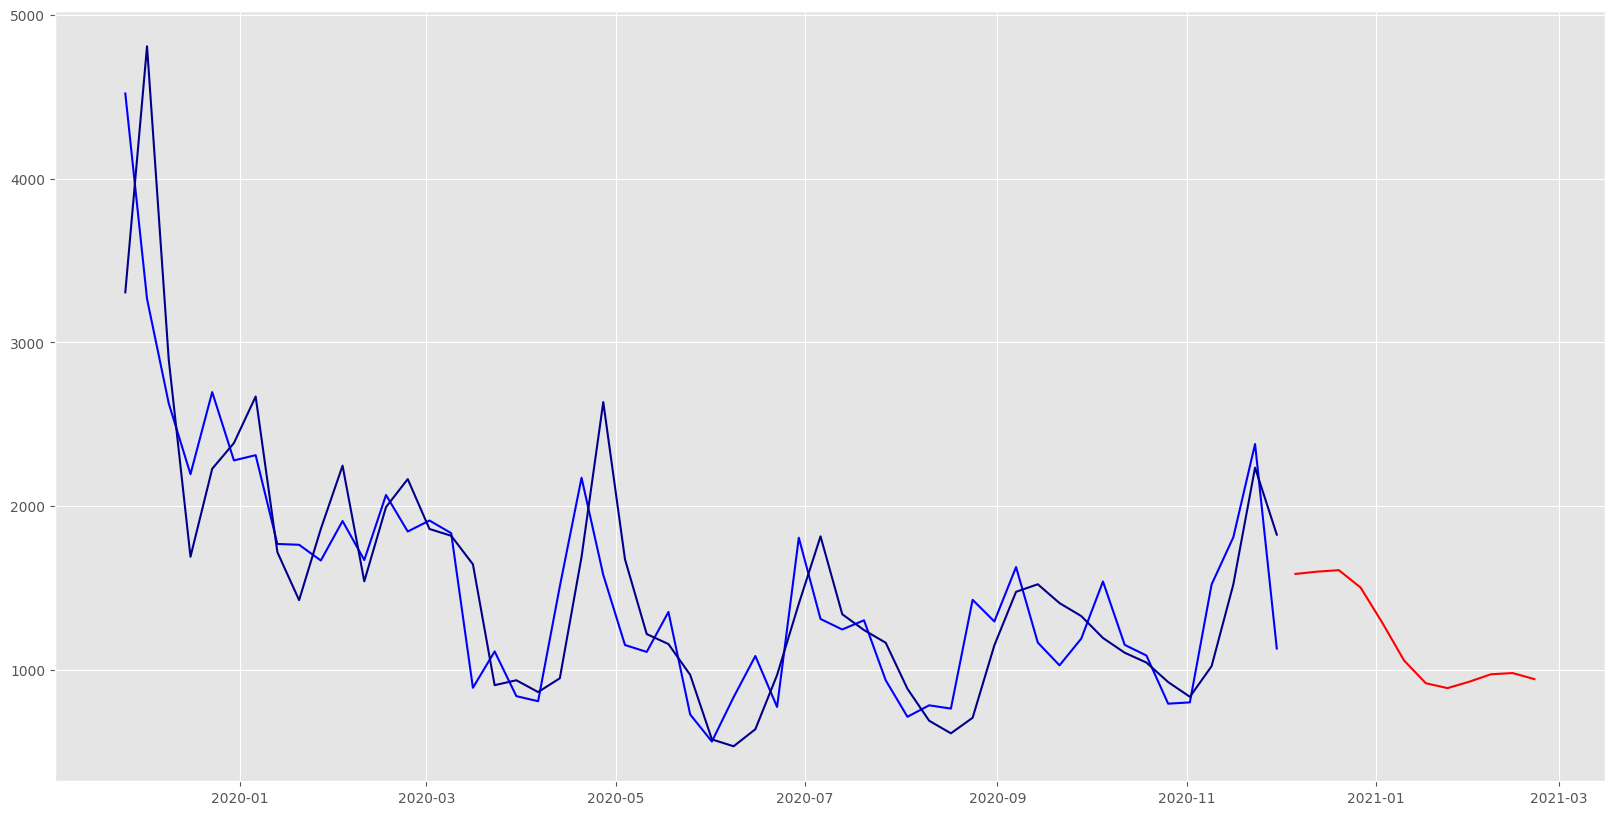

In [4171]:
plt.plot(test_df.date, test_df.total_orders, color='blue')
plt.plot(test_df.date, test_df.forecast_orders, color='darkblue')
plt.plot(test_df.date, test_df.future_forecast_orders, color='red')

### Training - Predict Traffic

23.465


Text(0.5, 0.98, 'Actual vs. Predicted Traffic')

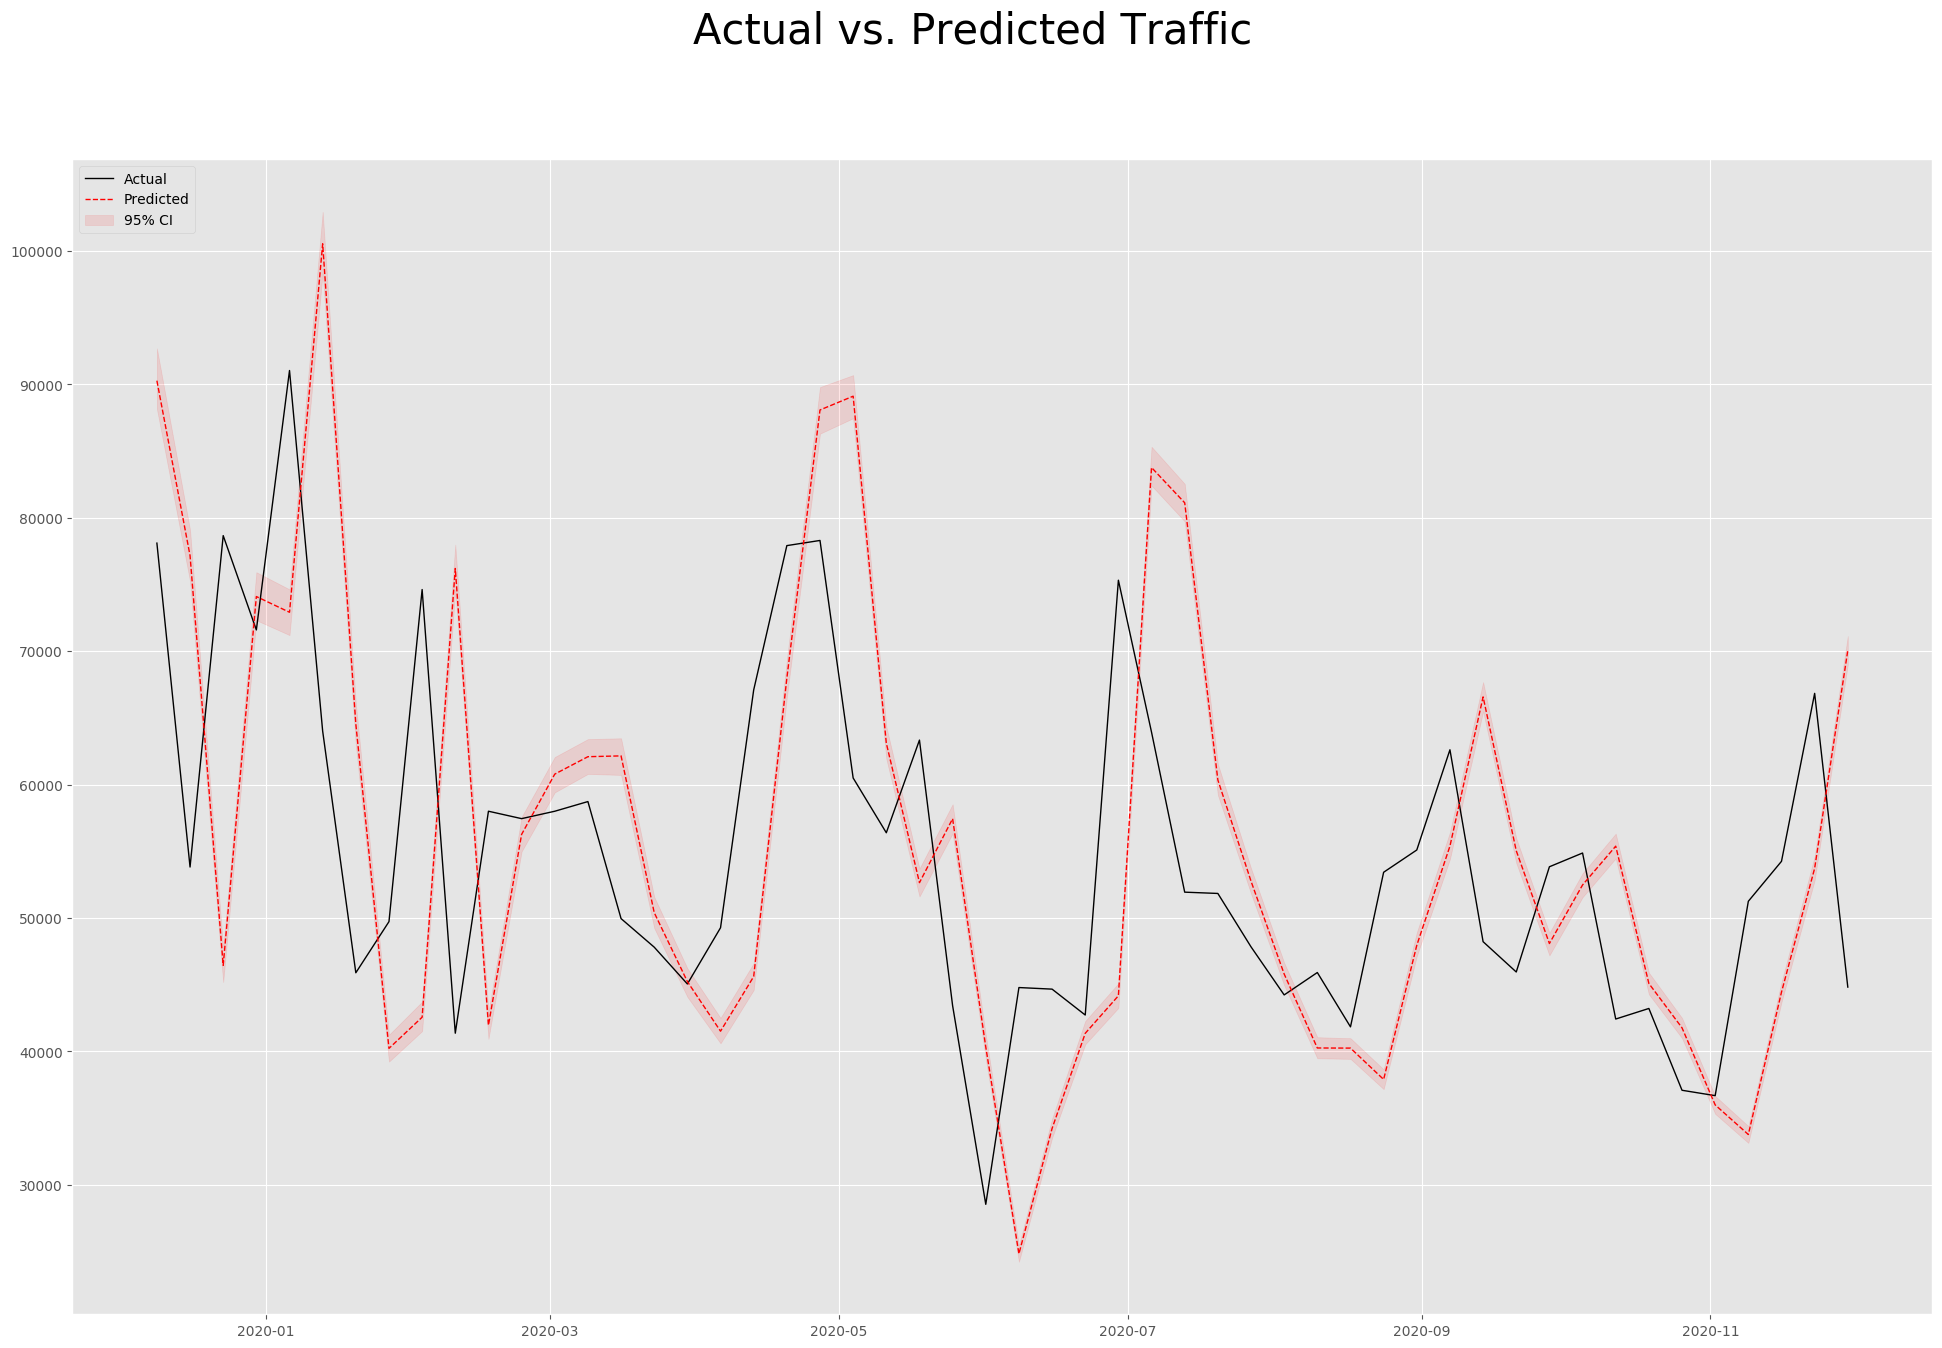

In [4162]:
# For Trainining / Test
#x = pd.to_datetime(df_f_train.date)
#y = df_f_train.total_orders
#x1 = df_f_train.total_traffic.values

k=1
Y=x1
prior_length = 4
forecast_start = 0                                 
forecast_end = len(Y)-1
discount = 0.98


mod, samples = analysis(Y, X=None, family="poisson",
forecast_start=forecast_start,      
forecast_end=forecast_end,         
k=k,
#holiday = holidays,
ntrend=2,
seasPeriods=[52],
nsamps=2000, 
seasHarmComponents=[[1,2,3]],
prior_length=prior_length,                     
deltrend=.99,                      
delregn=discount,                        
delVar=.98,
delseas=.98,
s0=0.01)

forecast = median(samples)
ci = 98
alpha = (100-ci)/2
upper = np.percentile(samples, [100-alpha],axis=0).reshape(-1)
lower = np.percentile(samples, [alpha],axis=0).reshape(-1)
x_axis = np.arange(0,y[140:].shape[0],1)


#future_y = mod.forecast_path(10, X=x1_test.reshape(-1,1), nsamps=1000)
future_y = mod.forecast_path(12, X=None, nsamps=1000)
yt_forecast = median(future_y)
yt_forecast

# Error Metric - using the mean absolute deviation (MAD)
#print(np.round(MAPE(Y[forecast_start:forecast_end+1], forecast), 4))
print(np.round(MAPE(Y[-lb:], forecast[-lb:]), 4))

lb = 52

plt.figure(figsize=(24,15)) 
plt.plot(x[-lb:], Y[-lb:], color='black', linewidth=1, label='Actual')
plt.plot(x[-lb:],forecast[-lb:], linestyle='--', linewidth=1, label='Predicted', color='red')
plt.fill_between(x[-lb:], upper[-lb:], lower[-lb:], alpha=.1, color='r', label='95% CI')
plt.legend(loc="upper left")
plt.suptitle('Actual vs. Predicted Traffic', fontsize=30)

In [4163]:
yt_forecast

array([54704.5, 55414. , 55338.5, 54421. , 52751.5, 50479.5, 48053. ,
       45555.5, 43208.5, 41340. , 39949. , 39034. ])

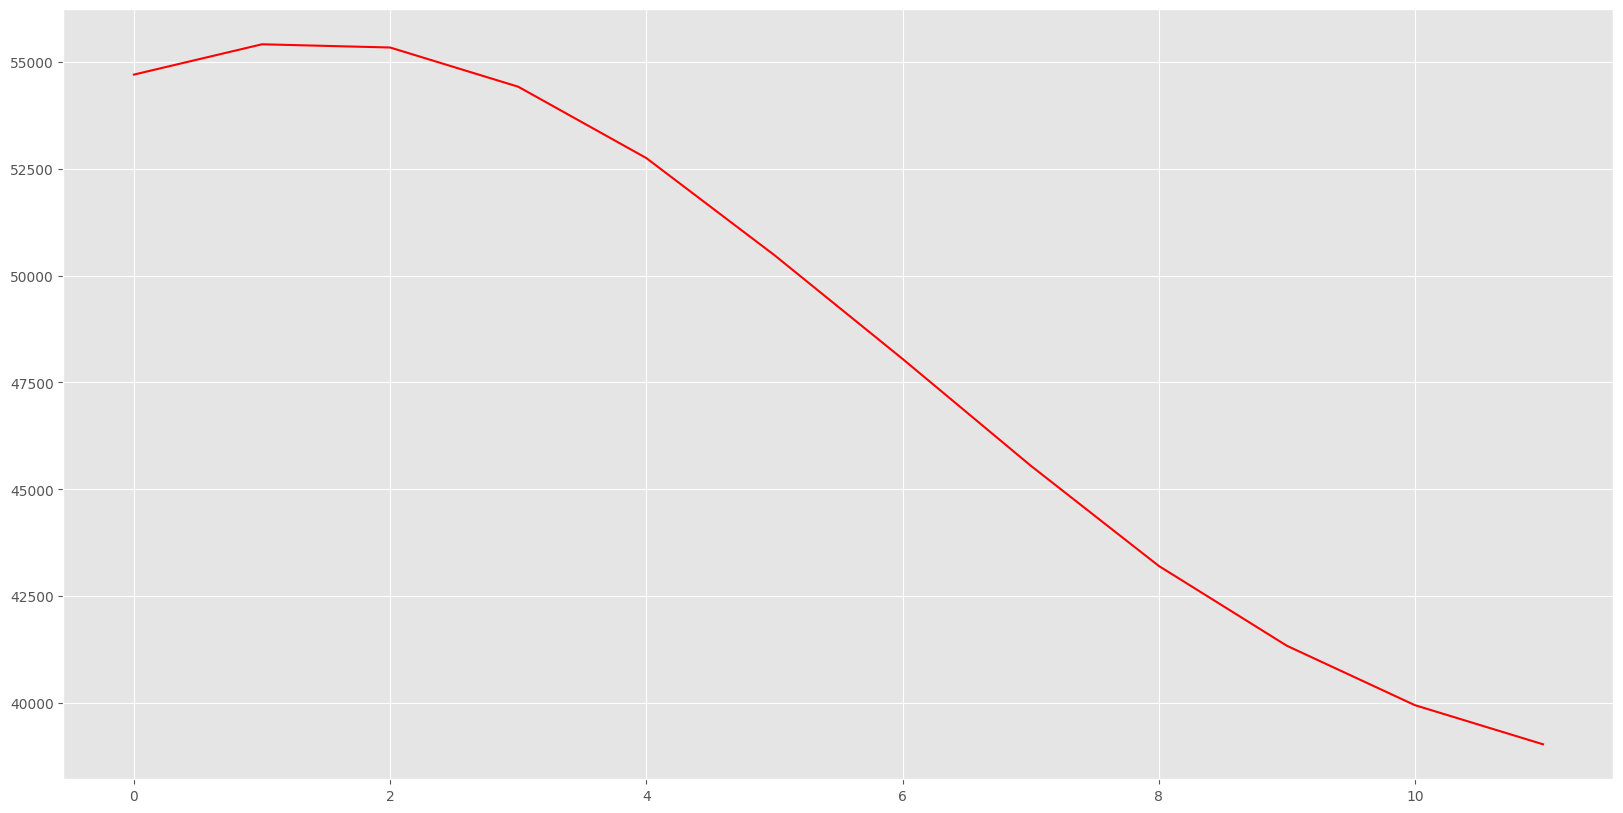

In [4164]:
plt.plot(yt_forecast, color="red")
#plt.plot(x1_test, color="black")

# Send Historical Forecast to Data Warehouse

In [2555]:
f1_df.to_sql('order_forecast_history', con=engine, schema='drp_staging', 
               method='multi', chunksize=50000, index=False, if_exists='replace')

97.1964


array([44848. , 47549. , 48759.5, 48090. , 45778. , 42474. , 38946.5,
       35927. , 33793.5, 32830. ])

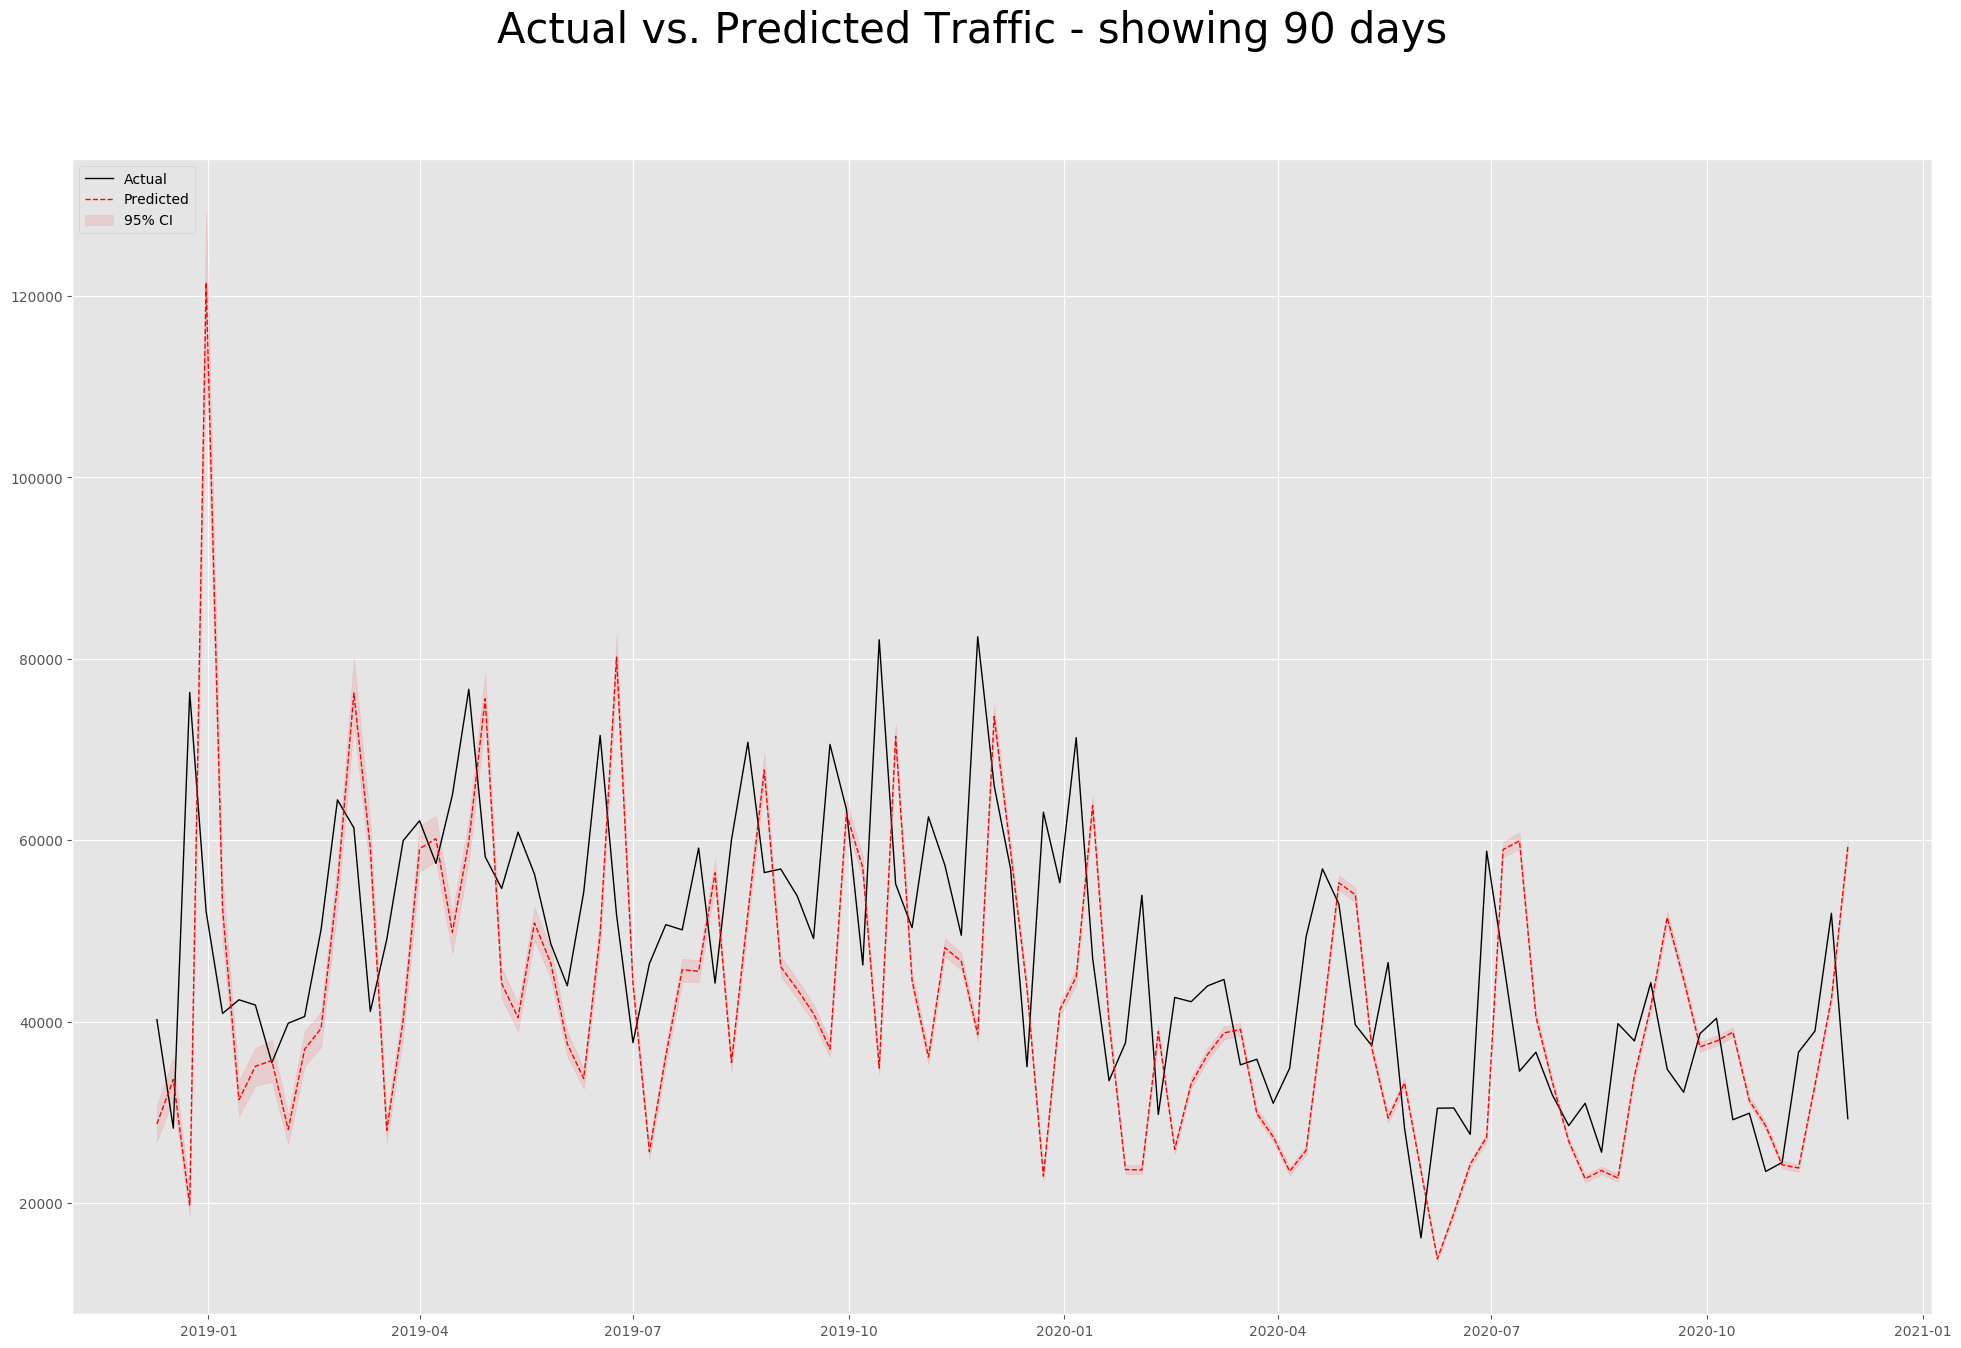

In [2886]:
# forecast the IV 
k=1
Y=x1
prior_length = 12
forecast_start = 0                                 
forecast_end = len(Y)-1
discount = 0.98


mod2, samples2 = analysis(Y, X=None, family="poisson",
forecast_start=forecast_start,      
forecast_end=forecast_end,         
k=k,
ntrend=1,
seasPeriods=[52],
nsamps=1000, 
seasHarmComponents=[[1,2,3,4]],
prior_length=prior_length,                     
deltrend=discount,                      
delregn=discount,                        
delVar=discount,
delseas=discount,
s0=0.01)

forecast_x1 = median(samples2)

future_x1 = mod2.forecast_path(10, nsamps=1000)
x1_forecast = median(future_x1)
x1_forecast

#forecast = median(samples)
ci = 95
alpha = (100-ci)/2
upper2 = np.percentile(samples2, [100-alpha],axis=0).reshape(-1)
lower2 = np.percentile(samples2, [alpha],axis=0).reshape(-1)
x_axis = np.arange(0,y[140:].shape[0],1)


lb = 104

print(np.round(MAPE(Y[forecast_start:forecast_end+1], forecast), 4))

plt.figure(figsize=(24,15)) 
plt.plot(x[-lb:], x1[-lb:], color='black', linewidth=1, label='Actual')
plt.plot(x[-lb:], forecast_x1[-lb:], linestyle='--', linewidth=1, label='Predicted', color='red')
plt.fill_between(x[-lb:], upper2[-lb:], lower2[-lb:], alpha=.1, color='r', label='95% CI')
plt.legend(loc="upper left")
plt.suptitle('Actual vs. Predicted Traffic - showing 90 days', fontsize=30)
x1_forecast

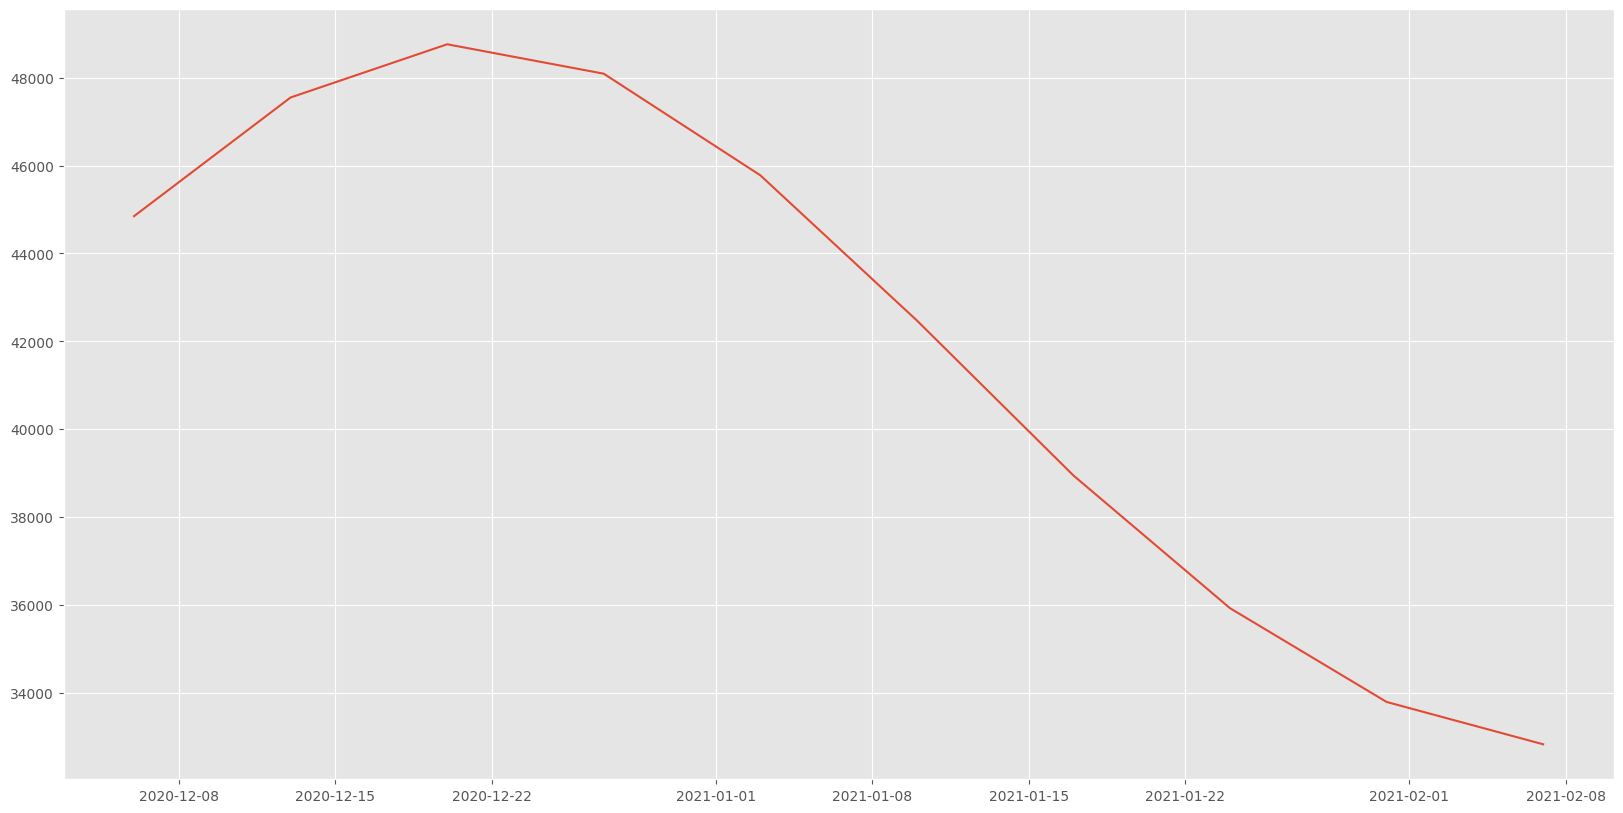

In [2887]:
plt.plot(f_date, x1_forecast)

# Predicting Inventory

In [207]:
sql_inv = """select
        date_trunc('week', CAST(inventory_date as DATE)) as week_date
        --inventory_date as date
        ,sum(inventory_quantity) as inventory
from drp.inventory_level_history
group by week_date
order by week_date"""

In [208]:
df_i = pd.read_sql(sql_inv, connection)

In [209]:
df_i.head()

week_date  inventory
0  2019-04-01          0
1  2019-04-08          0
2  2019-04-15          0
3  2019-04-29          0
4  2019-05-06          0

In [222]:
df_in = pd.merge(df_i, df_f[['week_date','total_orders']], on='week_date')
df_in = df_in.dropna()
df_in.head(60)

week_date  inventory  total_orders
0   2019-04-01          0          2918
1   2019-04-08          0          3009
2   2019-04-15          0          3208
3   2019-04-29          0          3308
4   2019-05-06          0          3392
5   2019-07-08          0          5834
6   2019-07-15          0          3861
7   2019-07-22          0          3590
8   2019-08-12          0          4223
9   2019-08-19          0          3058
10  2019-08-26          0          2931
11  2019-09-02         26          3333
12  2019-09-09          0          3781
13  2019-09-16          9          3387
14  2019-09-23         88          3347
15  2019-09-30        136          3099
16  2019-10-07       1307          3301
17  2019-10-14         34          3411
18  2019-10-21          9          3045
19  2019-10-28        169          3252
20  2019-11-04          0          3548
21  2019-11-11          0          4059
22  2019-11-18          0          3626
23  2019-11-25          0          5125
24  2019-12-02          9          6694
25  2019-12-09          0          8070
26  2019-12-16          9          6585
27  2019-12-23          0          3583
28  2019-12-30          9          4410
29  2020-01-06        446          7719
30  2020-01-13        346          4286
31  2020-01-20        206          4174
32  2020-01-27          0          4797
33  2020-02-03          0          4648
34  2020-02-17          0          4914
35  2020-03-16        448          6708
36  2020-03-30       3754         12763
37  2020-04-06          0         14355
38  2020-04-13          0         15763
39  2020-04-20          0         16595
40  2020-04-27          0         19049
41  2020-05-04       1314         17153
42  2020-05-11          0         16363
43  2020-05-18         33         16179
44  2020-05-25      16913         16546
45  2020-06-01        489         18325
46  2020-06-08         60         17088
47  2020-06-15          6         15129
48  2020-06-22       1355         14418
49  2020-06-29       5726         13037
50  2020-07-06      97144         15379
51  2020-07-13     323362         15324
52  2020-07-20    1539748         13282
53  2020-07-27    1652928         17541
54  2020-08-03    1688865         11441
55  2020-08-10    1731760         12128
56  2020-08-17    2020489         14260
57  2020-08-24    1879709         13104
58  2020-08-31    2313986         13004
59  2020-09-07    2091581         12972

In [217]:
date_i = df_in.week_date
yi = df_in.inventory
xi = df_in.total_orders.values

In [218]:
k=1
Y=yi.values
prior_length = 6
forecast_start = 0                                 
forecast_end = len(Y)-1
discount = 0.98


mod3, samples3 = analysis(Y, X=xi.reshape(-1,1), family="poisson",
forecast_start=forecast_start,      
forecast_end=forecast_end,         
k=k,
holiday = holidays,
ntrend=1,
seasPeriods=[52],
nsamps=1000, 
seasHarmComponents=[[1,2,3]],
prior_length=prior_length,                     
deltrend=discount,                      
delregn=.96,                        
delVar=.96,
delseas=.96,
s0=0.01)

forecast_i = median(samples3)
ci = 95
alpha = (100-ci)/2
upper = np.percentile(samples3, [100-alpha],axis=0).reshape(-1)
lower = np.percentile(samples3, [alpha],axis=0).reshape(-1)
x_axis = np.arange(0,y[140:].shape[0],1)


#future_y = mod.forecast_path(10, X=x1_test.reshape(-1,1), nsamps=1000)
future_yi = mod3.forecast_path(10, X=y_forecast.reshape(-1,1), nsamps=1000)
yi_forecast = median(future_yi)
yi_forecast

# Error Metric - using the mean absolute deviation (MAD)
print(np.round(MAPE(Y[forecast_start:forecast_end+1], forecast_i), 4))

lb = 30

plt.figure(figsize=(24,15)) 
plt.plot(date_i[-lb:], yi[-lb:], color='black', linewidth=1, label='Actual')
plt.plot(date_i[-lb:],forecast_i[-lb:], linestyle='--', linewidth=1, label='Predicted', color='red')
plt.fill_between(date_i[-lb:], upper[-lb:], lower[-lb:], alpha=.1, color='r', label='95% CI')
plt.legend(loc="upper left")
plt.suptitle('Actual vs. Predicted Inventory', fontsize=30)

ValueError: p < 0, p > 1 or p contains NaNs

In [ ]:
plt.plot(yi_forecast)

### Elbow Plot

In [27]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(RFM_norm1)
    distortions.append(kmeanModel.inertia_)

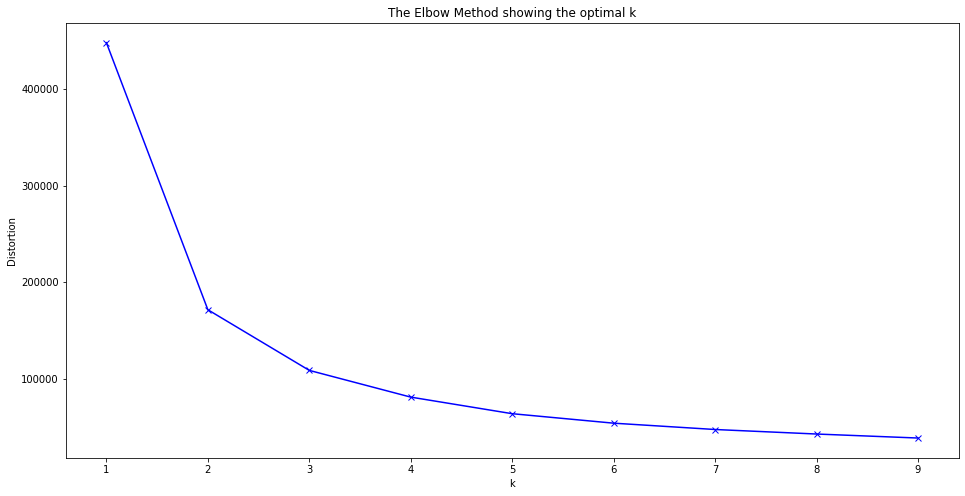

In [28]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Linear Regression

In [19]:
from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import metrics

In [20]:
lr_sql = """WITH first_order AS
(
    select
      cp.unique_customer_id
    , cp.first_order_id
    , cp.last_order_id
    , DATE_PART(MONTH, olr.order_date::date) as fo_date
    , first_order_fc_channel AS fo_channel
    , first_order_fc_vendor AS fo_vendor
    , sum(olr.gross_margin) AS fo_gross_margin
    , sum(olr.num_units) AS fo_num_units
    , sum(olr.discount_amount) as fo_discount_amt
    , sum(olr.shipping_amount) AS fo_shipping_amt
    , sum(olr.refund_amount) AS fo_refund_amt
    from drp.customer_profiles cp
    left join drp.order_line_revenue olr on olr.order_id = cp.first_order_id
    group by cp.unique_customer_id, cp.first_order_id, cp.last_order_id, order_date, fo_channel, fo_vendor
    --limit 100
)
SELECT
      cp.unique_customer_id
    , fo_channel
    , fo_vendor
    , fo_date
    , sum(fo_gross_margin) AS fo_gross_margin
    , sum(fo_num_units) AS fo_num_units
    , sum(fo_discount_amt) AS fo_discount_amt
    , sum(fo_shipping_amt) AS fo_shipping_amt
    , sum(fo_refund_amt) AS fo_refund_amt
    , CASE WHEN fo_refund_amt > 0 THEN 1 ELSE 0 END AS refund_flag
    , sum(cp.gross_margin) AS total_gross_margin --DV
    , sum(cp.num_orders) AS number_orders --DV
    , cp.last_order_date as lo_date
FROM drp.customer_profiles cp
LEFT JOIN first_order fo ON cp.unique_customer_id = fo.unique_customer_id
WHERE lo_date < '2020-12-01'
GROUP BY cp.unique_customer_id, lo_date, fo_channel, fo_vendor, fo_date, refund_flag
"""

In [21]:
lr_sql_new = """WITH first_order AS
(
    select
      cp.unique_customer_id
    , cp.first_order_id
    , cp.last_order_id
    , DATE_PART(MONTH, olr.order_date::date) as fo_date
    , first_order_fc_channel AS fo_channel
    , first_order_fc_vendor AS fo_vendor
    , sum(olr.gross_margin) AS fo_gross_margin
    , sum(olr.num_units) AS fo_num_units
    , sum(olr.discount_amount) as fo_discount_amt
    , sum(olr.shipping_amount) AS fo_shipping_amt
    , sum(olr.refund_amount) AS fo_refund_amt
    from drp.customer_profiles cp
    left join drp.order_line_revenue olr on olr.order_id = cp.first_order_id
    group by cp.unique_customer_id, cp.first_order_id, cp.last_order_id, order_date, fo_channel, fo_vendor
    --limit 100
)
SELECT
      cp.unique_customer_id
    , fo_channel
    , fo_vendor
    , fo_date
    , sum(fo_gross_margin) AS fo_gross_margin
    , sum(fo_num_units) AS fo_num_units
    , sum(fo_discount_amt) AS fo_discount_amt
    , sum(fo_shipping_amt) AS fo_shipping_amt
    , sum(fo_refund_amt) AS fo_refund_amt
    , CASE WHEN fo_refund_amt > 0 THEN 1 ELSE 0 END AS refund_flag
    , sum(cp.gross_margin) AS total_gross_margin --DV
    , sum(cp.num_orders) AS number_orders --DV
    , cp.last_order_date as lo_date
FROM drp.customer_profiles cp
LEFT JOIN first_order fo ON cp.unique_customer_id = fo.unique_customer_id
WHERE lo_date >= '2020-12-01'
GROUP BY cp.unique_customer_id, lo_date, fo_channel, fo_vendor, fo_date, refund_flag
"""

In [22]:
df_lr = pd.read_sql(lr_sql, connection)

In [23]:
df_lr_new = pd.read_sql(lr_sql_new, connection)

In [24]:
df_lr_red = df_lr.dropna()
len(df_lr_red)

540630

### Processing New Customers

Customers that have made 1 purchase in the past 30 days

In [491]:
df_lr_new = df_lr_new[df_lr_new.number_orders < 2].dropna()
len(df_lr_new)

50697

In [492]:
df_lr_new.describe()

fo_date  fo_gross_margin  fo_num_units  fo_discount_amt  \
count  50697.000000     50697.000000  50697.000000     50697.000000   
mean      11.997968       104.900462      2.081524        21.254413   
std        0.108680        81.310789      1.764702        34.370091   
min        2.000000      -238.010000      0.000000         0.000000   
25%       12.000000        62.630000      1.000000         0.000000   
50%       12.000000        77.300000      2.000000        16.800000   
75%       12.000000       128.900000      2.000000        33.600000   
max       12.000000      3030.300000     66.000000      2408.800000   

       fo_shipping_amt  fo_refund_amt   refund_flag  total_gross_margin  \
count     50697.000000   50697.000000  50697.000000        50697.000000   
mean          1.773320       0.214501      0.002387          104.952053   
std           3.647377       5.457013      0.048796           81.319082   
min           0.000000       0.000000      0.000000         -238.010000   
25%           0.000000       0.000000      0.000000           62.630000   
50%           0.000000       0.000000      0.000000           77.300000   
75%           0.000000       0.000000      0.000000          128.900000   
max          23.000400     468.720000      1.000000         3030.300000   

       number_orders  
count   50697.000000  
mean        0.996923  
std         0.055387  
min         0.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         1.000000

In [518]:
dummies_new = pd.get_dummies(df_lr_new, columns=['fo_channel','fo_vendor']).rename(columns=lambda x: 'Category_' + str(x))
df6 = pd.concat([df_lr_new, dummies_new], axis=1)
#df3 = df.drop(['fo_channel'], inplace=True, axis=1)
df7 = df6.drop(['fo_channel', 'fo_vendor', 'fo_date', 'lo_date', 'unique_customer_id', 
                'total_gross_margin', 'number_orders', 'Category_unique_customer_id',
       'Category_fo_gross_margin', 'Category_fo_num_units',
       'Category_fo_discount_amt', 'Category_fo_shipping_amt',
       'Category_fo_refund_amt', 'Category_refund_flag',
       'Category_total_gross_margin', 'Category_number_orders',
       'Category_lo_date'], axis=1, inplace=False).copy()
df7

fo_gross_margin  fo_num_units  fo_discount_amt  fo_shipping_amt  \
2                96.48             2             33.6              0.0   
4                61.54             1              0.0              0.0   
7                85.60             2             28.4              0.0   
12               62.63             1              0.0              0.0   
13               54.80             1              0.0              6.0   
...                ...           ...              ...              ...   
79659            77.30             1              0.0              0.0   
79661            57.70             1             19.6              0.0   
79662           476.18            10            163.4              0.0   
79663            70.92             1              0.0              0.0   
79666            47.25             1             16.8              6.0   

       fo_refund_amt  refund_flag  Category_fo_date  \
2                0.0            0                12   
4                0.0            0                12   
7                0.0            0                12   
12               0.0            0                12   
13               0.0            0                12   
...              ...          ...               ...   
79659            0.0            0                12   
79661            0.0            0                12   
79662            0.0            0                12   
79663            0.0            0                12   
79666            0.0            0                12   

       Category_fo_channel_(unavailable)  Category_fo_channel_Direct  \
2                                      0                           0   
4                                      0                           1   
7                                      0                           0   
12                                     0                           0   
13                                     0                           0   
...                                  ...                         ...   
79659                                  0                           0   
79661                                  0                           0   
79662                                  0                           0   
79663                                  0                           0   
79666                                  0                           0   

       Category_fo_channel_Display  Category_fo_channel_Email  \
2                                0                          0   
4                                0                          0   
7                                0                          1   
12                               0                          0   
13                               0                          0   
...                            ...                        ...   
79659                            0                          0   
79661                            0                          0   
79662                            0                          1   
79663                            0                          0   
79666                            0                          0   

       Category_fo_channel_Missing from GA  \
2                                        1   
4                                        0   
7                                        0   
12                                       0   
13                                       0   
...                                    ...   
79659                                    0   
79661                                    0   
79662                                    0   
79663                                    0   
79666                                    1   

       Category_fo_channel_Organic Search  \
2                                       0   
4                                       0   
7                                       0   
12                                      0   
13                               

In [520]:
X_vars_new = df7[col]

In [594]:
y_pred_hvc = rf_model.predict(X_vars_new)

# New OBS: Class Prediction of Repeat
y_pred_rpt = rf_model_rpt.predict(X_vars_new)
# New OBS: Repeat - Probabilities for each class
y_prob_rpt = rf_model_rpt.predict_proba(X_vars_new)[:, 1]

In [639]:
df10 = pd.DataFrame(df6['unique_customer_id'])
df10['prob_hvc'] = y_pred_hvc
df10['pred_rpt'] = y_pred_rpt
df10['prob_rpt'] = y_prob_rpt
df10['email_anonymous'] = [shuffle_word(word) for word in df10['unique_customer_id']]
df10

unique_customer_id  prob_hvc  pred_rpt  prob_rpt  \
2              jmjones98@yahoo.com         0         0  0.282060   
4               smotley@icloud.com         0         0  0.230860   
7                ejlawre60@msn.com         0         0  0.138131   
12           lori.v.egan@gmail.com         0         0  0.194445   
13                  kotero@cox.net         0         0  0.443428   
...                            ...       ...       ...       ...   
79659            jesseog@gmail.com         1         1  0.651867   
79661           jacduffy@gmail.com         0         0  0.165933   
79662      hong.candices@gmail.com         0         0  0.230000   
79663  elizabeth.bassler@gmail.com         0         0  0.351540   
79666         ssmile1976@gmail.com         0         0  0.022661   

                   email_anonymous  
2              ejh9c.samoomjnoo@8y  
4               .cdooeimc@tmyllsou  
7                mweem60osa@jnl.cr  
12           ragic.vlmanoilmog.@e.  
13                  xnroo.kett@oce  
...                            ...  
79659            oojle.seamigcm@gs  
79661           @ycolmugacmfdiajf.  
79662      gscimnaoilhoa@c.mn.cgde  
79663  ieoslcelgt@hmarbbs.ima.aelz  
79666         imlg6lmao9m1cs@7ie.s  

[50697 rows x 5 columns]

In [640]:
send_data(df10, 'new_customer_classification')

new_customer_classification updated!


In [269]:
df_lr_red.head()

unique_customer_id       fo_channel        fo_vendor  fo_date  \
0    bradmix2000@gmail.com   Organic Search  Missing from GA       10   
1     k5harris12@gmail.com  Missing from GA  Missing from GA        2   
2  caitlindowd@verizon.net           Direct  Missing from GA       11   
3       johnkochman@me.com   Organic Search  Missing from GA        6   
4       bsundick@gmail.com  Missing from GA  Missing from GA        7   

   fo_gross_margin  fo_num_units  fo_discount_amt  fo_shipping_amt  \
0            67.80             1              0.0              0.0   
1            54.40             1             13.6              6.0   
2           236.74             5             81.8              0.0   
3            82.85             2              0.0              0.0   
4           136.00             2              0.0              0.0   

   fo_refund_amt  refund_flag  total_gross_margin  number_orders  \
0            0.0            0               67.80              1   
1            0.0            0              449.00              6   
2            0.0            0              236.74              1   
3            0.0            0               82.85              1   
4            0.0            0              136.00              1   

              lo_date  
0 2020-10-22 17:40:54  
1 2019-07-20 08:44:18  
2 2020-11-18 12:33:03  
3 2020-06-11 12:16:30  
4 2017-07-25 20:24:43

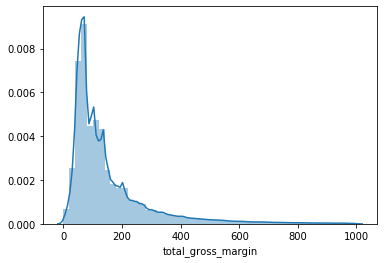

In [423]:
sns.distplot(df_lr_red[(df_lr_red.total_gross_margin < 1000) & (df_lr_red.total_gross_margin >= 0)].total_gross_margin)

In [599]:
# Remove likely wholesale customers
#df_LR2 = df_lr_red[(df_lr_red.total_gross_margin < 10000) & (df_lr_red.total_gross_margin > 0)]
df_LR2 = df_lr_red[(df_lr_red.total_gross_margin < 5000) & (df_lr_red.total_gross_margin >= 0)]
print(df_LR2.total_gross_margin.median())

#define the dependent variables
df_LR2['hvc'] = np.where(df_LR2['total_gross_margin'] > 500, 1,0)
df_LR2['repeat'] = np.where(df_LR2['number_orders'] > 1,1,0)
df_LR2

101.3


unique_customer_id       fo_channel        fo_vendor  \
0                 bradmix2000@gmail.com   Organic Search  Missing from GA   
1                  k5harris12@gmail.com  Missing from GA  Missing from GA   
2               caitlindowd@verizon.net           Direct  Missing from GA   
3                    johnkochman@me.com   Organic Search  Missing from GA   
4                    bsundick@gmail.com  Missing from GA  Missing from GA   
...                                 ...              ...              ...   
544498  tpfingst@kilpatricktownsend.com   Organic Search  Missing from GA   
544499            abujawdeh@hotmail.com           Direct  Missing from GA   
544500            katvar.rs@hotmail.com      Paid Search  Missing from GA   
544501               angiec@hotmail.com      Paid Search  Missing from GA   
544502               tmajor99@yahoo.com      Paid Search  Missing from GA   

        fo_date  fo_gross_margin  fo_num_units  fo_discount_amt  \
0            10            67.80             1              0.0   
1             2            54.40             1             13.6   
2            11           236.74             5             81.8   
3             6            82.85             2              0.0   
4             7           136.00             2              0.0   
...         ...              ...           ...              ...   
544498       10            64.55             1              0.0   
544499        4           167.00             3              0.0   
544500        7            67.45             1              0.0   
544501        4            64.85             2              0.0   
544502        5            99.95             2              0.0   

        fo_shipping_amt  fo_refund_amt  refund_flag  total_gross_margin  \
0                   0.0            0.0            0               67.80   
1                   6.0            0.0            0              449.00   
2                   0.0            0.0            0              236.74   
3                   0.0            0.0            0               82.85   
4                   0.0            0.0            0              136.00   
...                 ...            ...          ...                 ...   
544498              0.0            0.0            0               64.55   
544499              0.0            0.0            0              347.50   
544500              0.0            0.0            0               67.45   
544501              0.0            0.0            0              130.25   
544502              0.0            0.0            0              200.35   

        number_orders             lo_date  hvc  repeat  
0                   1 2020-10-22 17:40:54    0       0  
1                   6 2019-07-20 08:44:18    0       1  
2                   1 2020-11-18 12:33:03    0       0  
3                   1 2020-06-11 12:16:30    0       0  
4                   1 2017-07-25 20:24:43    0       0  
...               ...                 ...  ...     ...  
544498              1 2020-10-27 05:30:37    0       0  
544499              2 2020-04-26 17:02:37    0       1  
544500              1 2020-07-03 16:40:43    0       0  
544501              2 2020-08-11 16:30:21    0       1  
544502              2 2020-05-19 22:25:22    0       1  

[518699 rows x 15 columns]

## Define Categorical Dummies

In [600]:
dummies = pd.get_dummies(df_LR2, columns=['fo_channel','fo_vendor']).rename(columns=lambda x: 'Category_' + str(x))
df3 = pd.concat([df_LR2, dummies], axis=1)
#df3 = df.drop(['fo_channel'], inplace=True, axis=1)
df3

unique_customer_id       fo_channel        fo_vendor  \
0                 bradmix2000@gmail.com   Organic Search  Missing from GA   
1                  k5harris12@gmail.com  Missing from GA  Missing from GA   
2               caitlindowd@verizon.net           Direct  Missing from GA   
3                    johnkochman@me.com   Organic Search  Missing from GA   
4                    bsundick@gmail.com  Missing from GA  Missing from GA   
...                                 ...              ...              ...   
544498  tpfingst@kilpatricktownsend.com   Organic Search  Missing from GA   
544499            abujawdeh@hotmail.com           Direct  Missing from GA   
544500            katvar.rs@hotmail.com      Paid Search  Missing from GA   
544501               angiec@hotmail.com      Paid Search  Missing from GA   
544502               tmajor99@yahoo.com      Paid Search  Missing from GA   

        fo_date  fo_gross_margin  fo_num_units  fo_discount_amt  \
0            10            67.80             1              0.0   
1             2            54.40             1             13.6   
2            11           236.74             5             81.8   
3             6            82.85             2              0.0   
4             7           136.00             2              0.0   
...         ...              ...           ...              ...   
544498       10            64.55             1              0.0   
544499        4           167.00             3              0.0   
544500        7            67.45             1              0.0   
544501        4            64.85             2              0.0   
544502        5            99.95             2              0.0   

        fo_shipping_amt  fo_refund_amt  refund_flag  ...  \
0                   0.0            0.0            0  ...   
1                   6.0            0.0            0  ...   
2                   0.0            0.0            0  ...   
3                   0.0            0.0            0  ...   
4                   0.0            0.0            0  ...   
...                 ...            ...          ...  ...   
544498              0.0            0.0            0  ...   
544499              0.0            0.0            0  ...   
544500              0.0            0.0            0  ...   
544501              0.0            0.0            0  ...   
544502              0.0            0.0            0  ...   

        Category_fo_channel_Direct  Category_fo_channel_Display  \
0                                0                            0   
1                                0                            0   
2                                1                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
544498                           0                            0   
544499                           1                            0   
544500                           0                            0   
544501                           0                            0   
544502                           0                            0   

       Category_fo_channel_Email  Category_fo_channel_Missing from GA  \
0                              0                                    0   
1                              0                                    1   
2                              0                                    0   
3                              0                                    0   
4                              0                                    1   
...                          ...                                  ...   
544498                         0                                    0   
544499                         0                                    0   
544500                         0                                    0   
544501                         0   

In [601]:
df4 = df3.drop(['fo_channel', 'fo_vendor', 'fo_date', 'lo_date', 'unique_customer_id', 'total_gross_margin', 'number_orders', 'hvc', 'repeat', 'Category_unique_customer_id',
       'Category_fo_gross_margin', 'Category_fo_num_units',
       'Category_fo_discount_amt', 'Category_fo_shipping_amt',
       'Category_fo_refund_amt', 'Category_refund_flag',
       'Category_total_gross_margin', 'Category_number_orders',
       'Category_lo_date', 'Category_hvc', 'Category_repeat'], axis=1, inplace=False).copy()
df4

fo_gross_margin  fo_num_units  fo_discount_amt  fo_shipping_amt  \
0                 67.80             1              0.0              0.0   
1                 54.40             1             13.6              6.0   
2                236.74             5             81.8              0.0   
3                 82.85             2              0.0              0.0   
4                136.00             2              0.0              0.0   
...                 ...           ...              ...              ...   
544498            64.55             1              0.0              0.0   
544499           167.00             3              0.0              0.0   
544500            67.45             1              0.0              0.0   
544501            64.85             2              0.0              0.0   
544502            99.95             2              0.0              0.0   

        fo_refund_amt  refund_flag  Category_fo_date  \
0                 0.0            0                10   
1                 0.0            0                 2   
2                 0.0            0                11   
3                 0.0            0                 6   
4                 0.0            0                 7   
...               ...          ...               ...   
544498            0.0            0                10   
544499            0.0            0                 4   
544500            0.0            0                 7   
544501            0.0            0                 4   
544502            0.0            0                 5   

        Category_fo_channel_(unavailable)  Category_fo_channel_Direct  \
0                                       0                           0   
1                                       0                           0   
2                                       0                           1   
3                                       0                           0   
4                                       0                           0   
...                                   ...                         ...   
544498                                  0                           0   
544499                                  0                           1   
544500                                  0                           0   
544501                                  0                           0   
544502                                  0                           0   

        Category_fo_channel_Display  Category_fo_channel_Email  \
0                                 0                          0   
1                                 0                          0   
2                                 0                          0   
3                                 0                          0   
4                                 0                          0   
...                             ...                        ...   
544498                            0                          0   
544499                            0                          0   
544500                            0                          0   
544501                            0                          0   
544502                            0                          0   

        Category_fo_channel_Missing from GA  \
0                                         0   
1                                         1   
2                                         0   
3                                         0   
4                                         1   
...                                     ...   
544498                                    0   
544499                                    0   
544500                                    0   
544501                                    0   
544502                                    0   

        Category_fo_channel_Organic Search  \
0                                        1   
1                                        0   
2                                        0   
3              

In [602]:
df4.columns.values

array(['fo_gross_margin', 'fo_num_units', 'fo_discount_amt',
       'fo_shipping_amt', 'fo_refund_amt', 'refund_flag',
       'Category_fo_date', 'Category_fo_channel_(unavailable)',
       'Category_fo_channel_Direct', 'Category_fo_channel_Display',
       'Category_fo_channel_Email', 'Category_fo_channel_Missing from GA',
       'Category_fo_channel_Organic Search',
       'Category_fo_channel_Other Advertising',
       'Category_fo_channel_Paid Search', 'Category_fo_channel_Referral',
       'Category_fo_channel_Social Network',
       'Category_fo_vendor_Missing from GA'], dtype=object)

In [610]:
col = list(df4.columns)
X_vars = df4[col]
X_vars2 = df4[['fo_gross_margin', 'fo_num_units', 'fo_discount_amt','fo_shipping_amt', 'fo_refund_amt']]
X_vars
Y_hvc = df3['hvc']
Y_repeat = df3['repeat']
Y_tgm = df3['total_gross_margin']
#df.drop(col, axis=1, inplace=1)
X_train, X_test, y_train, y_test = train_test_split(X_vars, Y_hvc, test_size=0.3, random_state=42)

In [611]:

logreg = LogisticRegression(class_weight="balanced", C=.01)
#logreg = LogisticRegression(C=.0001)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

Accuracy of logistic regression classifier on test set: 0.79
[[118050  30092]
 [  2616   4852]]


In [612]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88    148142
           1       0.14      0.65      0.23      7468

   micro avg       0.79      0.79      0.79    155610
   macro avg       0.56      0.72      0.55    155610
weighted avg       0.94      0.79      0.85    155610



## Random Forest

In [613]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf_model_rpt = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               #max_depth =8,
                               max_features = 'sqrt',
                              class_weight='balanced')
# Fit on training data
rf_model_rpt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [614]:
# Actual class predictions
rf_predictions = rf_model_rpt.predict(X_test)
# Probabilities for each class
rf_probs = rf_model_rpt.predict_proba(X_test)[:, 1]

In [615]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93    148142
           1       0.13      0.32      0.19      7468

   micro avg       0.87      0.87      0.87    155610
   macro avg       0.55      0.61      0.56    155610
weighted avg       0.92      0.87      0.89    155610



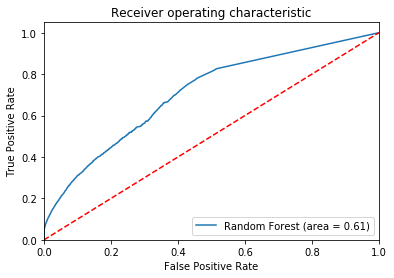

In [616]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf_roc_auc = roc_auc_score(y_test, rf_model_rpt.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

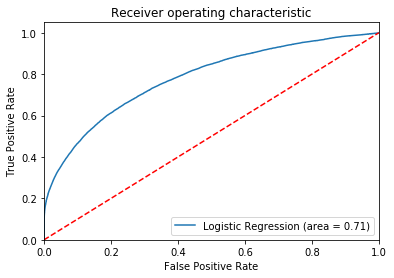

In [512]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## StatsModels

In [279]:

X = df_LR2[['fo_gross_margin', 'fo_num_units', 'fo_discount_amt', 'fo_shipping_amt', 'fo_refund_amt']]
Y = df_LR2.total_gross_margin
X = sm.add_constant(X)
lr_result = OLS(Y,X).fit().summary()

In [280]:
lr_result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     total_gross_margin   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                 3.690e+04
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:37:55   Log-Likelihood:            -3.3896e+06
No. Observations:              518393   AIC:                         6.779e+06
Df Residuals:                  518387   BIC:                         6.779e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              27.6020      0.428     64.566      0.000      26.764      28.440
fo_gross_margin     1.6020      0.007    219.753      0.000       1.588       1.616
fo_num_units      -10.3700      0.414    -25.058      0.000     -11.181      -9.559
fo_discount_amt    -0.2310      0.012    -19.958      0.000      -0.254      -0.208
fo_shipping_amt     0.5662      0.046     12.286      0.000       0.476       0.657
fo_refund_amt       0.5578      0.010     57.242      0.000       0.539       0.577
==============================================================================
Omnibus:                   540923.042   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42327040.155
Skew:                           5.237   Prob(JB):                         0.00
Kurtosis:                      46.010   Cond. No.                         235.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [281]:
X = df_LR2[['fo_gross_margin', 'fo_num_units', 'fo_discount_amt', 'fo_shipping_amt', 'fo_refund_amt']]
Y = df_LR2.hvc
X = sm.add_constant(X)
logit_mod = sm.Logit(Y,X)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.162734
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    hvc   No. Observations:               518393
Model:                          Logit   Df Residuals:                   518387
Method:                           MLE   Df Model:                            5
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                  0.1541
Time:                        11:38:43   Log-Likelihood:                -84360.
converged:                       True   LL-Null:                       -99733.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.4009      0.013   -342.094      0.000      -4.426      -4.376
fo_gross_margin     0.0146      0.000     83.083      0.000       0.014       0.015
fo_num_units       -0.1753      0.010    -17.333      0.000      -0.195      -0.155
fo_discount_amt    -0.0019      0.000     -7.031      0.000      -0.002      -0.001
fo_shipping_amt     0.0060      0.001      5.466      0.000       0.004       0.008
fo_refund_amt       0.0053      0.000     20.441      0.000       0.005       0.006
===================================================================================
"""

In [282]:
logit_res.pred_table()

array([[492124.,   1420.],
       [ 22212.,   2637.]])

In [283]:
yhat = logit_res.predict(X) 
prediction = list(map(round, yhat)) 

In [285]:
# confusion matrix 
cm = confusion_matrix(df_LR2.hvc, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(df_LR2.hvc, prediction))

Confusion Matrix : 
 [[492124   1420]
 [ 22212   2637]]
Test accuracy =  0.954412964681236


In [170]:
df_LR3 = df_LR2[['fo_gross_margin', 'fo_num_units', 'fo_discount_amt', 'repeat']]

In [171]:
df_LR3.repeat.mean()

0.14629589361880072

In [172]:

x_train, x_test, y_train, y_test = train_test_split(df_LR3.drop('repeat',axis=1), 
                                                    df_LR3['repeat'], test_size=0.30, 
                                                    random_state=42)

In [173]:

scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)




In [174]:

logmodel = LogisticRegression(penalty='l2',class_weight="balanced", C=.01)
#logmodel.fit(x_train,y_train)
logmodel.fit(X_scale,Y)
predictions = logmodel.predict(X_scale)

In [175]:

print(classification_report(Y,predictions))




fpr, tpr, thresholds = metrics.roc_curve(Y, predictions, pos_label=1)
metrics.auc(fpr, tpr)

              precision    recall  f1-score   support

           0       0.97      0.79      0.87    566246
           1       0.14      0.59      0.22     31604

   micro avg       0.78      0.78      0.78    597850
   macro avg       0.55      0.69      0.55    597850
weighted avg       0.93      0.78      0.84    597850



0.689745936869553